## Load relevant packages

In [1]:
# Import all the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from copy import deepcopy
%matplotlib inline

## Load data files

In [2]:
#================================================================================================
# USER INPUT!
# Here I specify which data files need reading in
datafilenames = ["natinalitycleantrain.csv"]
# For each data file, we write which column contains the information we want to predict
topredictcolumn= ["Survived"]
#================================================================================================

# FROM HERE ON IT'S AUTOMATIC

# Sometiems the index column gets saved automatically as a new column when writingto csv. 
# We'll remove these as they serve no purpose.
alldataframes = [pd.read_csv(filename) for filename in datafilenames]

for (pos,frame) in enumerate(alldataframes):
    toadd = frame
    if "Unnamed: 0" in frame:
        toadd = toadd.drop("Unnamed: 0",axis=1)
    if "Unnamed: 0.1" in frame:
        toadd = toadd.drop("Unnamed: 0.1",axis=1)
    alldataframes[pos] = toadd

# Descriptive data analysis on global dataset

We begin with a descriptive data analysis on the full dataset. We will count the number of occurrances of each feature to get an idea of their distribution.

### Functions for removing the data we don't want to plot

In [3]:
#This function removes those rows in "inputdataframe" where data was generated automatially 
# in the column "columnofinterest". "dictofunknown" contains the information on what data was
# generated automatically.
def removeAutogeneratedData(inputdataframe, columnsofinterest, dictofunknown):
    if type(columnsofinterest)==str:
        allcolumnsofinterest = [columnsofinterest]
    else:
        allcolumnsofinterest = columnsofinterest
    outputdataframe = deepcopy(inputdataframe)
    for col in allcolumnsofinterest:
        if col in dictofunknown:
            outputdataframe = outputdataframe[outputdataframe[col]!= dictofunknown[col]]
    return outputdataframe

# Iteratively goes through a dataframe, removing "rare" data for each element in the list 
# of relevantcolumns, until the dataframe stops changing
def removeSparseColumns(thedataframe, relevantcolumns):
    olddataframe = deepcopy(thedataframe)
    newdataframe = removeSparseColumnsIteration(olddataframe, relevantcolumns)
    while newdataframe.shape[0] != olddataframe.shape[0]:
        olddataframe = newdataframe
        newdataframe = removeSparseColumnsIteration(olddataframe, relevantcolumns)
    return newdataframe

#### Helper functions for removing data

In [4]:
# Helper function for the removeSparseColumns function. This function takes a dataframe, 
# goes through relevantcolumns, and in each column removes those rows whose value applies
# to less than 4% of the data, and in this sense are "rare" or "sparse".
def removeSparseColumnsIteration(inputdataframe, relevantcolumns):
    returneddataframe = deepcopy(inputdataframe)
    for col in relevantcolumns:
        uniquevalues = returneddataframe[col].unique()
        if len(uniquevalues) >= 12:
            minnumberofrows = np.floor(returneddataframe.shape[0]*0.04)
            valueswithenoughdata = []
            for val in uniquevalues:
                if returneddataframe[returneddataframe[col] == val].shape[0] > minnumberofrows:
                    valueswithenoughdata.append(val)
            returneddataframe = returneddataframe[returneddataframe[col].apply(lambda x: x in valueswithenoughdata)]
    return returneddataframe

### Functions for making histogram plots for quantitative data and bar plots for ordinal and categorical data, as well as their error bars

#### Functions for aesthetic presentation

In [5]:
# Returns a list of Brewer colors for categorical data. The colors were taken from the 
# Brewer scale http://colorbrewer2.org/?type=qualitative&scheme=Paired&n=12
def brewerColors(listlength=12):
    return ["#a6cee3","#1f78b4","#b2df8a","#33a02c", "#fb9a99", "#e31a1c", "#fdbf6f", 
            "#ff7f00", "#cab2d6", "#6a3d9a", "#ffff99", "#b15928"][:min(12,listlength)]

# Checks if the values of the xaxis would be better plotted on a log scale. Returns True or False.
def isLogScaleNeeded(xvaluesofalldata):
    output = False
    # For this we require that all values are positive and that the maximum value
    # is less than 3 times bigger than the size of the bottom 80% of the values.
    numcaseslessthanzero = len(np.where(xvaluesofalldata<=0)[0])
    if numcaseslessthanzero==0:
        aremostdatapointslow = max(xvaluesofalldata) / np.percentile((xvaluesofalldata - min(xvaluesofalldata)),80) > 3
        if aremostdatapointslow==True:
            output = True
    return output

# Takes the values of the xaxis and a "plot-axis" and, if it passes a few checks,
# changes the xaxis scale to a log scale.
def placeLogScaleIfNeeded(xvaluesofalldata, currentaxis):
    if isLogScaleNeeded(xvaluesofalldata):
        currentaxis.set_xscale("log")
        currentaxis.set_xlabel(currentaxis.get_xlabel() + " (N.B. Log scale!)")
    return currentaxis

#### Functions for drawing the histogram (quantitative) and bar (ordinal and categorical) plots

In [6]:
# Draws a barplot showing the total number of elements in a given column of a given dataframe,
# with error bars, using the function getCompositionAndErrorbar. This is intended for use in categorical columns.
def drawBarPlotOfTotals(thedataframe, columnname, num_iterations = 100, placeinax="none", sort=True):
    totalsanderrors = getCompositionAndErrorbar(thedataframe,columnname,num_iterations=num_iterations)
    mean_and_std_dataframe = turnValueAndErrorIntoFrame(totalsanderrors)
    if sort==True:
        mean_and_std_dataframe = mean_and_std_dataframe.sort_values("Mean", ascending=False)
    if placeinax=="none":
        mean_and_std_dataframe["Mean"].plot.bar(yerr=mean_and_std_dataframe["StandardDeviation"], color=brewerColors(1))
        plt.xlabel(columnname)
        plt.ylabel("Total")
        plt.title("Composition of "+columnname)
        plt.show()
    else:
        mean_and_std_dataframe["Mean"].plot.bar(yerr=mean_and_std_dataframe["StandardDeviation"], 
                                                ax=placeinax, color=brewerColors(1))
        placeinax.set_xlabel(columnname)
        placeinax.set_ylabel("Total")
        placeinax.set_title("Composition of "+columnname)
        
# Draws a histogram of a given quantitative column of a given dataframe,
# with error bars, using the function getHistogramErrorbar.
def drawHistogramOfTotals(thedataframe, columnname, num_iterations = 1000, placeinax="none"):
    logscale = isLogScaleNeeded(thedataframe[columnname])
    (histerrorbars, bins) = getHistogramErrorbar(thedataframe, columnname, num_iterations, log=logscale)
    if placeinax=="none":
        (n, bins, _) = plt.hist(thedataframe[columnname], bins=bins, histtype = 'step')
    else:
        (n, bins, _) = placeinax.hist(thedataframe[columnname], bins=bins, histtype = 'step')
    mid = midPointsOfBins(bins, log=logscale)
    if placeinax=="none":
        plt.errorbar(mid, n, yerr=histerrorbars, fmt='none')
        if logscale==True:
            plt.xlabel(columnname + " (N.B. Log scale!)")
            plt.xscale("log")
        else:
            plt.xlabel(columnname)
        plt.ylabel("Total")
        plt.title("Distribution of "+columnname)
        plt.show()
    else:
        placeinax.errorbar(mid, n, yerr=histerrorbars, fmt='none')
        placeinax.set_ylabel("Total")
        if logscale==True:
            placeinax.set_xscale("log")
            placeinax.set_xlabel(columnname + " (N.B. Log scale!)")
        else:
            placeinax.set_xlabel(columnname)
        placeinax.set_title("Distribution of "+columnname)
        
# This high-level function goes through all columns in a dataframe and makes a plot of each of the
# features. It needs to know what types of data we have, which columns it should skip (uselesscols)
# and a dictionary that says which rows of the data constitute NaNs that have been filled in automatically
def descriptiveAnalysisGlobalSet(inputdataframe, datacateg, uselesscols, dictofunknown):
    validcolumnstoplot = [col for col in inputdataframe if (datacateg[col] in ["C","O","QA","QC"] and (col not in uselesscols))]
    numberofrows = int(np.ceil(len(validcolumnstoplot) / 3.))
    fig, axes = plt.subplots(nrows=numberofrows, ncols=3, figsize=(12,4*numberofrows), tight_layout=True)
    for (currentax,col) in zip(axes.ravel(), validcolumnstoplot):
        if (datacateg[col]=="C" or datacateg[col]=="O") and (col not in uselesscols):
            drawBarPlotOfTotals(removeAutogeneratedData(inputdataframe,col,dictofunknown), col, placeinax=currentax)
        if (datacateg[col]=="QA" or datacateg[col]=="QC") and (col not in uselesscols):
            drawHistogramOfTotals(removeAutogeneratedData(inputdataframe,col,dictofunknown), col, placeinax=currentax)
    for remainingax in axes.ravel()[len(validcolumnstoplot):]:
        remainingax.axis("off")

#### Helper functions for the bar plot

In [7]:
# This function takes a dataframe and a column with categorical data and gives the number 
# of occurrances of each distinct entry, with error bars (which are computer by bootstrapping).
# The output is given in the form {distinctentry: [total(on average),errorbars], ...}
def getCompositionAndErrorbar(thedataframe, columnname, num_iterations = 1000, normalized=False):
    categories = thedataframe[columnname].unique()
    sizesample = thedataframe.shape[0]
    sampletotals = []
    for ii in range(num_iterations):
        sampledcolumn = thedataframe.sample(n=sizesample, replace=True)[columnname]
        totalsofcategories = [(sampledcolumn == cat).sum() for cat in categories]
        sampletotals.append(totalsofcategories)
    sampletotals = np.transpose(np.array(sampletotals))
    if normalized==True:
        numofcasesanderrors = dict([(categories[ij], 
                                     [totals.mean() / float(sizesample), totals.std() / float(sizesample)]) 
                                    for (ij,totals) in enumerate(sampletotals)])
    else:
        numofcasesanderrors = dict([(categories[ij], [totals.mean(), totals.std()]) for (ij,totals) in enumerate(sampletotals)])
    return numofcasesanderrors

# Takes the output of getCompositionAndErrorbar and turns it into a dataframe
def turnValueAndErrorIntoFrame(totalsanderrors):
    indices = list(totalsanderrors)
    mean_and_std_dataframe = pd.DataFrame({"Mean": [totalsanderrors[ind][0] for ind in indices], 
              "StandardDeviation": [totalsanderrors[ind][1] for ind in indices]}, index=indices).sort_index()
    return mean_and_std_dataframe

#### Helper functions for the histogram plot

In [8]:
# Returns the error bars and bins of a histogram of a quantitative column by bootstrapping the histogram counts
def getHistogramErrorbar(thedataframe, columnname, num_iterations = 1000, normalized=False, inputbins="none", log=False):
    sizesample = thedataframe.shape[0]
    if type(inputbins)==str and inputbins=="none":
        if log==True:
            binstouse = np.logspace(np.log10(min(thedataframe[columnname])),np.log10(max(thedataframe[columnname])),10)
        else:
            binstouse = np.histogram(thedataframe[columnname])[1]
    else:
        binstouse = inputbins
    sampletotals = []
    for ii in range(num_iterations):
        sampledcolumn = thedataframe.sample(n=sizesample, replace=True)[columnname]
        sampletotals.append(np.histogram(sampledcolumn, bins=binstouse))
    binvalues = np.transpose(np.array([histogramvalues[0] for histogramvalues in sampletotals]))
    if normalized==True:
        if log==True:
            histogramdata = ([binval.std()/(float(sizesample)*(binstouse[ik+1]-binstouse[ik])) 
                              for ik,binval in enumerate(binvalues)], binstouse)
        else:
            histogramdata = ([binval.std()/(float(sizesample)*(binstouse[-1]-binstouse[-2])) for binval in binvalues], binstouse)
    else:
        histogramdata = ([binval.std() for binval in binvalues], binstouse)
    return histogramdata

def midPointsOfBins(binarray, log=False):
    if log==True:
        mid = 10**(0.5*(np.log10(binarray[1:]) + np.log10(binarray[:-1])))
    else:
        mid = 0.5*(binarray[1:] + binarray[:-1])
    return mid

### Analysis on global dataset

ANALYZING DATAFRAME FROM natinalitycleantrain.csv:


C:\Users\Daniele\Anaconda2\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


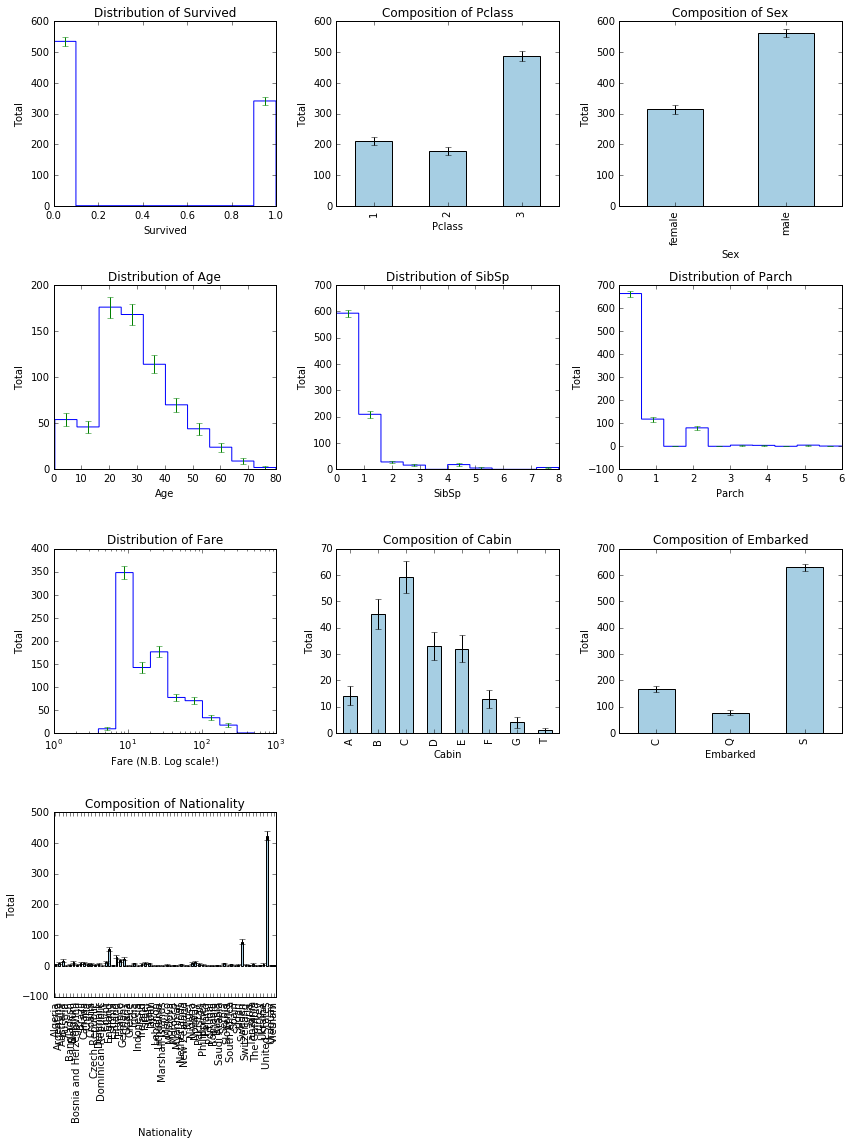

In [9]:
#================================================================================================
# USER INPUT!
# We shall now do som  global exploratory analysis on our data. We will later segment the data and
# perform an analysis on each 
# We need to know what category of data we have in each column: 
# - "C": categorical (can do =, !=)
# - "O": ordinal (can do =, !=, >, <)
# - "QC": quantative comparison (zero unimportant, e.g. time stamps) (can do =, !=, >, <, +, -)
# - "QA": quantative absolute (zero important, e.g. length) (can do =, !=, >, <, +, -, * , /)
# This information will be in the form of a dictionary, for each data table

datacategories = [ # we put "Survived" as "QA" because we interpret it as a survival probability
    {'Survived': "QA", 'Pclass': "O", 'Name': "C", 'Sex': "C", 
     'Age': "QA", 'SibSp': "QA", 'Parch': "QA", 'Ticket': "C", 
     'Fare': "QA", 'Cabin': "C", 'Embarked': "C", 'Nationality': "C"}
]

# It is useless to find the copmosition of certain columns, since they are nearly all different
# and are hence more similar to a unique identifier
uselesscolumns = [
    ["Name", "Ticket"]
]

# In each column, some entries are unknown and have been filled by by e.g. "X". We would
# like to remove these when looking at the compositions. You might need to look in the 
# CleaningNotebook to find out what the unknown entries are called
unknowns = [
    {"Survived": -1, "Pclass": -1,"Name": "Unknown name", "Sex": "Unspecified", 
     "Ticket": "XXXXXX", "Cabin": "X", "Embarked": "X", 
     "Age": alldataframes[0]["Age"][abs(alldataframes[0]["Age"] - alldataframes[0]["Age"].mean()) < 0.2].unique()[0],
     "Nationality": "Unknown"}
]

#================================================================================================

# FROM HERE ON IT'S AUTOMATIC
# We'll first do some descriptive work on our data: for "C" and "O", it's good to know the 
# proportions of each of the categories (and their total). For "QC" and "QA" we would like to have a 
# distribution of the data. Ideally, we would always like to see error bars on everything.

for ii in range(len(alldataframes)):
    print "ANALYZING DATAFRAME FROM " + datafilenames[ii] + ":"
    print "===================================================="
    descriptiveAnalysisGlobalSet(alldataframes[ii], datacategories[ii], uselesscolumns[ii], unknowns[ii])
    plt.show()

# Descriptive data analysis on segmented dataset

Now we'll work on segmented data. For each segment we'll plot the other features. Each time we plot a feature we also compare the result to the global data, i.e. the data from the full dataset.

### Functions for making histogram and bar plots, with their error bars, for each segment of the data

In [10]:
# Plots the distribution of the total number of occurrences of a column (called columnname), for each
# segment of a different column (called segmentationcolumn). The segmentationcolumn can be of any type,
# whereas columnname should be ordinal or categorical.
def segmentAndDrawCategoricalColumn(inputdataframe, segmentationcolumn, columnname, segmentcolnumeric=False):
    thedataframe = removeSparseColumns(inputdataframe, [columnname])
    # We'll first make a dataframe containing the barplot-information of the global data, i.e. of
    # the data on the full dataset.
    compositiondataframeglobal = turnValueAndErrorIntoFrame(getCompositionAndErrorbar(thedataframe,columnname, normalized=True))
    # We rename the columns for the global data so that column-names don't clash with other dataframes.
    compositiondataframeglobal = compositiondataframeglobal.rename(
        index=str, columns={"Mean": "Global", "StandardDeviation": "StandardDeviationGlobal"})
    # This will be the maximum yvalue on the plots (purely aesthetic)
    ymax = max(compositiondataframeglobal["Global"]+ compositiondataframeglobal["StandardDeviationGlobal"])
    # Now we'll segment the dataframe according to the column called segmentationcolumn
    segmentedframe = segmentDataFrame(thedataframe, segmentationcolumn, segmentcolnumeric)
    # For each segment of the data, we'll make a barplot of the data in columnname, and compare it with the
    # same barplot for the global data.
    # We'll put all the frames in an array of subplots, as described in the pandas documention. In
    # this case we'll draw three columns and as many rows as needed.
    numberofrows = int(np.ceil(len(segmentedframe) / 3.))
    fig, axes = plt.subplots(nrows=numberofrows, ncols=3, figsize=(12,4*numberofrows), tight_layout=True)
    # Now we'll go through the segments of the data, in each case making a dataframe containing the information
    # that needs to be passed to the barplot. We then plot the barplot alongside that of the global data,
    # placing it in the current subplot called currentax.
    for (currentax, (segmentvalue,subframe)) in zip(axes.ravel(), segmentedframe):
        # First we get a dictionary containing the barplot data, i.e. the totals plus error bars
        totalsanderrors = getCompositionAndErrorbar(subframe.drop(segmentationcolumn, 1),columnname, normalized=True)
        # Then we turn it into a dataframe which is easily plotted with pandas
        compositiondataframesegment = turnValueAndErrorIntoFrame(totalsanderrors)
        # We might need to update our ymax
        possiblenewmax = max(compositiondataframesegment["Mean"] + compositiondataframesegment["StandardDeviation"] )
        if possiblenewmax > ymax:
            ymax = possiblenewmax
        # Since the name of the column will appear on the plot, we rename it to something less generic
        compositiondataframesegment = compositiondataframesegment.rename(index=str, columns={"Mean": "Segment"})
        # Now we'll put together the frame containing the segmented data and the frame containing the global data
        frametoplot = pd.concat([compositiondataframesegment, compositiondataframeglobal], axis=1).fillna(0)
        # We also get the error bars of each barplot
        errorbarsofplot = [frametoplot["StandardDeviation"], frametoplot["StandardDeviationGlobal"]]
        # This plots the barplot using the data in the dataframe and the errorbars we give it. This 
        # plot is placed in the currentax place of the subplots
        frametoplot[["Segment","Global"]].plot.bar(yerr=errorbarsofplot, ax=currentax, color=brewerColors())
        currentax.set_title(segmentationcolumn + " = " + str(segmentvalue))
        currentax.set_xlabel(columnname)
        currentax.set_ylabel("Percentage")
    # Finally, we resize the yaxis of all plots so that they look nicer
    ymax = ymax*1.1
    for currentax in axes.ravel():
        currentax.set_ylim([0,ymax])
    # We also remove those plots that have nothing in them
    for remainingax in axes.ravel()[len(segmentedframe):]:
        remainingax.axis("off")
        
def segmentAndDrawQuantitativeColumn(thedataframe, segmentationcolumn, columnname, segmentcolnumeric=False):
    logscale = isLogScaleNeeded(thedataframe[columnname])
    # We'll first make the error bars of the histogram of the global data, i.e. of the data on the full dataset.
    (histerrorbarsglobal, bins) = getHistogramErrorbar(thedataframe,columnname, normalized=True, log=logscale)
    # This will be the maximum yvalue on the plots (purely aesthetic)
    ymax = 0
    # Now we'll segment the dataframe according to the column called segmentationcolumn
    segmentedframe = segmentDataFrame(thedataframe, segmentationcolumn, segmentcolnumeric)
    # For each segment of the data, we'll make a histogram of the data in columnname, and compare it with the
    # same histogram for the global data.
    # We'll put all the frames in an array of subplots, as described in the pandas documention. In
    # this case we'll draw three columns and as many rows as needed.
    numberofrows = int(np.ceil(len(segmentedframe) / 3.))
    fig, axes = plt.subplots(nrows=numberofrows, ncols=3, figsize=(12,4*numberofrows), tight_layout=True)
    # Now we'll go through the segments of the data, in each case placing both histograms in the same figure
    for (currentax, (segmentvalue,subframe)) in zip(axes.ravel(), segmentedframe):
        # First we place the histogram of the global data in the figure
        (nglobal, binsglobal, _) = currentax.hist(thedataframe[columnname], bins=bins, histtype = 'stepfilled', 
                                                  alpha=0.3, normed=True, edgecolor="none", color="r", label="Global")
        # Now we place the error bars of the global data
        midglobal = midPointsOfBins(binsglobal, log=logscale) 
        currentax.errorbar(midglobal, nglobal, yerr=histerrorbarsglobal, fmt='none', ecolor="r")
        # We might need to update our ymax
        possiblenewmax = max(nglobal)
        if possiblenewmax > ymax:
            ymax = possiblenewmax
        # Now we draw the histogram of the segment of the data, with its error bars
        (histerrorbarssegment, bins) = getHistogramErrorbar(subframe.drop(segmentationcolumn, 1),columnname, 
                                                            normalized=True, inputbins=binsglobal, log=logscale)
        (nsegment, binssegment, _) = currentax.hist(subframe.drop(segmentationcolumn, 1)[columnname], 
                                                    bins=bins, histtype = 'stepfilled', alpha=0.3, normed=True, 
                                                    edgecolor="none", color="b", label="Segment")
        # We might need to update our ymax
        possiblenewmax = max(nsegment)
        if possiblenewmax > ymax:
            ymax = possiblenewmax
        midsegment = midPointsOfBins(binssegment, log=logscale) 
        currentax.errorbar(midsegment, nsegment, yerr=histerrorbarssegment, fmt='none', ecolor="b")
        # We are done. We just need a few labels
        currentax.set_title(segmentationcolumn + " = " + str(segmentvalue))
        if logscale:
            currentax.set_xscale("log")
            currentax.set_xlabel(columnname + " (N.B. Log scale!)")
        else:
            currentax.set_xlabel(columnname)
        currentax.set_ylabel("Percentage")
        currentax.legend()
    # Finally, we resize the yaxis of all plots so that they look nicer
    ymax = ymax*1.1
    for currentax in axes.ravel():
        currentax.set_ylim([0,ymax])
    # We also remove those plots that have nothing in them
    for remainingax in axes.ravel()[len(segmentedframe):]:
        remainingax.axis("off")
        
# This high-level function goes through the columns of the dataframe, and if the column is not "useless" it will segment
# it (datacateg lets you know what type of data is in the column, and dictofunknown lets you know which rows were)
# automatically filled in and should hence be removed. For each segment, histograms and distributions of all other
# columns are computed.
def drawComparisonData(inputdataframe, datacateg, uselesscols, dictofunknown):
    for segmentationcolumn in inputdataframe:
        dataframetouse = inputdataframe
        proceedwithdrawing = False
        if (datacateg[segmentationcolumn]=="C" or datacateg[segmentationcolumn]=="O") \
        and (segmentationcolumn not in uselesscols):
            segmentcolnumeric = False
            proceedwithdrawing = True
        elif (datacateg[segmentationcolumn]=="QA" or datacateg[segmentationcolumn]=="QC") \
        and (segmentationcolumn not in uselesscols):
            segmentcolnumeric = True
            proceedwithdrawing = True       
        if proceedwithdrawing==True:    
            for columnname in dataframetouse:
                if (datacateg[columnname]=="C" or datacateg[columnname]=="O") \
                and (columnname not in uselesscols) and columnname!=segmentationcolumn:
                    segmentAndDrawCategoricalColumn(
                        removeAutogeneratedData(dataframetouse,[columnname,segmentationcolumn],dictofunknown), 
                        segmentationcolumn, columnname, segmentcolnumeric=segmentcolnumeric)
                if (datacateg[columnname]=="QA" or datacateg[columnname]=="QC") \
                and (columnname not in uselesscols) and columnname!=segmentationcolumn:
                    segmentAndDrawQuantitativeColumn(
                        removeAutogeneratedData(dataframetouse,[columnname,segmentationcolumn],dictofunknown), 
                        segmentationcolumn,columnname, segmentcolnumeric=segmentcolnumeric)

#### Helper functions for segmented data plots

In [11]:
# Performs a groupby operation on a given column, here called "segmentationcolumn". If the column is numeric
# the groupby happens on bins of the data, which may be logarithmic (only those bins containing data are kept). 
def segmentDataFrame(thedataframe, segmentationcolumn, segmentcolnumeric):
    if segmentcolnumeric==True:
        logscale = isLogScaleNeeded(thedataframe[segmentationcolumn])
        if logscale==True:
            bins = np.logspace(np.log10(min(thedataframe[segmentationcolumn])),
                                     np.log10(max(thedataframe[segmentationcolumn])),10)
        else:
            bins = np.histogram(thedataframe[segmentationcolumn])[1]
        # shift the last bin by 1% further away so as to include the endpoint 
        # (unfortunately pd.cut has no in-built way of doing it when right==True because there is no option
        # include_highest)
        bins[-1] = 1.01*bins[-1] - 0.01*bins[-2]
        datainbins = pd.cut(thedataframe[segmentationcolumn], bins, right=False)
        datainbins = datainbins.cat.remove_unused_categories()
        segmentedframe = thedataframe.groupby(datainbins)
    else:
        touseframe = removeSparseColumns(thedataframe, [segmentationcolumn])
        segmentedframe = touseframe.groupby(segmentationcolumn)
    return segmentedframe

### Plot the comparisons for all segments of all features

Many of the drawn plots will be uninteresting, but to fully appreciate the data it's important to go through all the figures. 

ANALYZING DATAFRAME FROM natinalitycleantrain.csv:


C:\Users\Daniele\Anaconda2\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


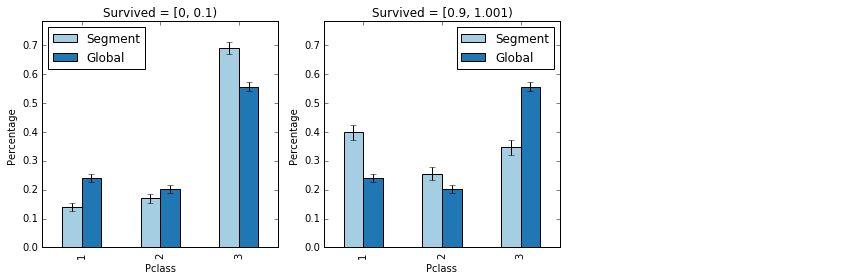

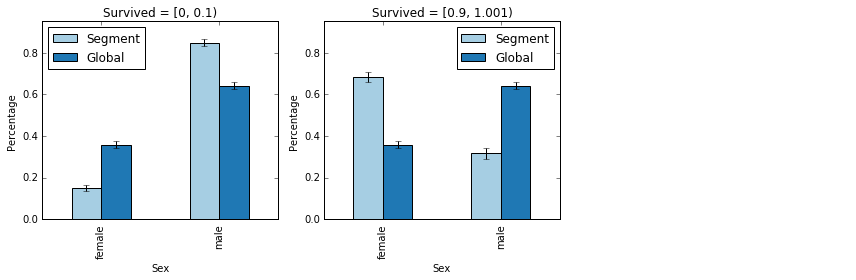

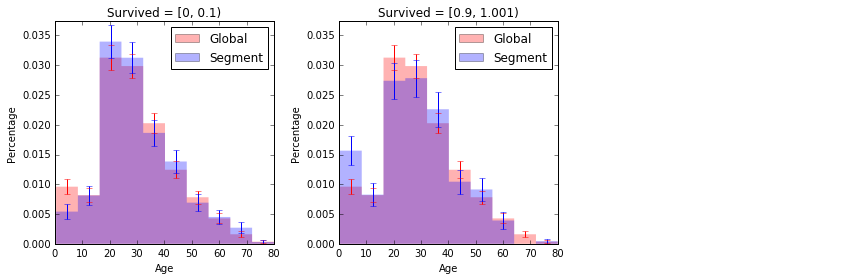

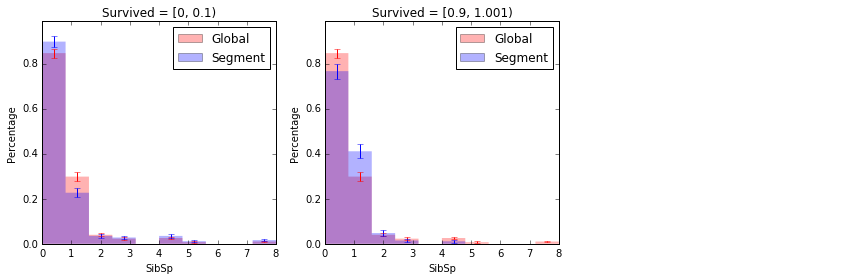

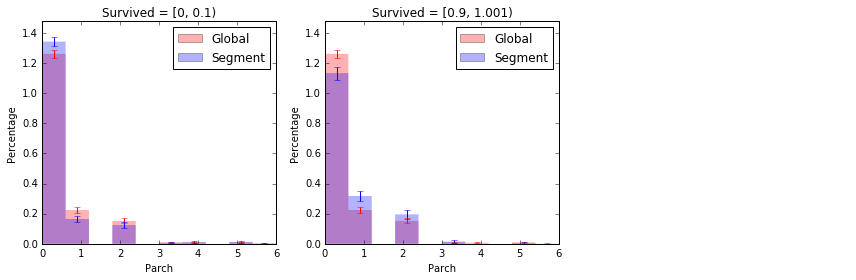

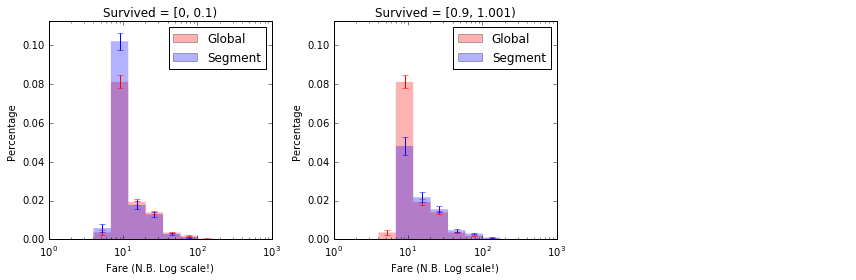

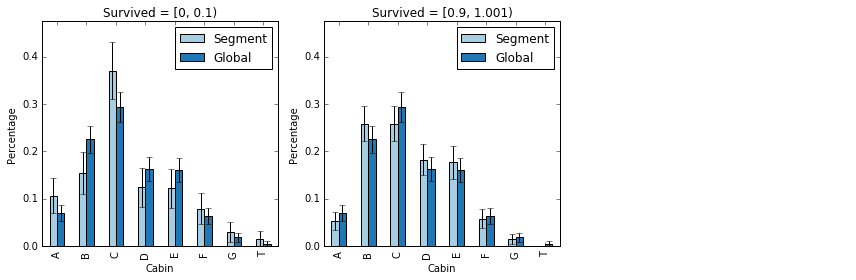

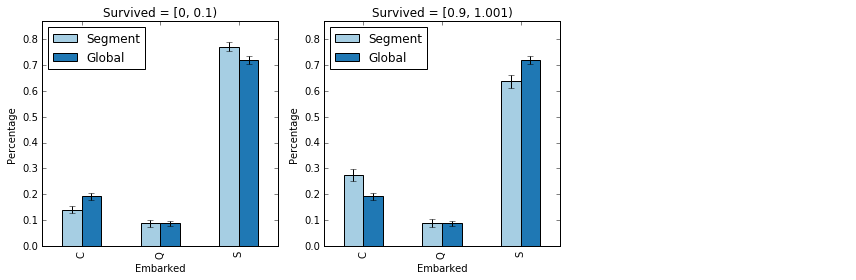

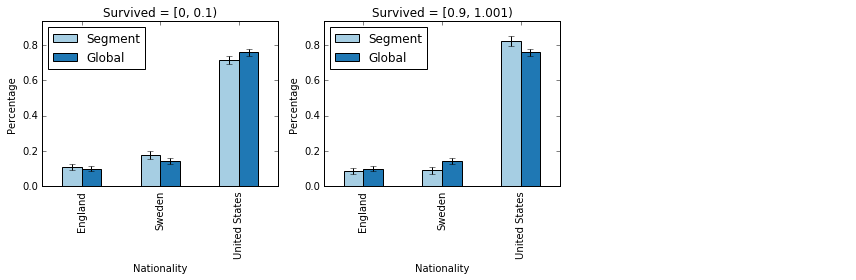

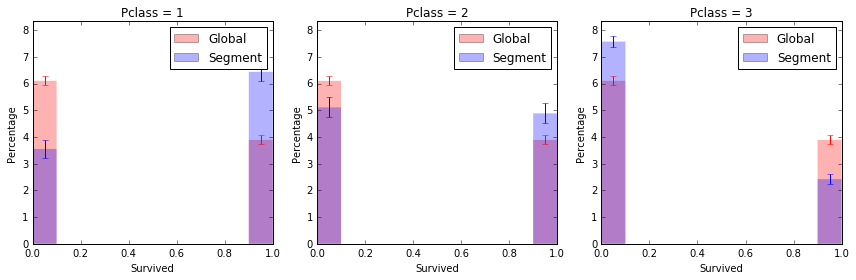

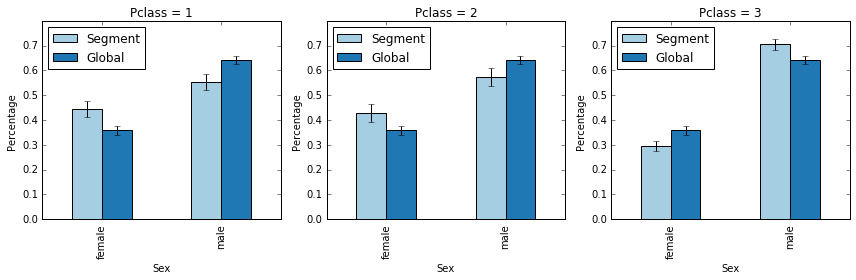

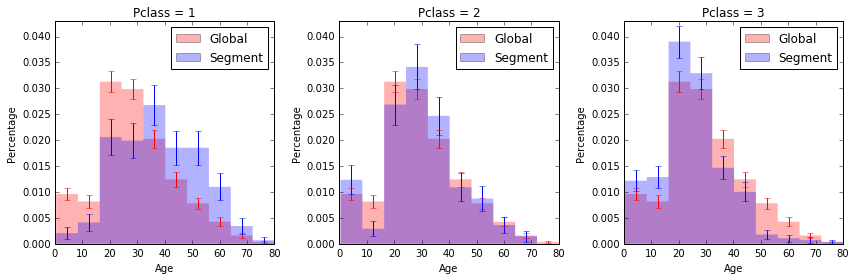

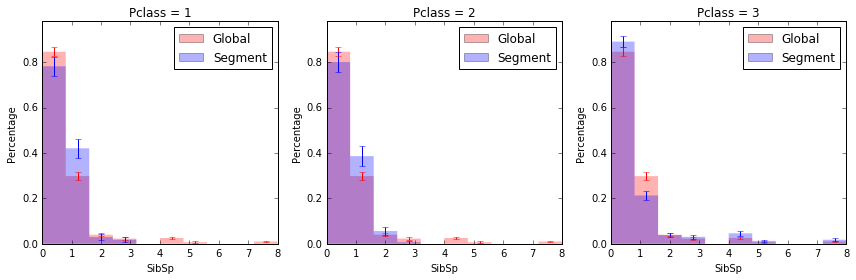

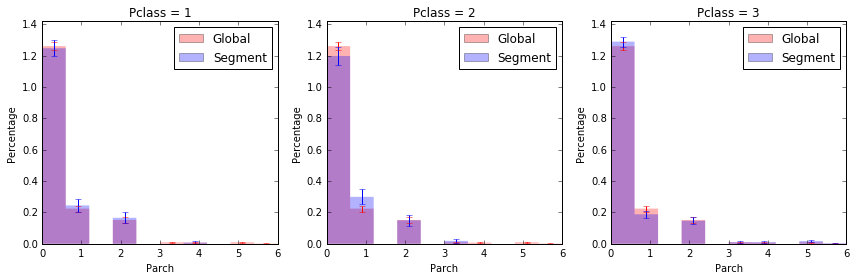

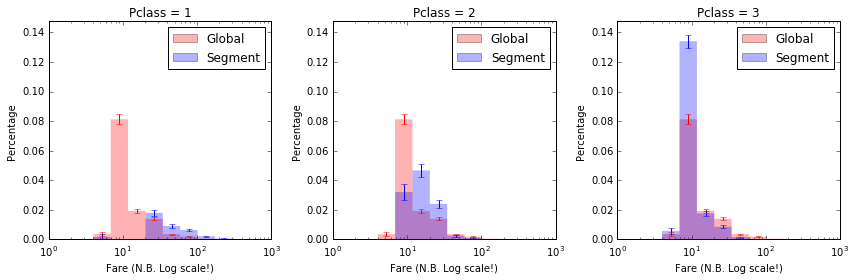

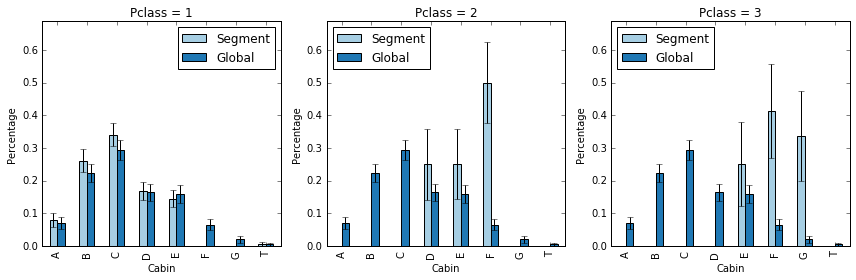

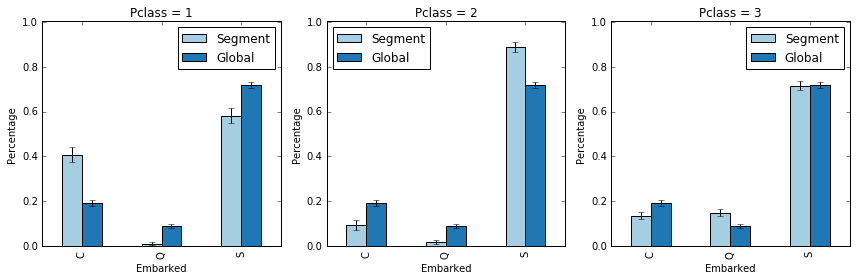

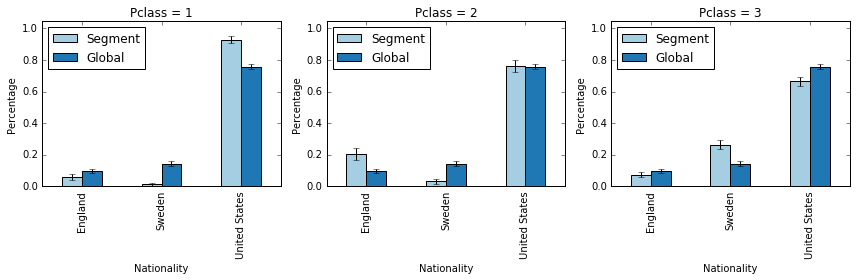

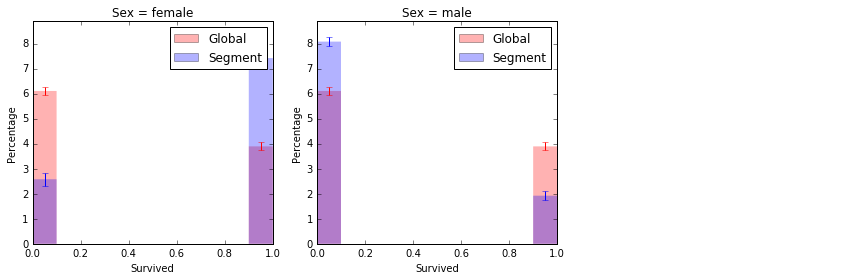

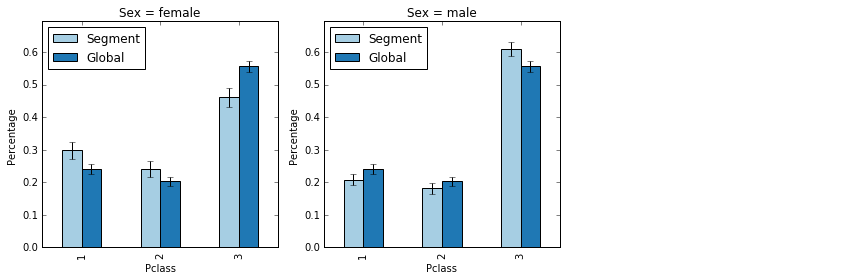

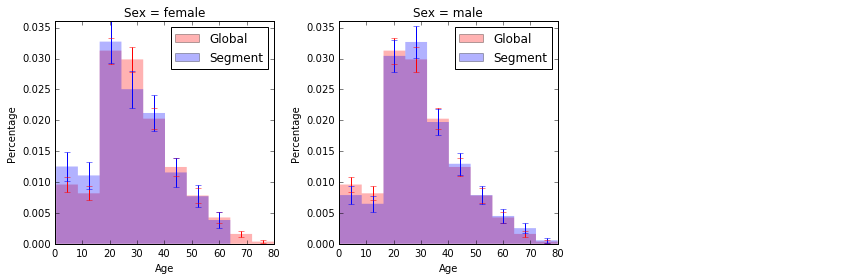

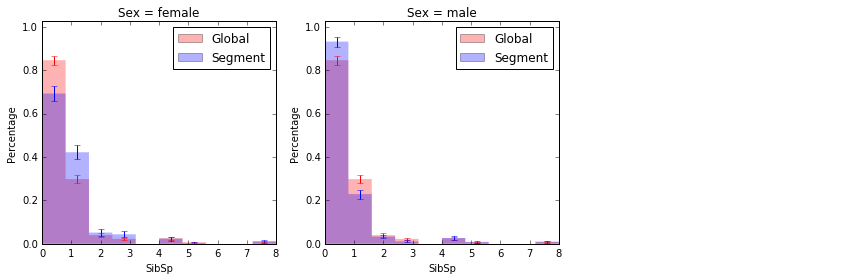

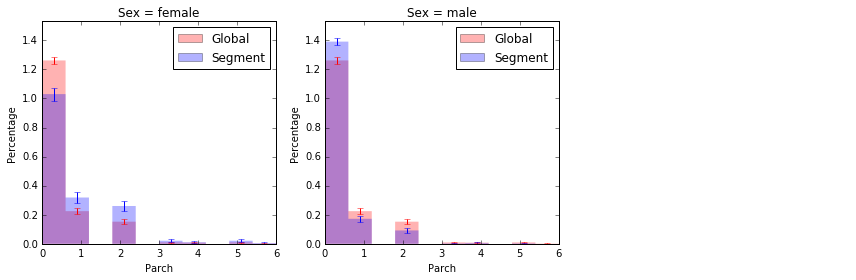

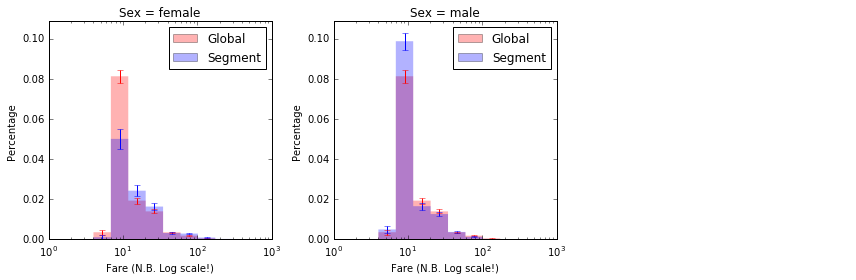

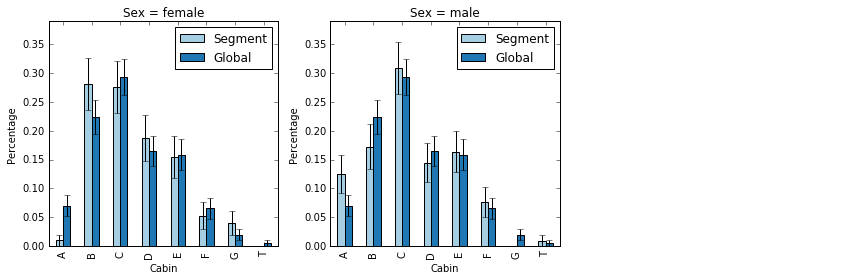

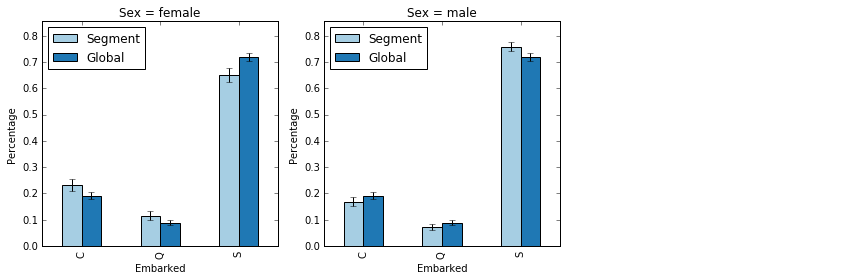

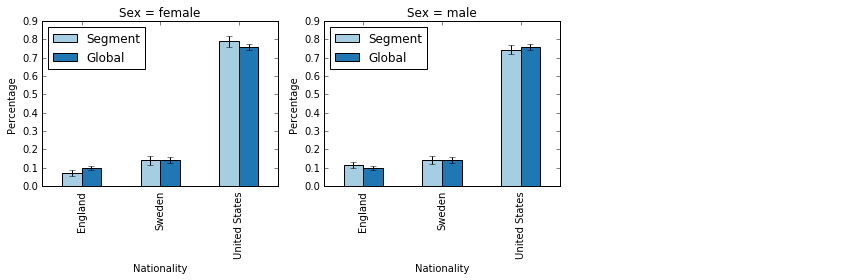

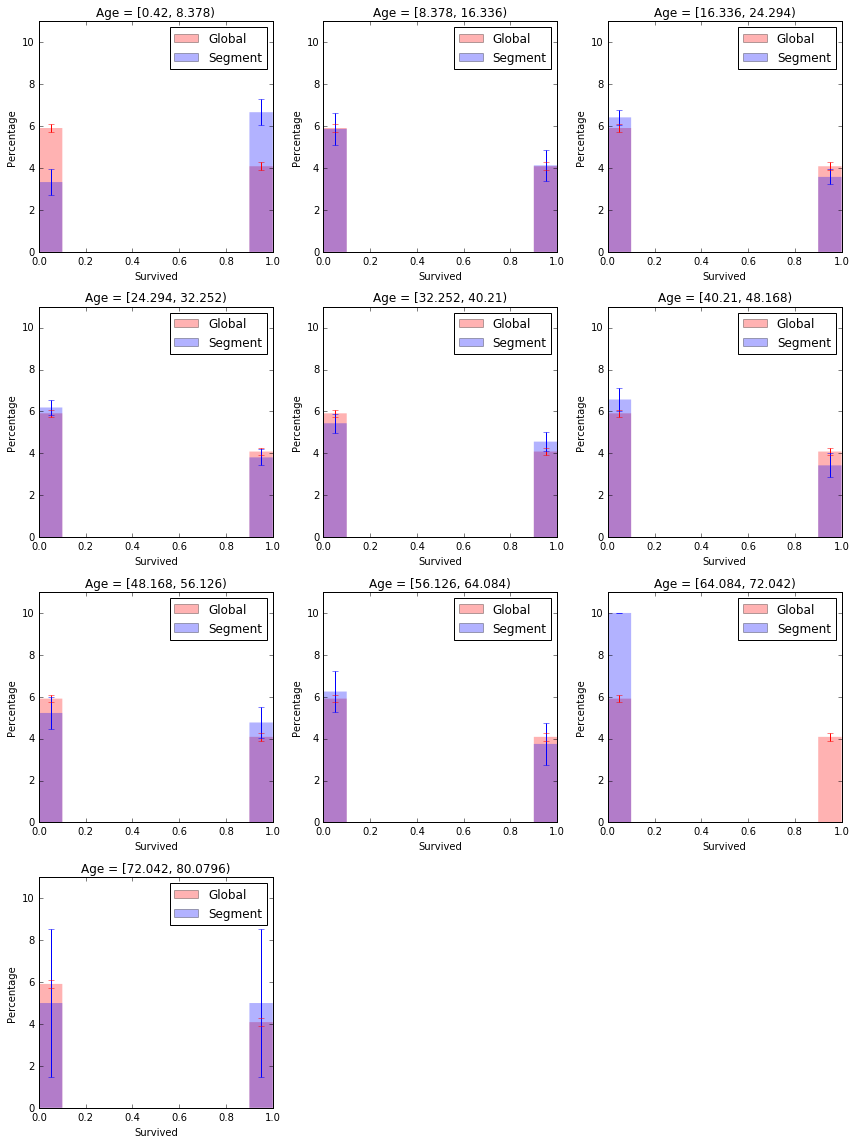

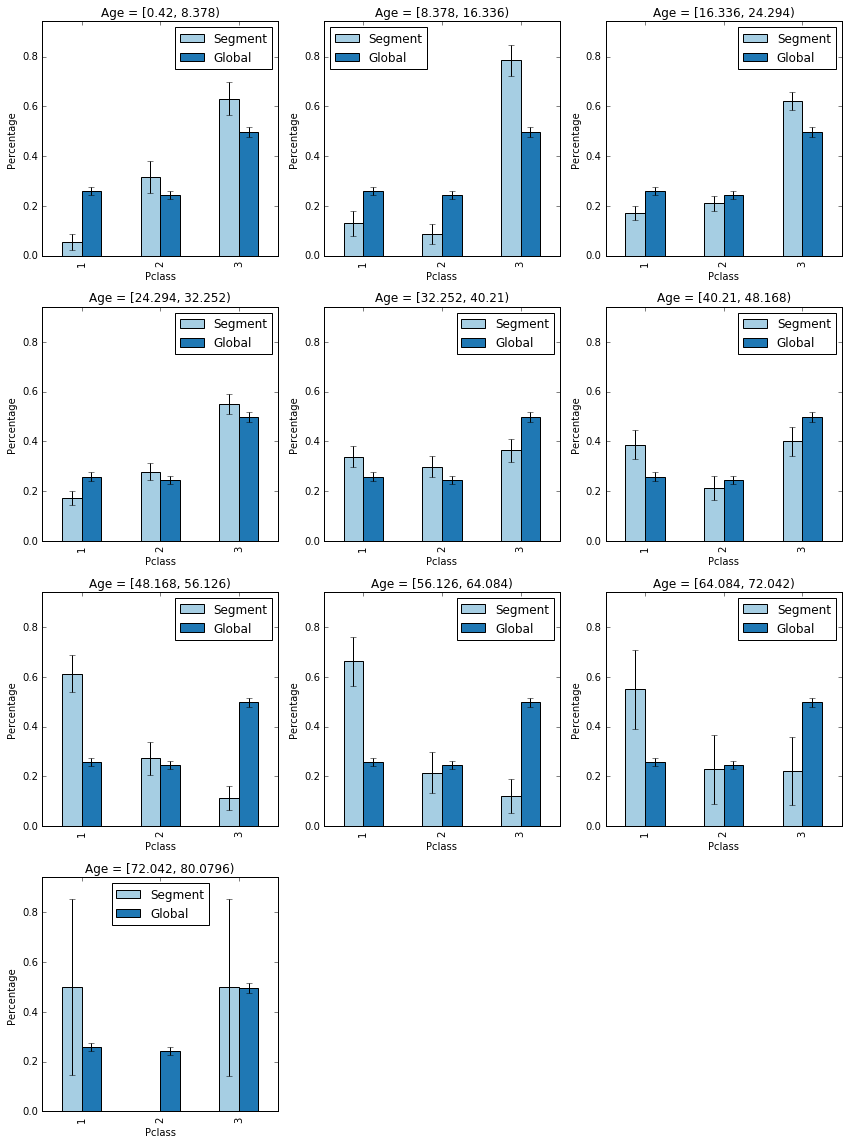

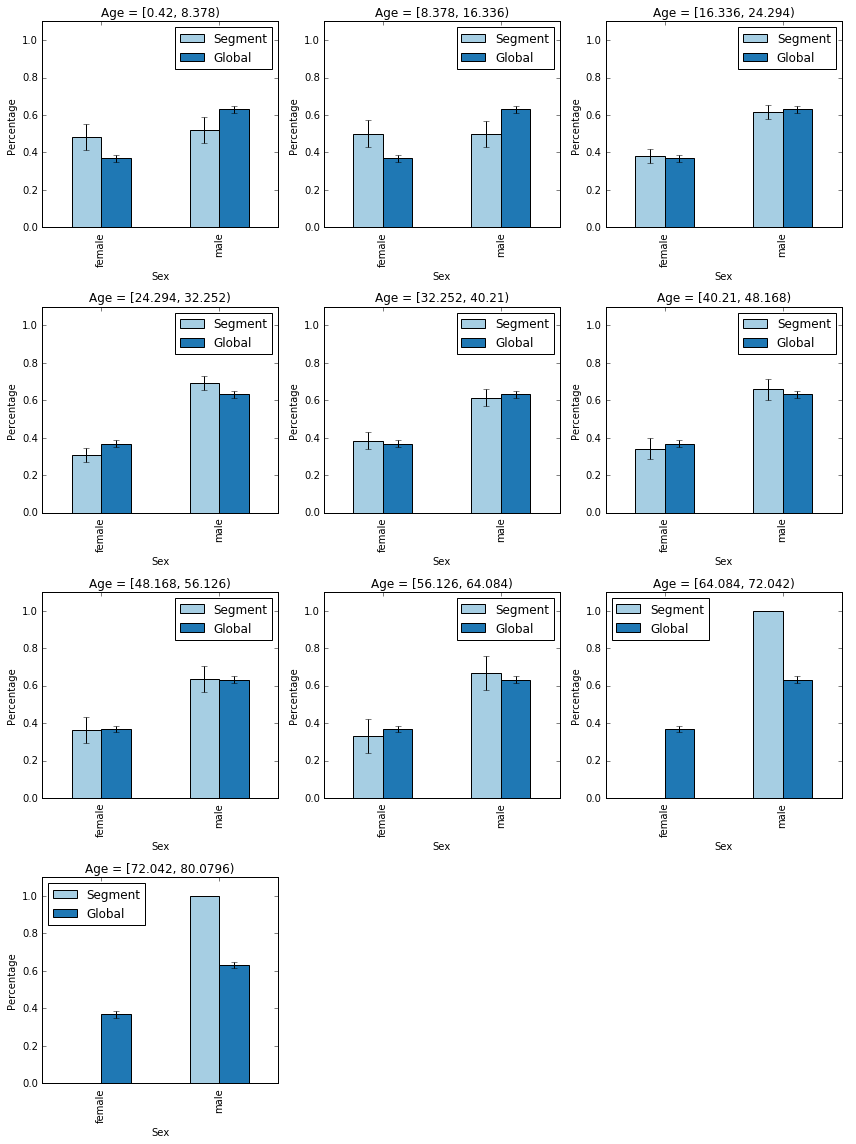

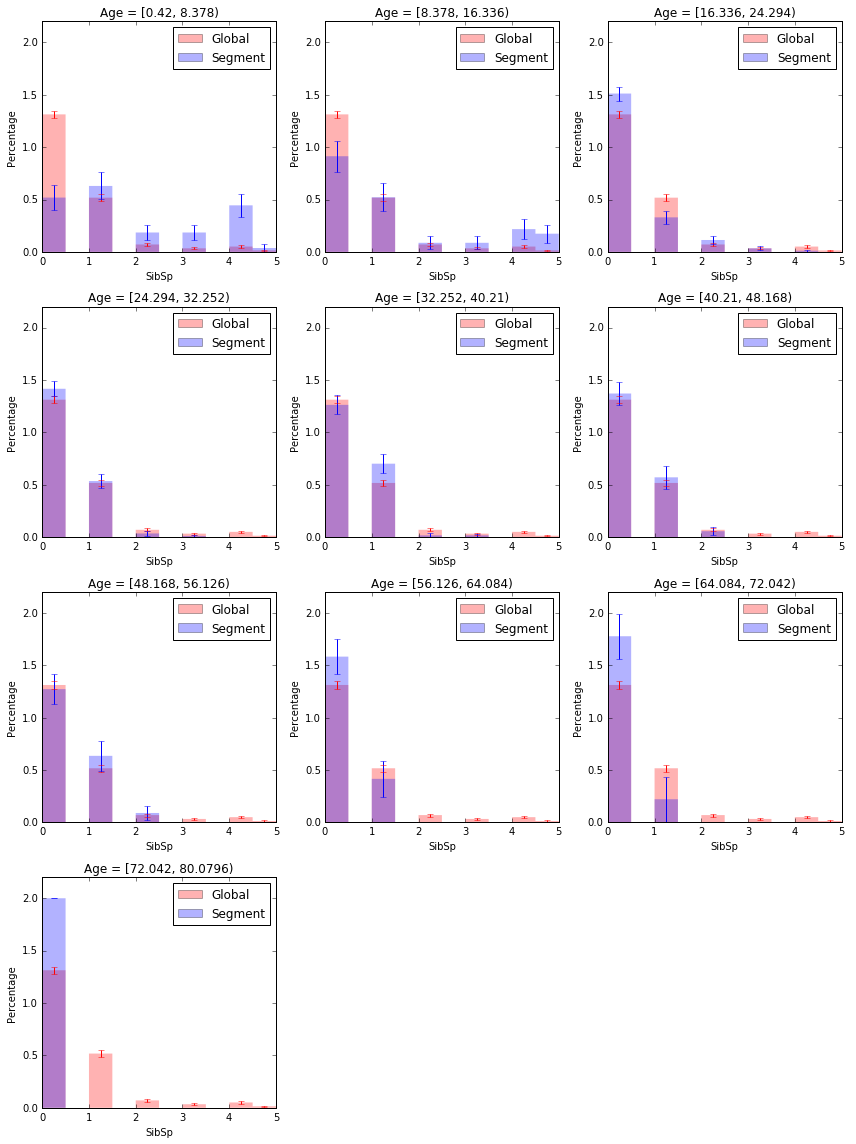

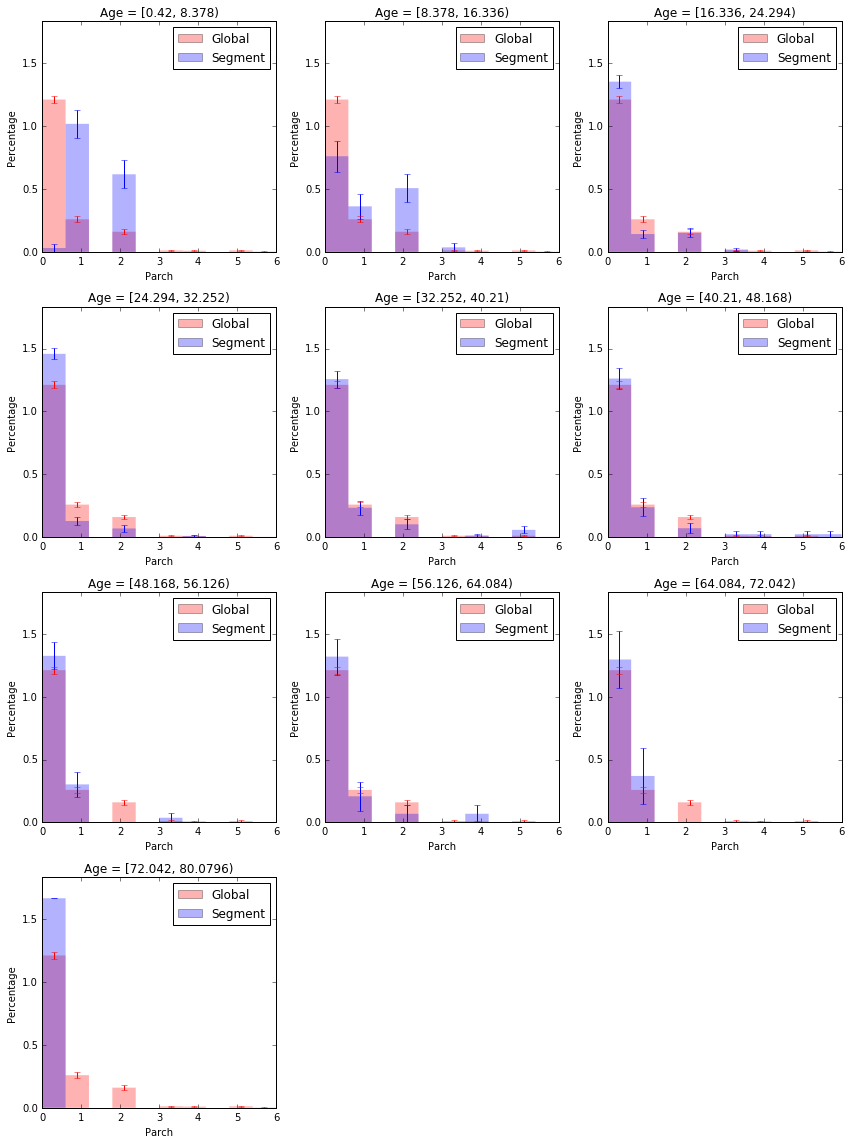

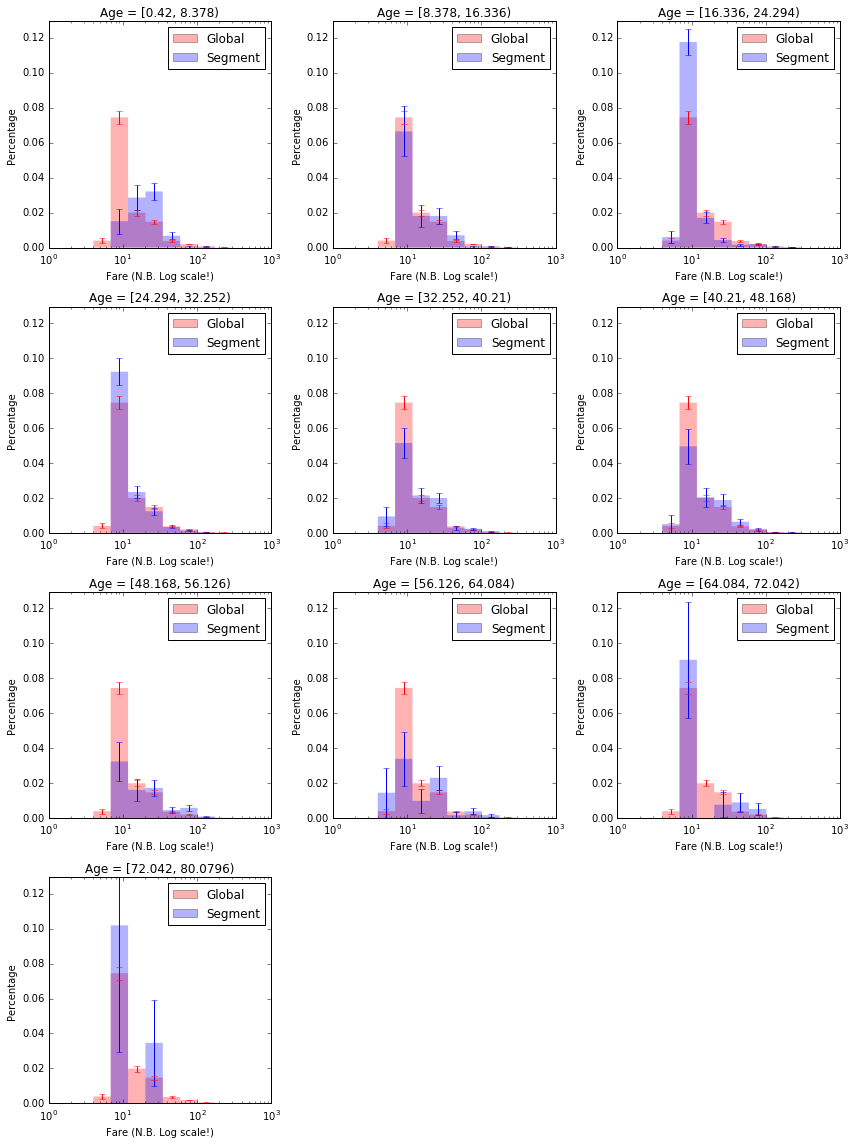

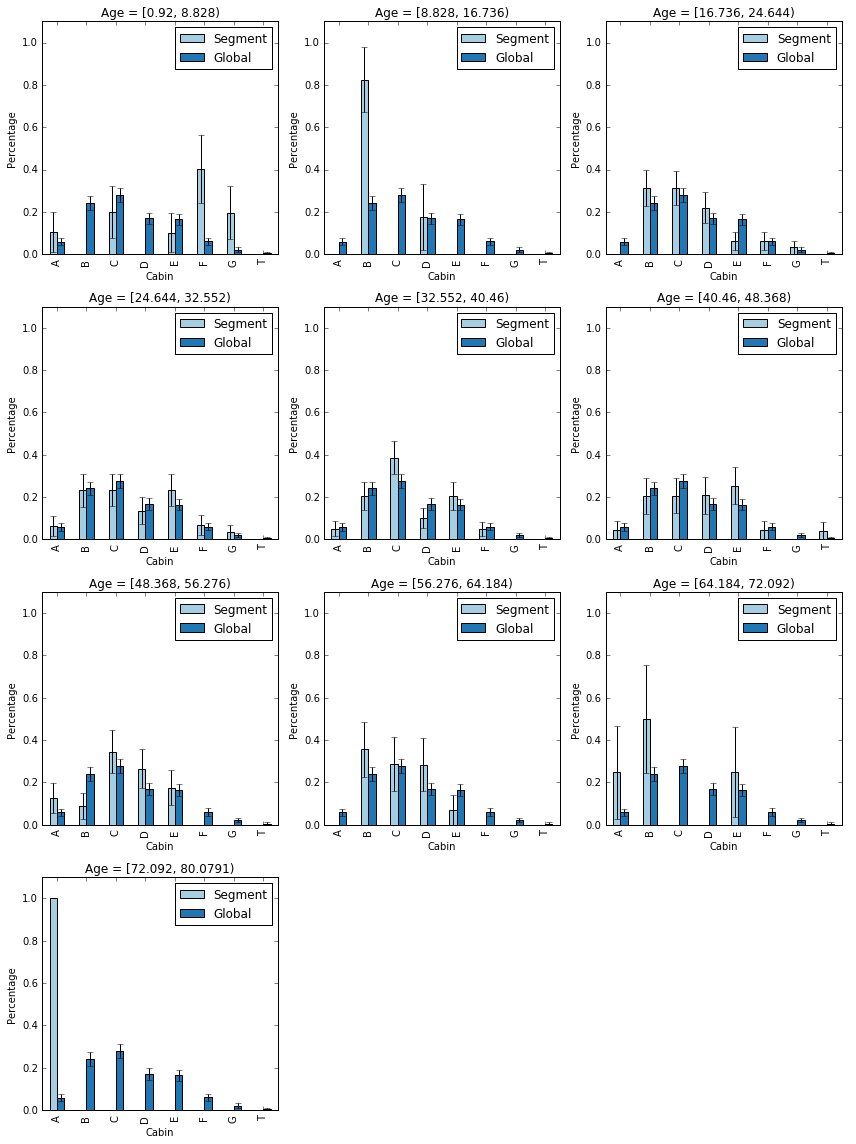

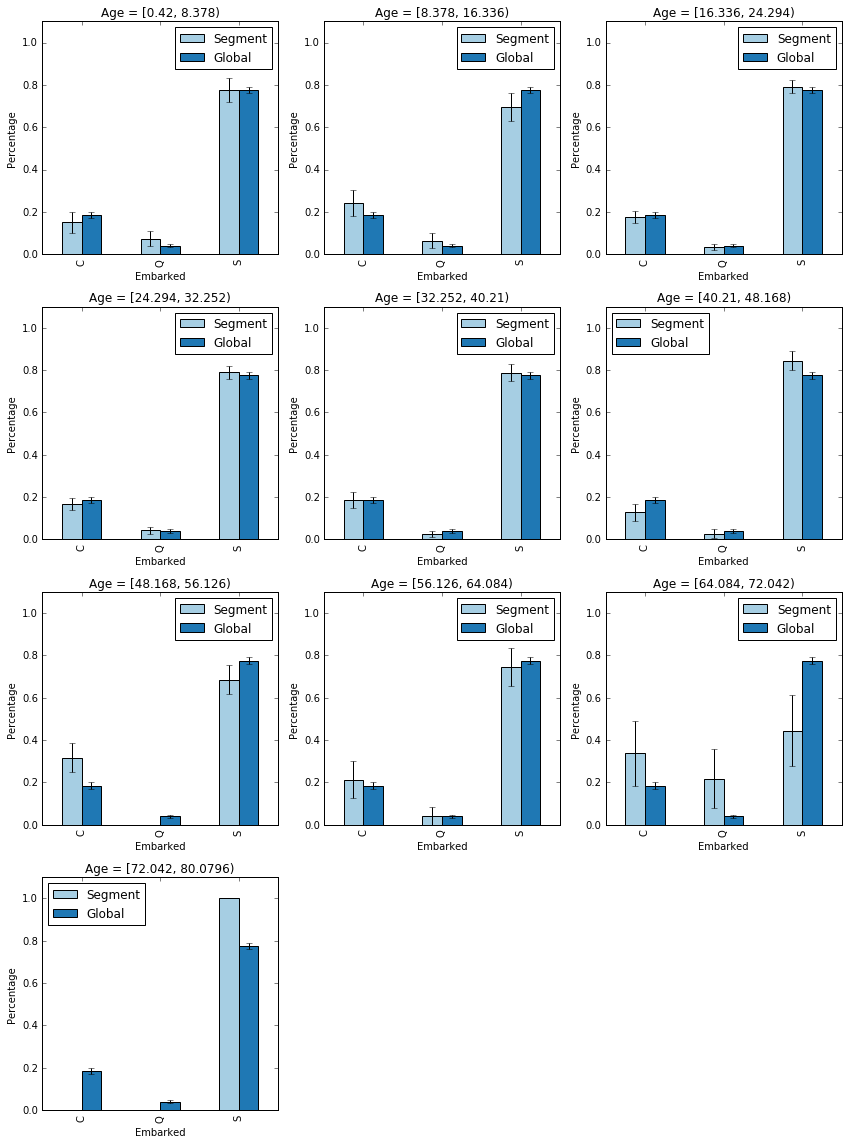

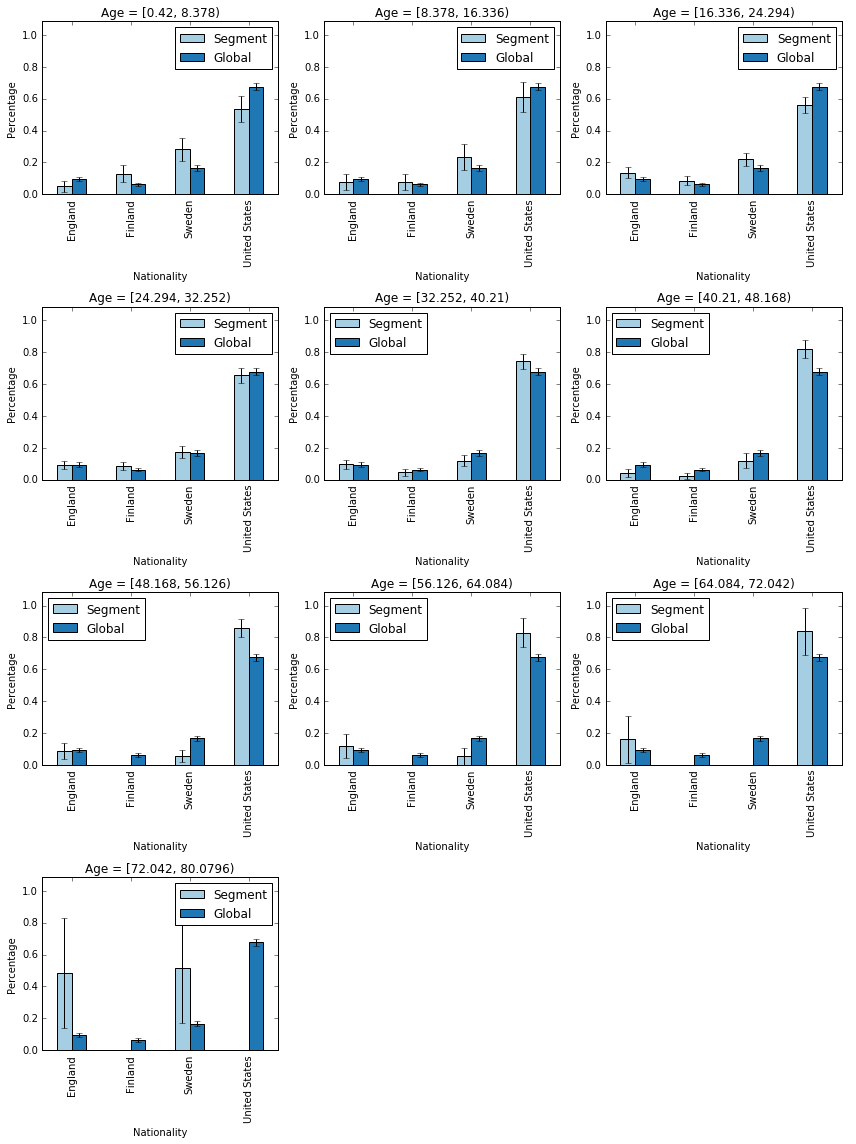

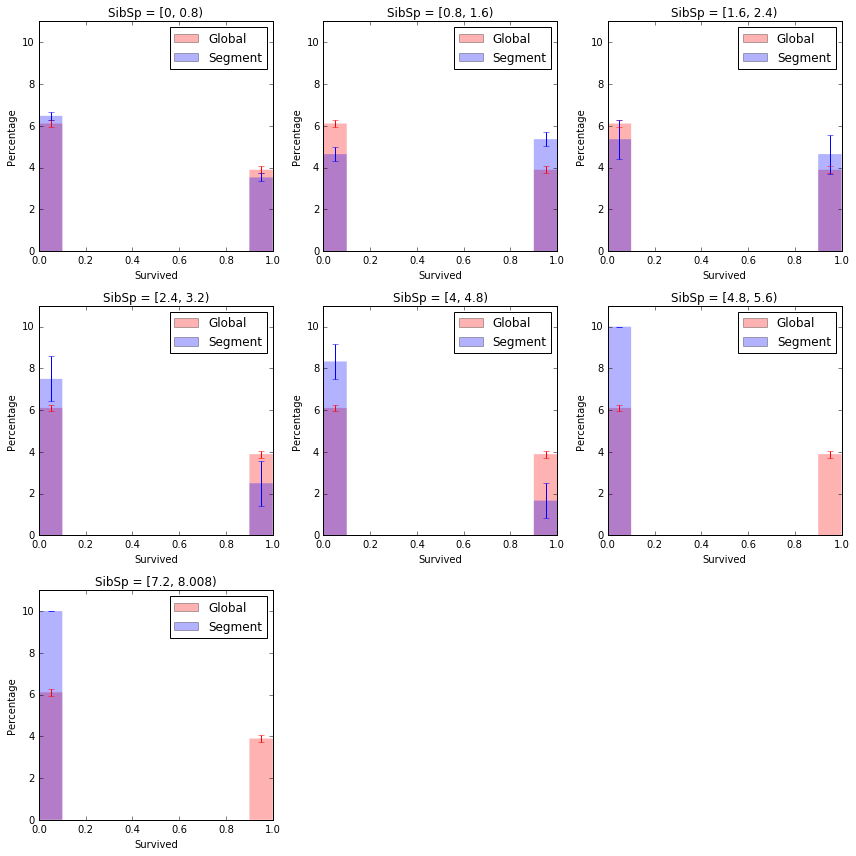

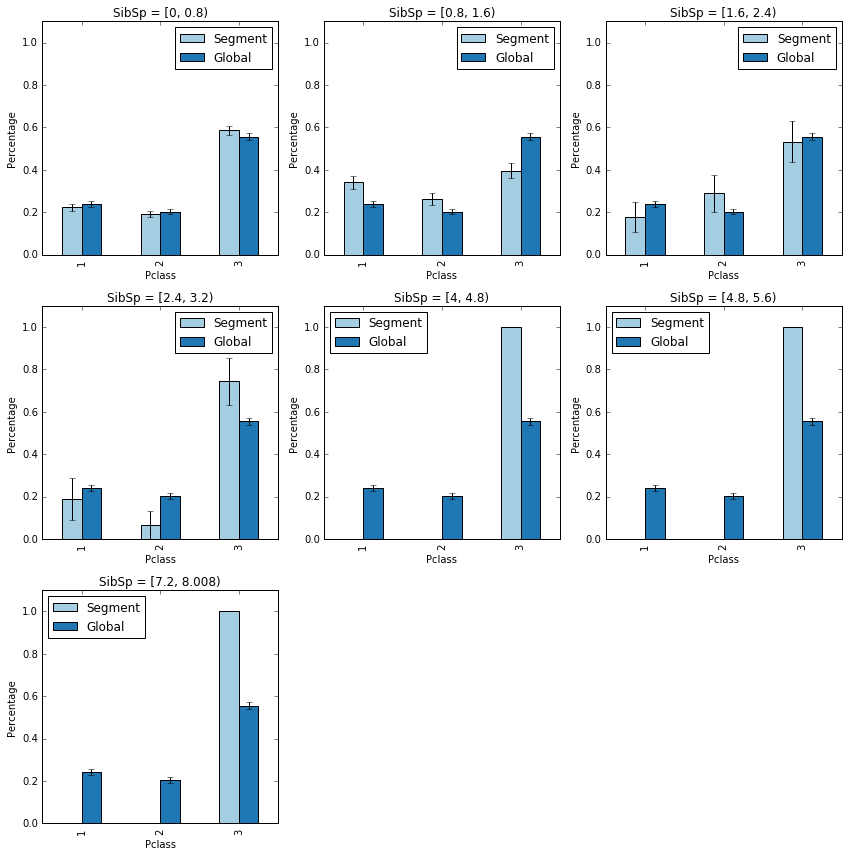

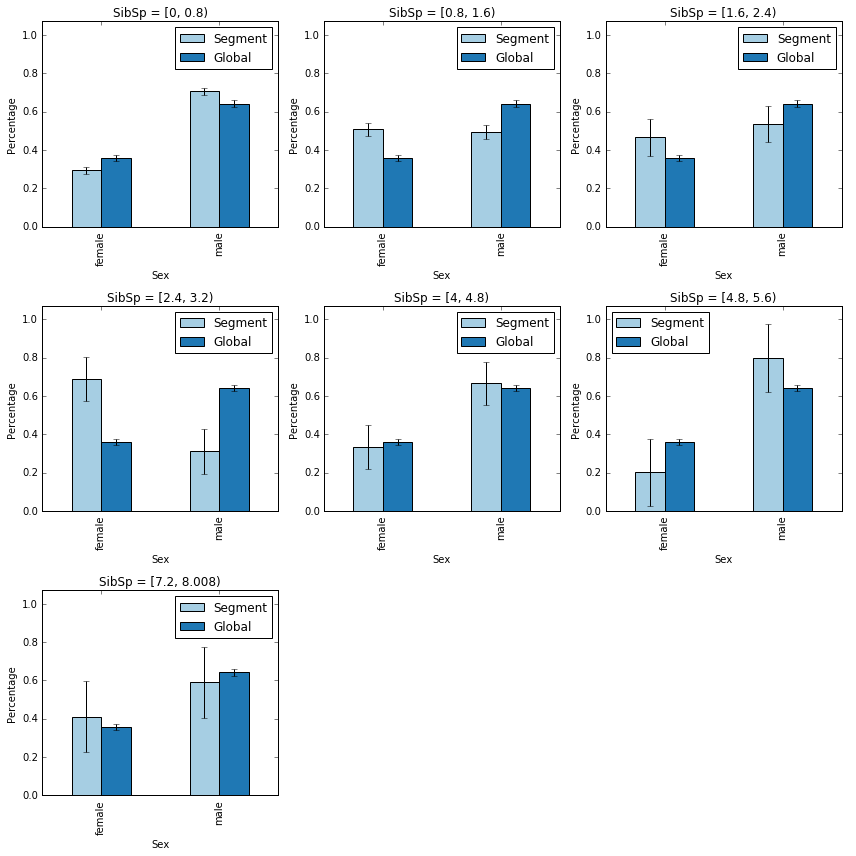

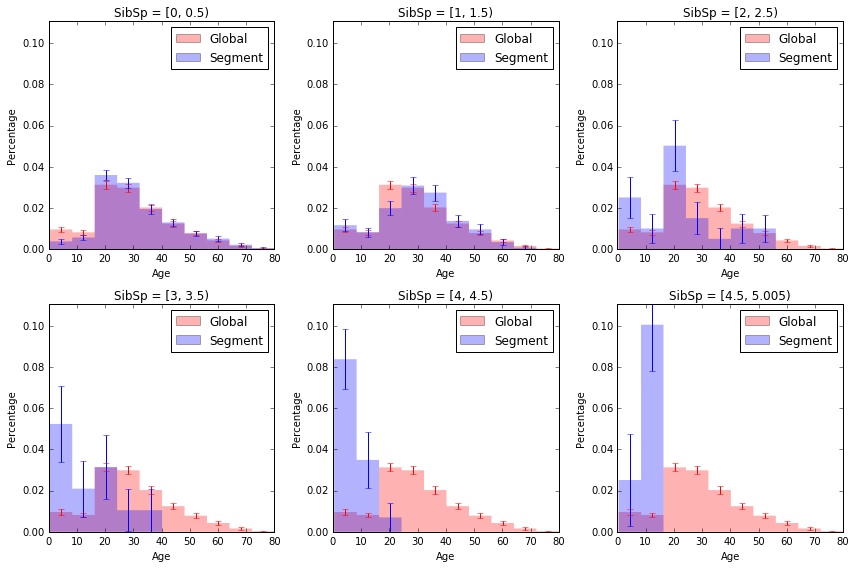

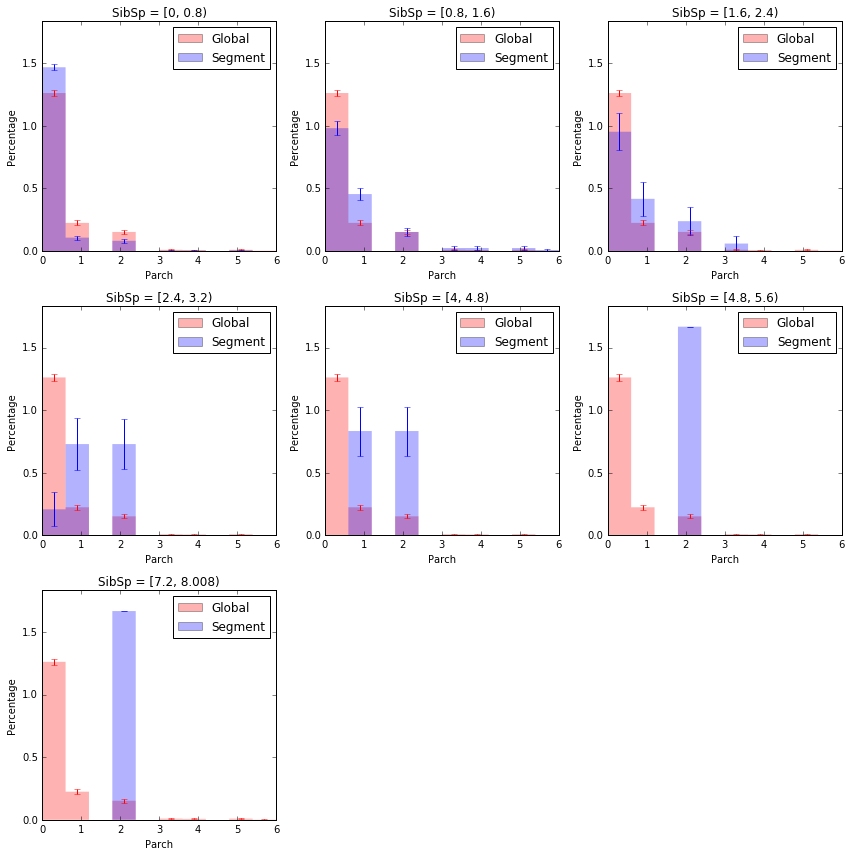

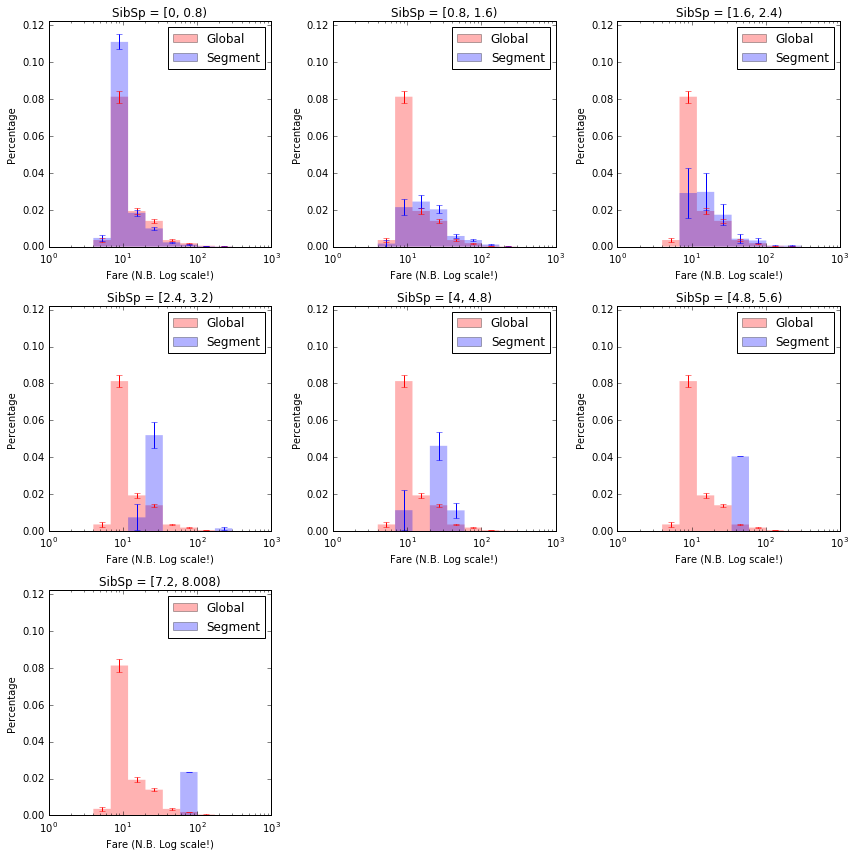

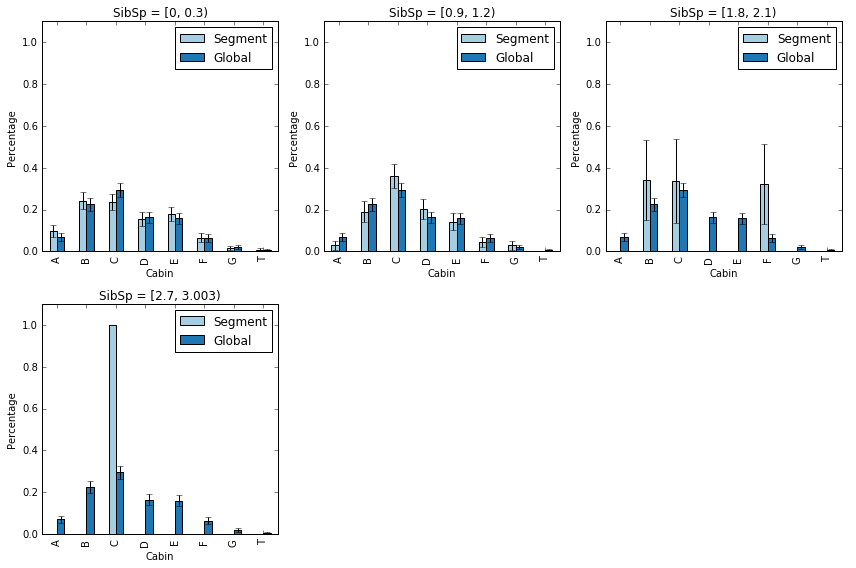

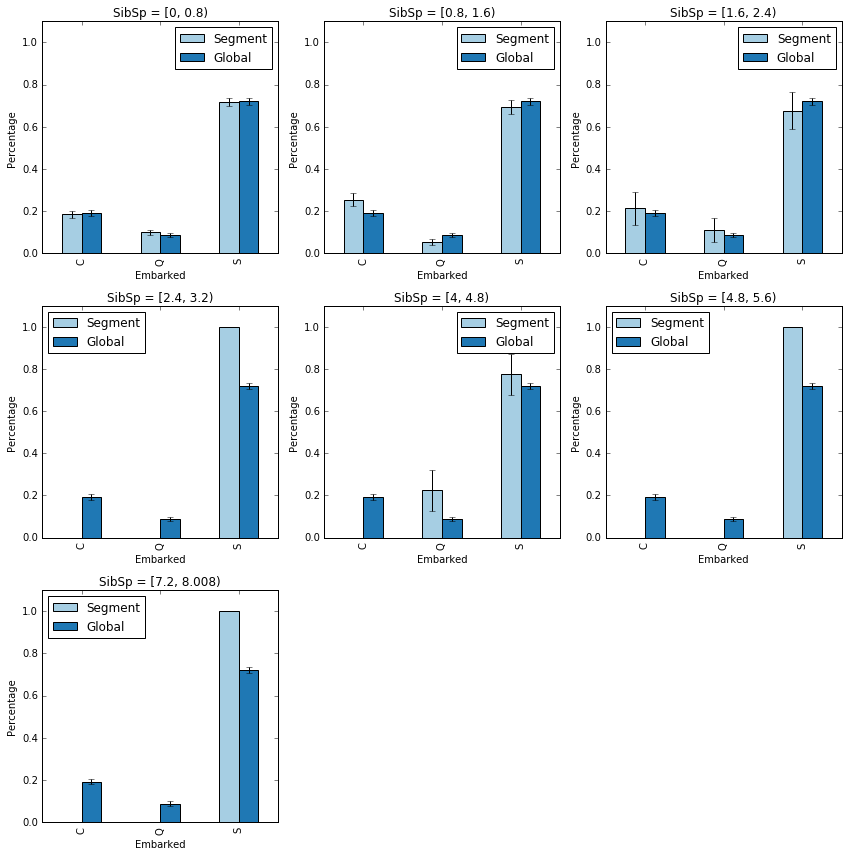

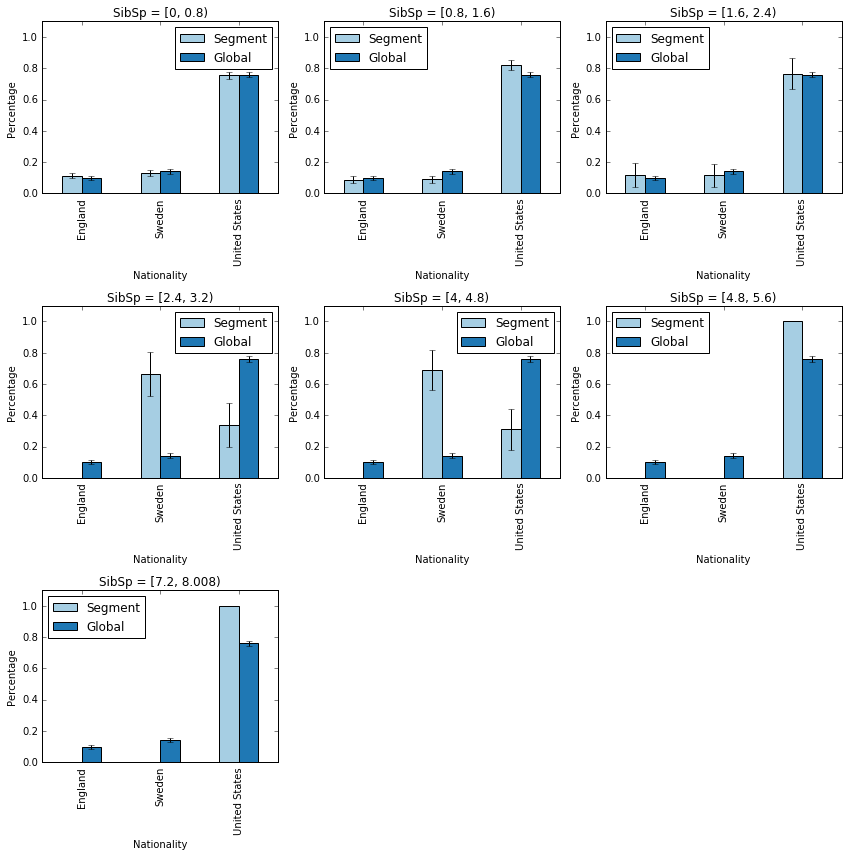

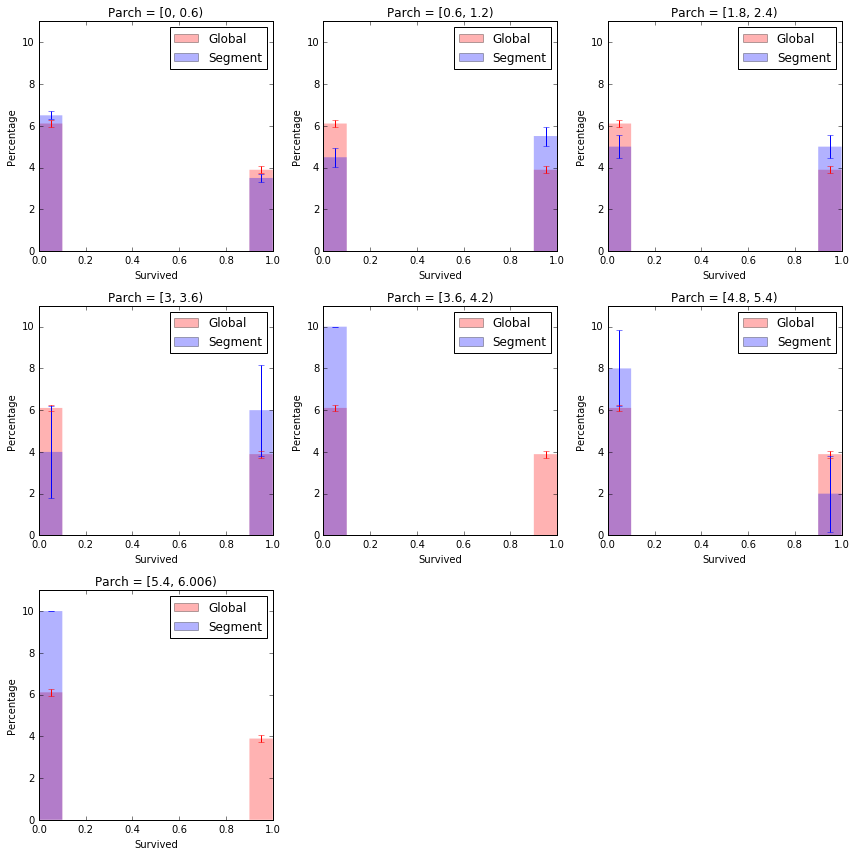

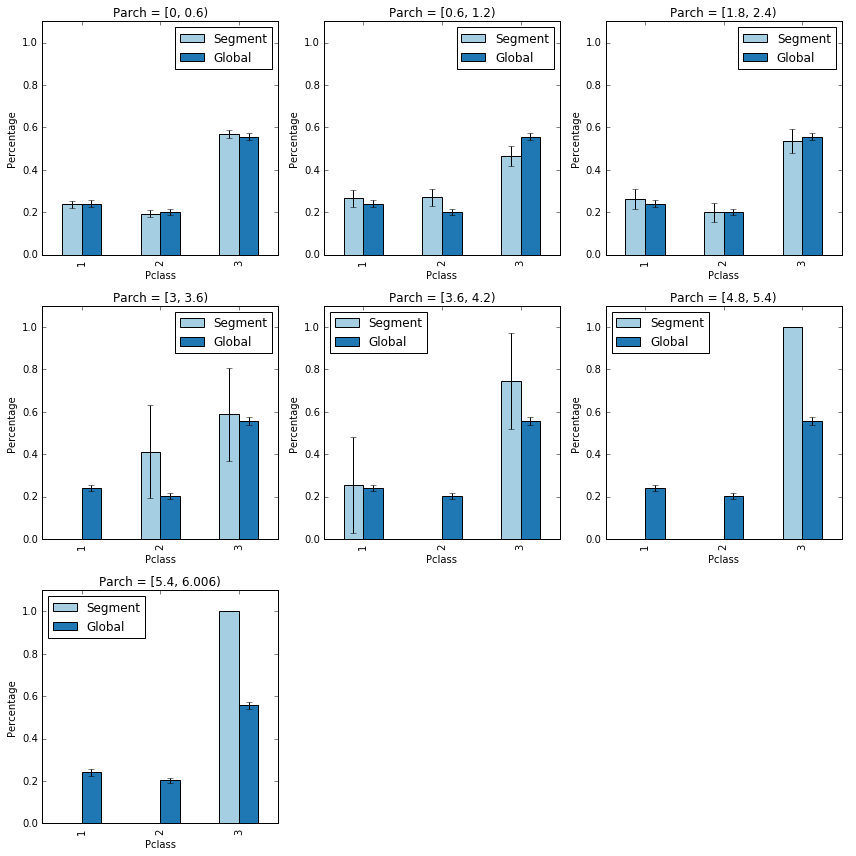

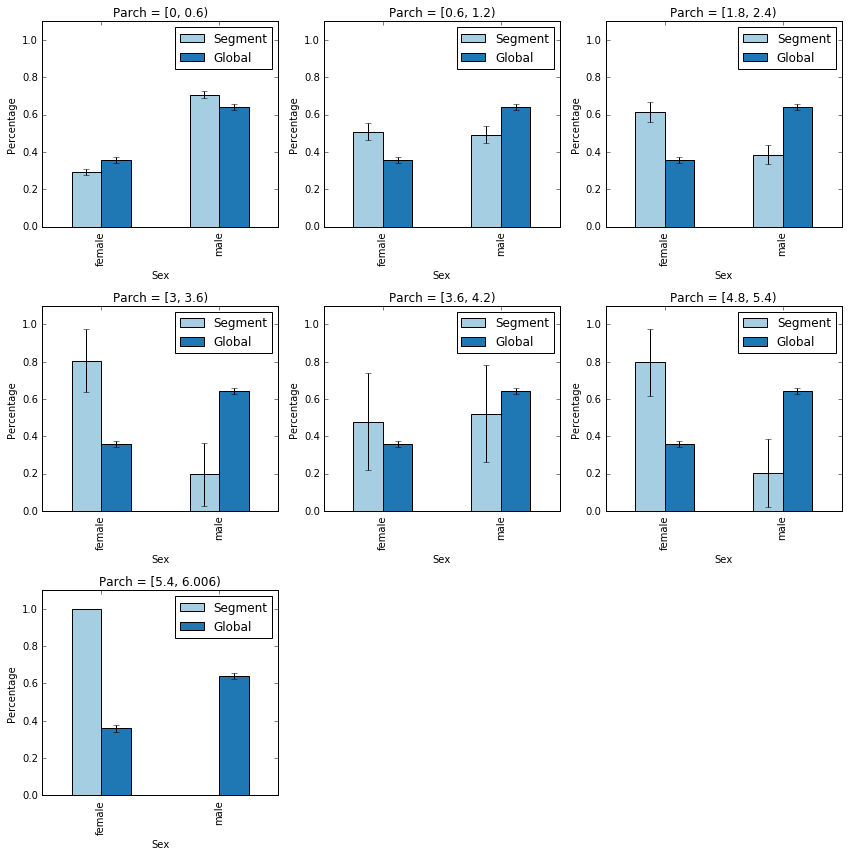

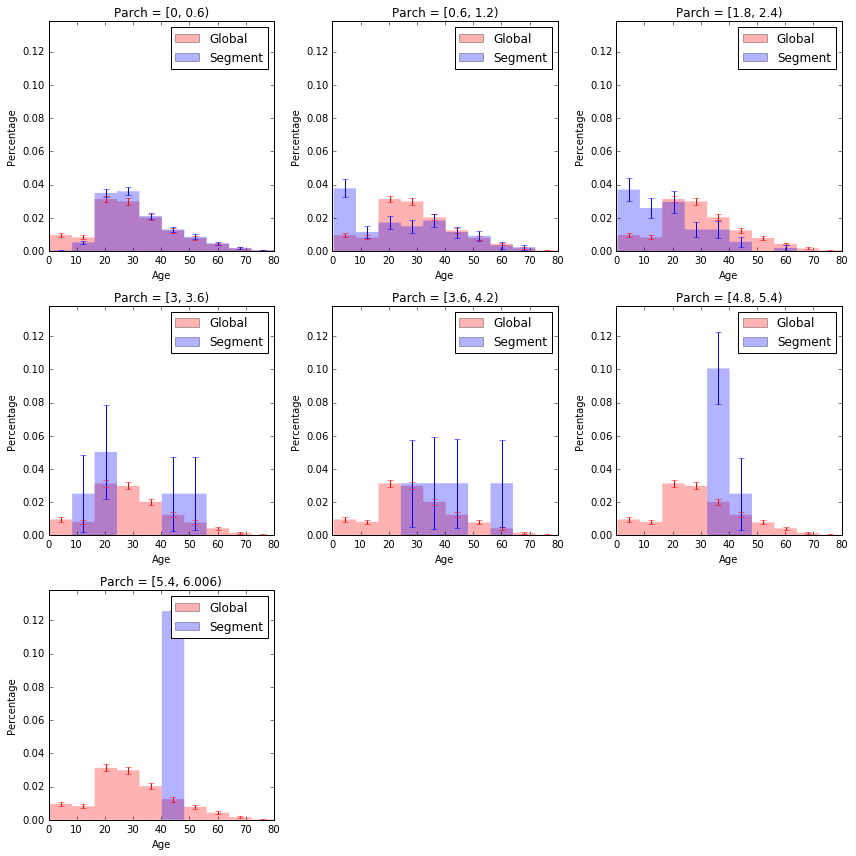

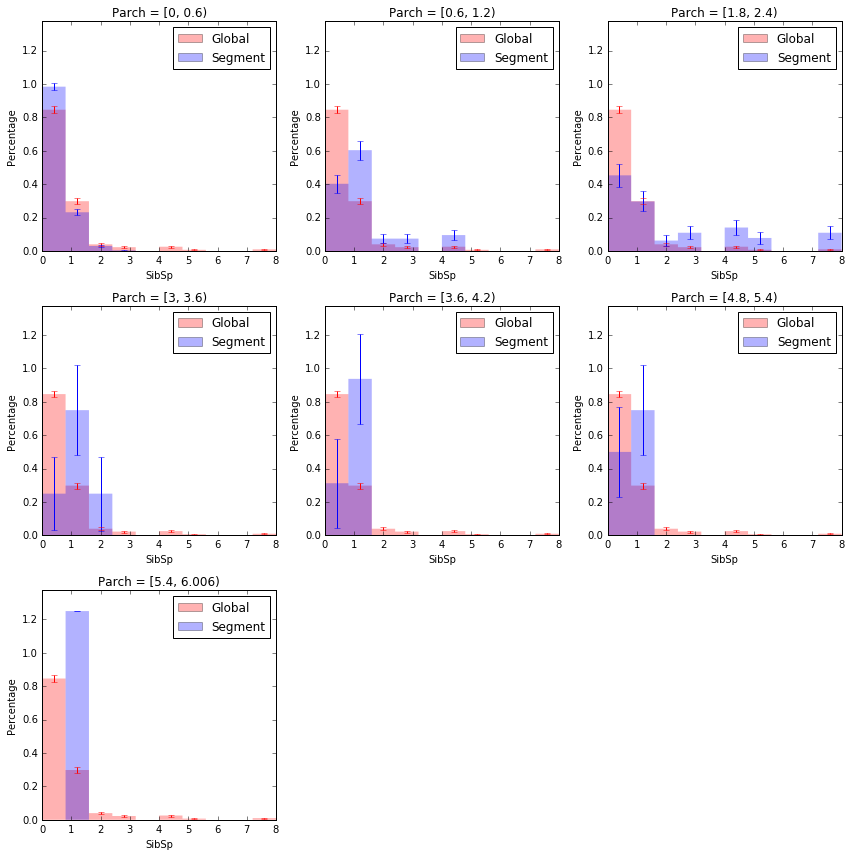

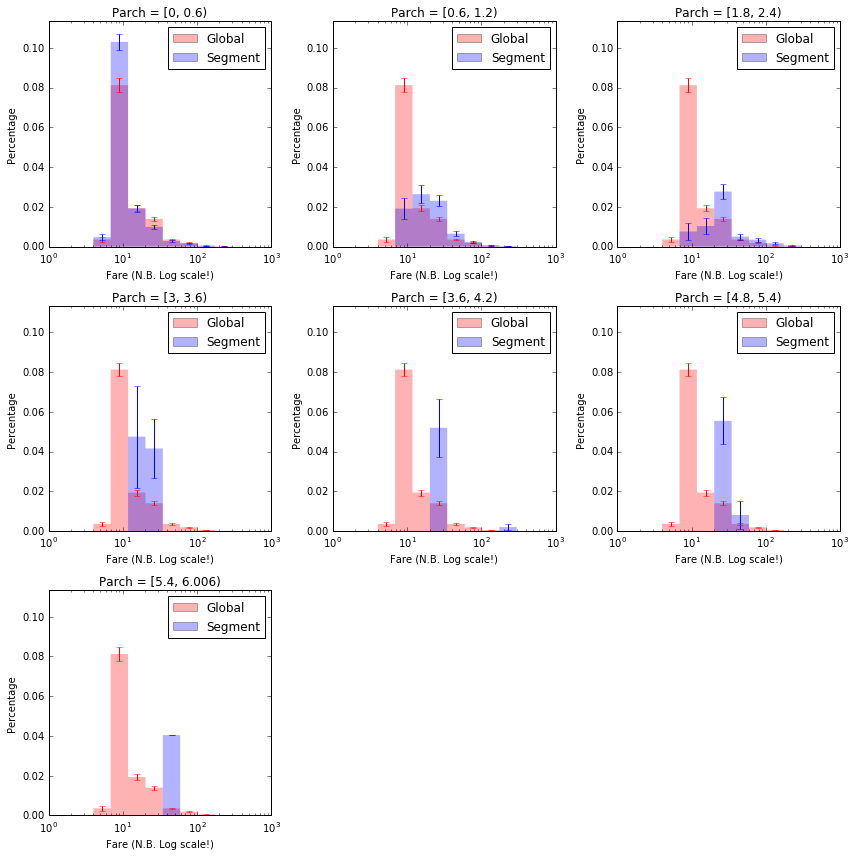

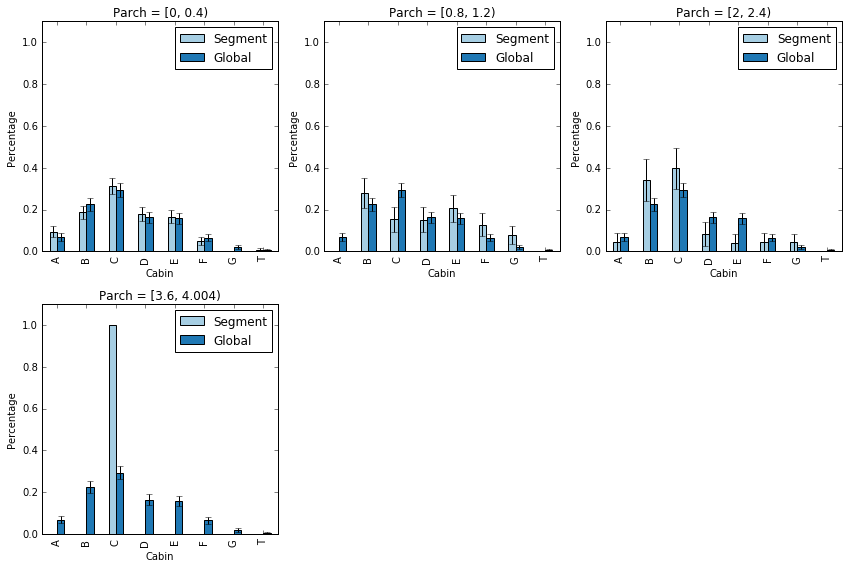

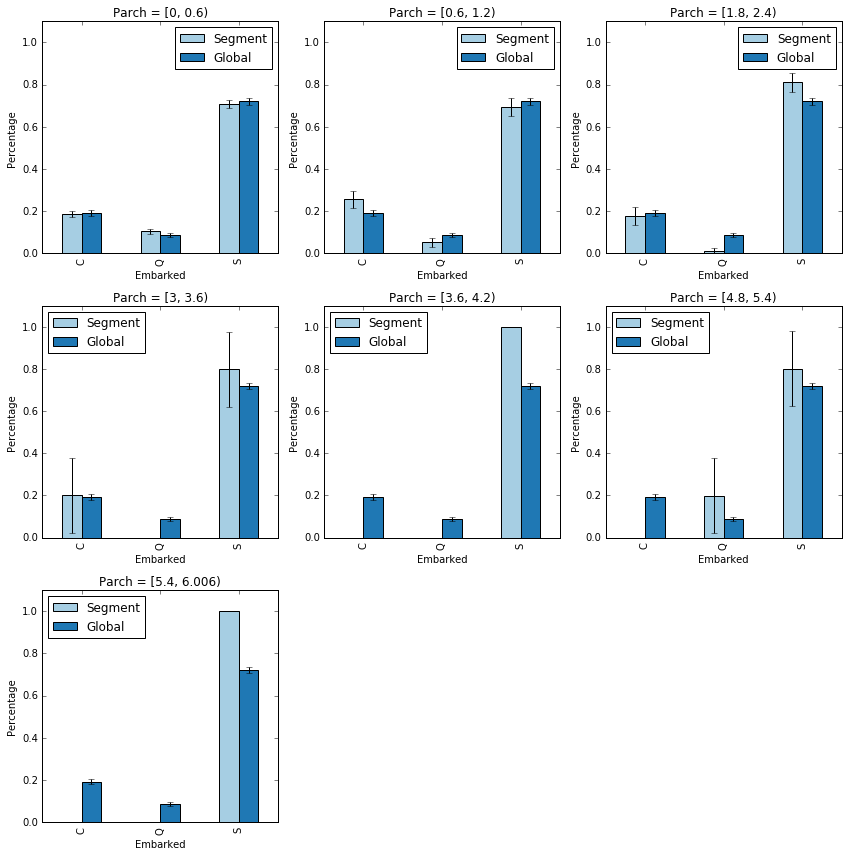

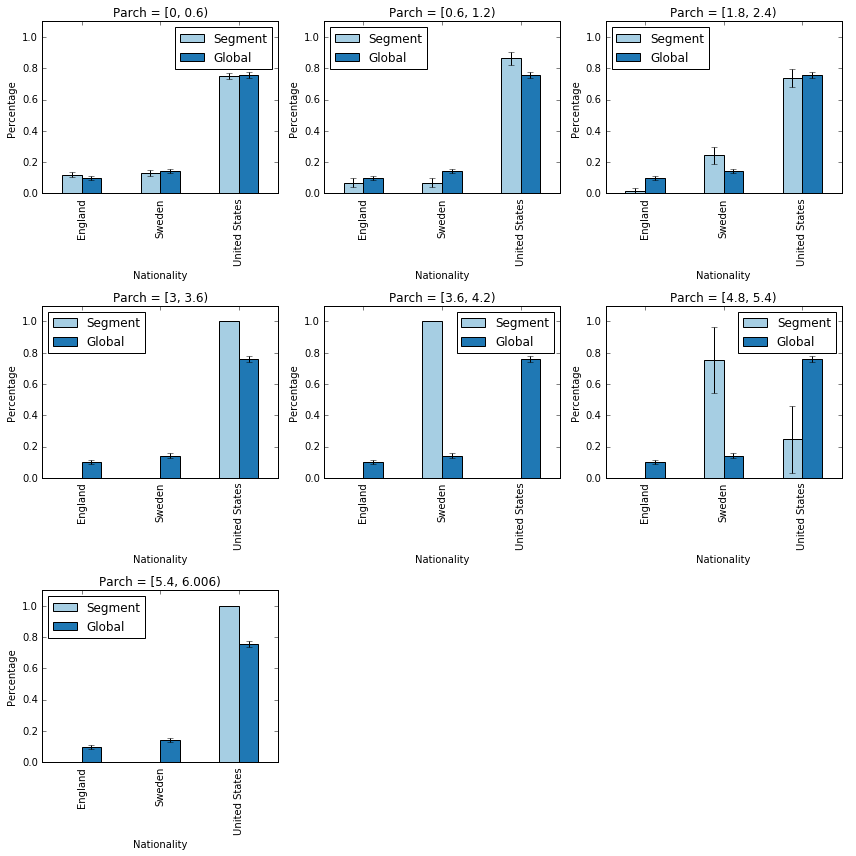

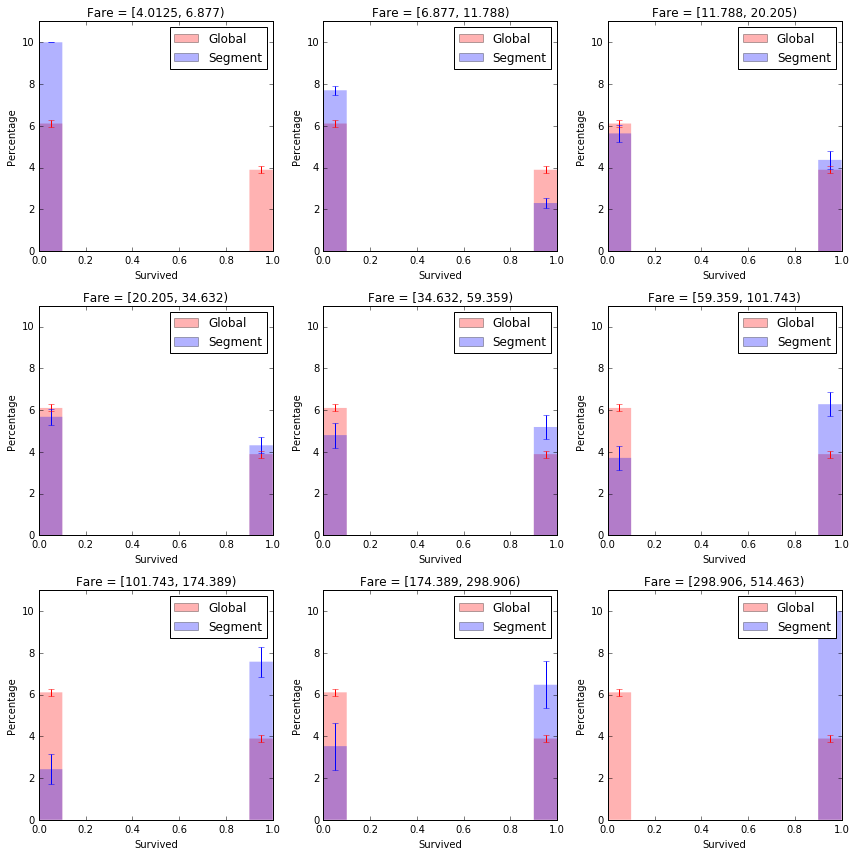

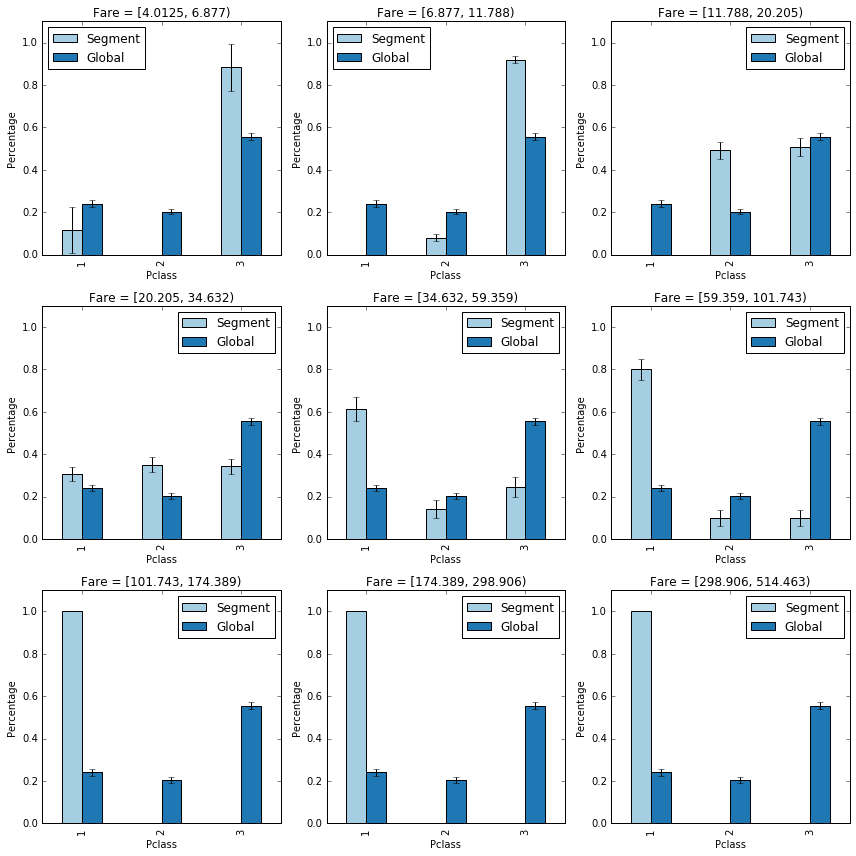

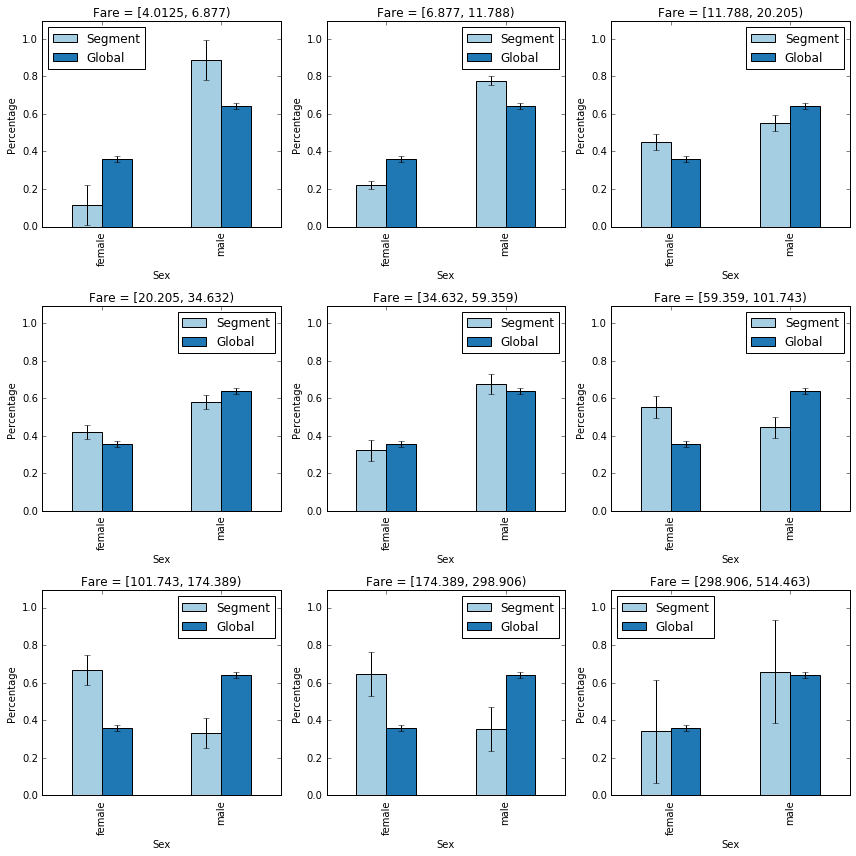

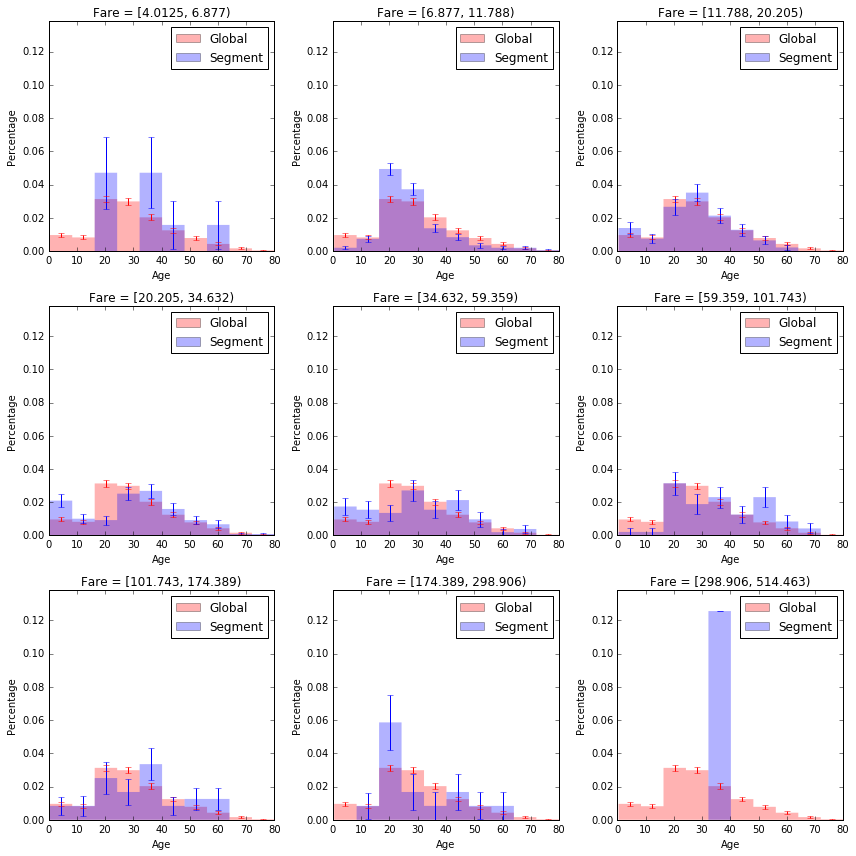

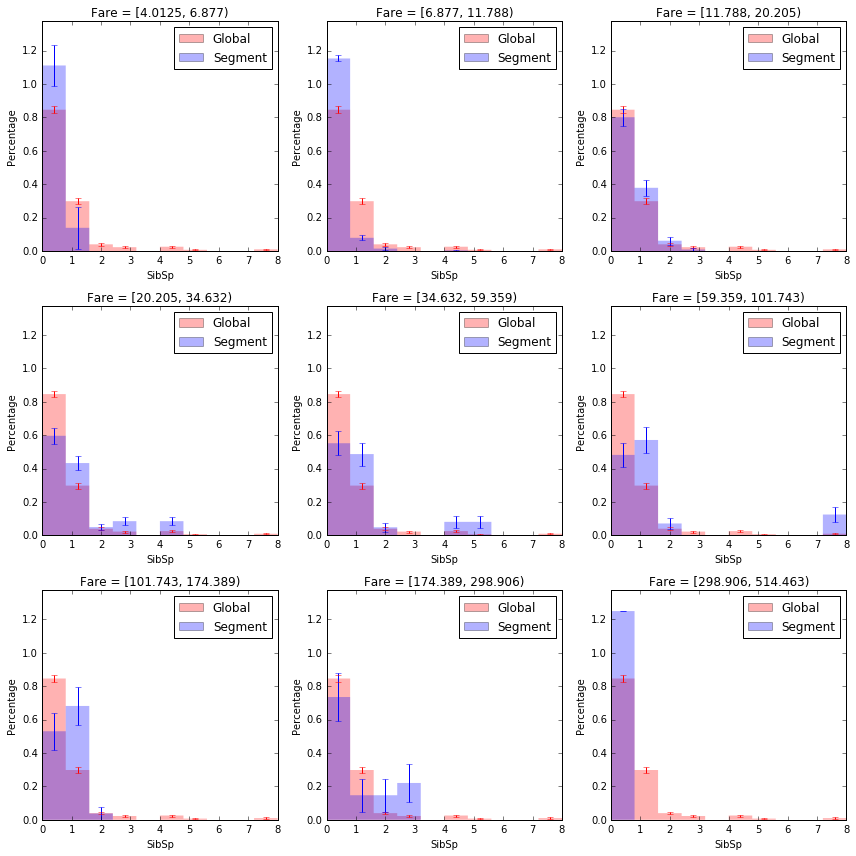

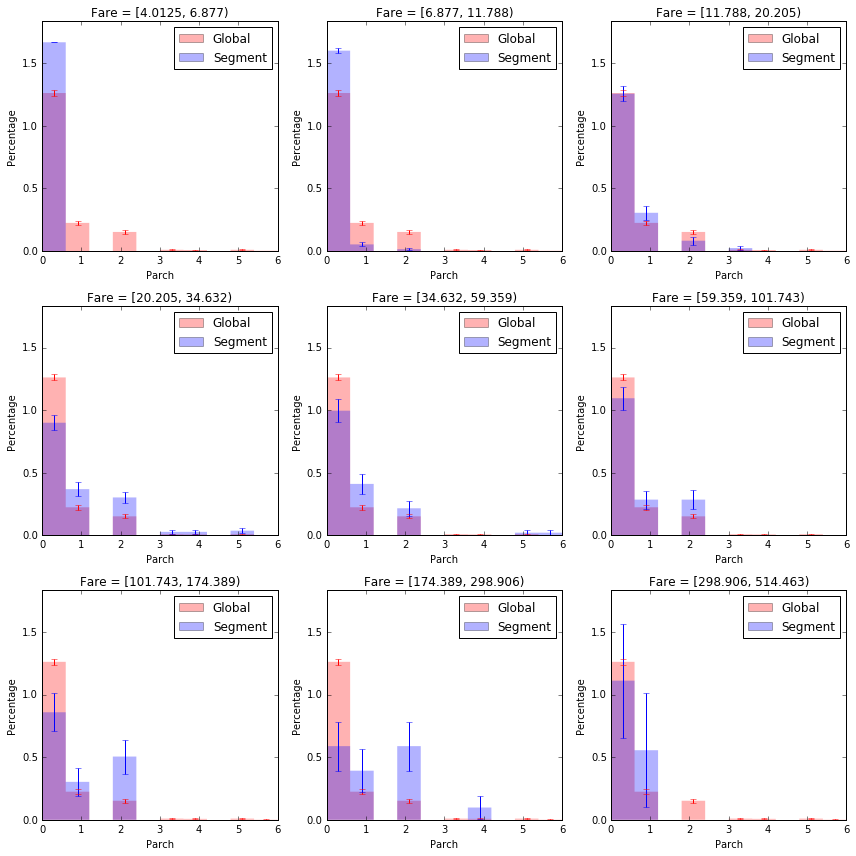

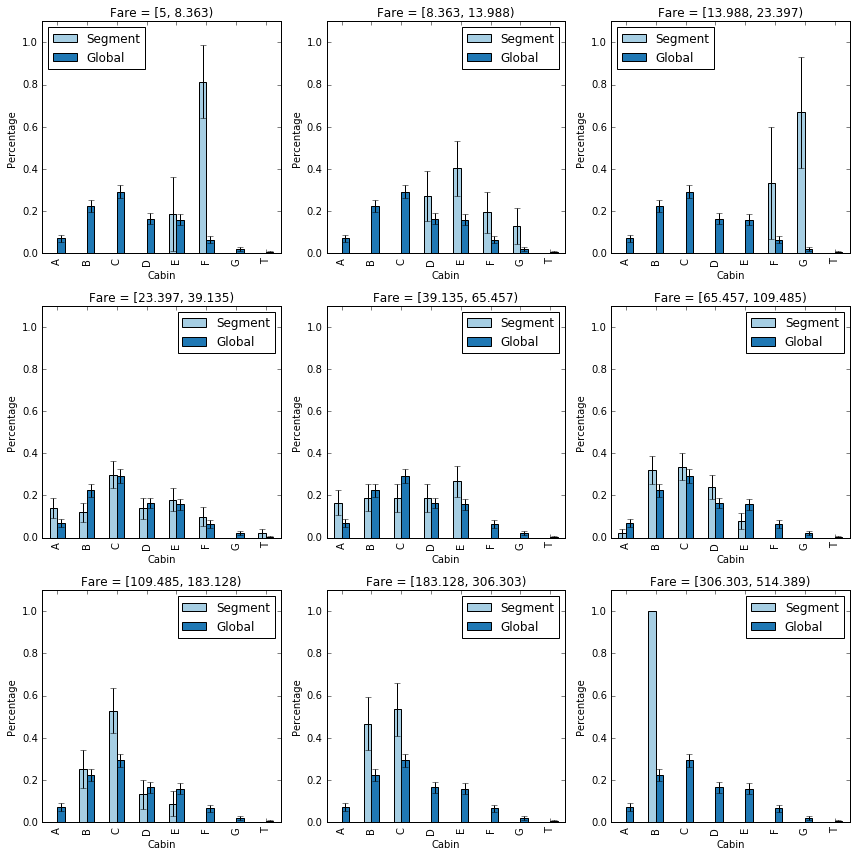

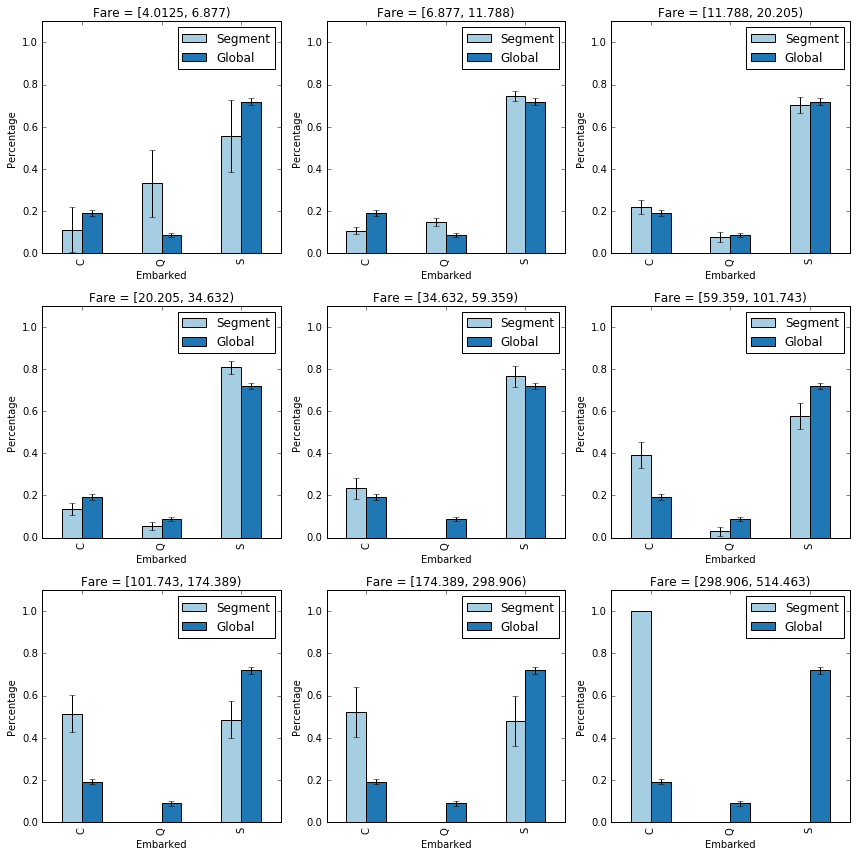

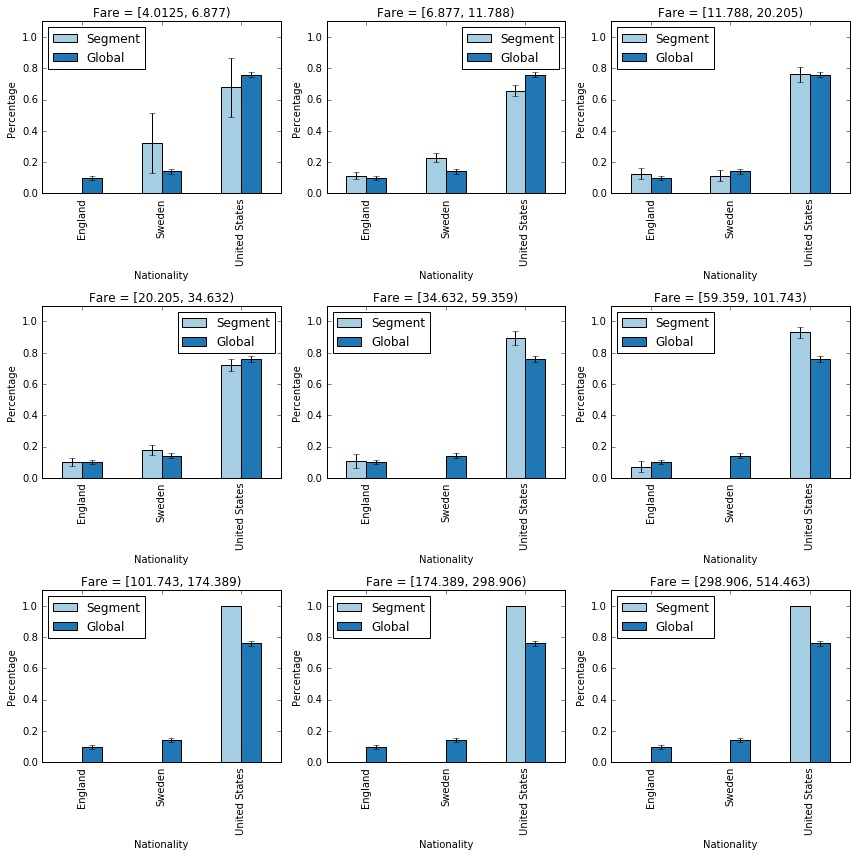

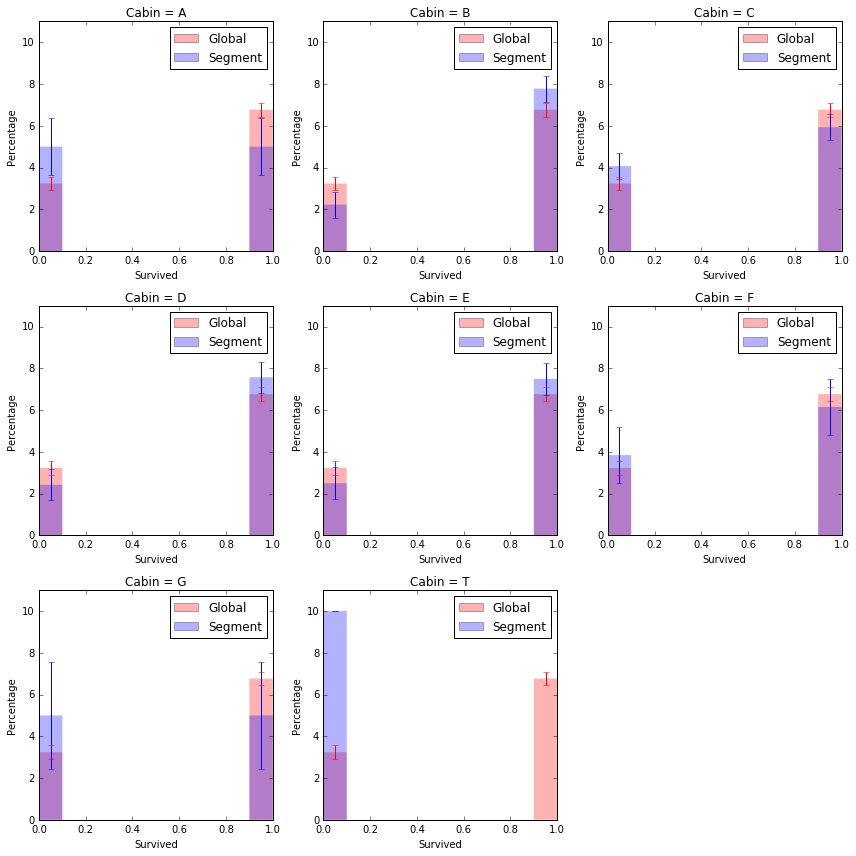

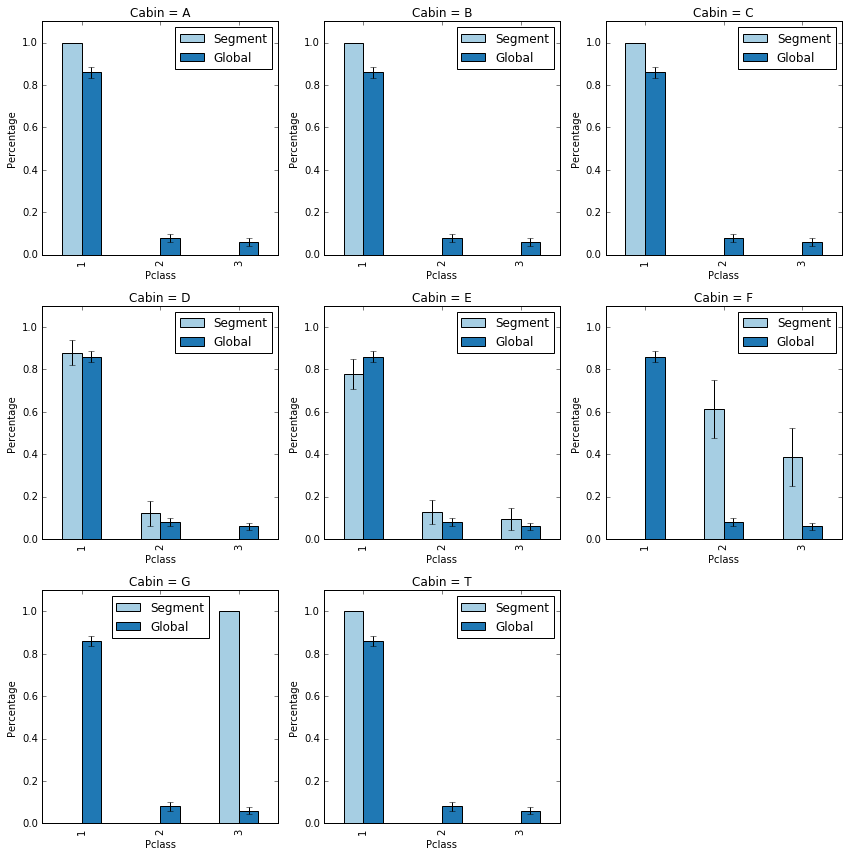

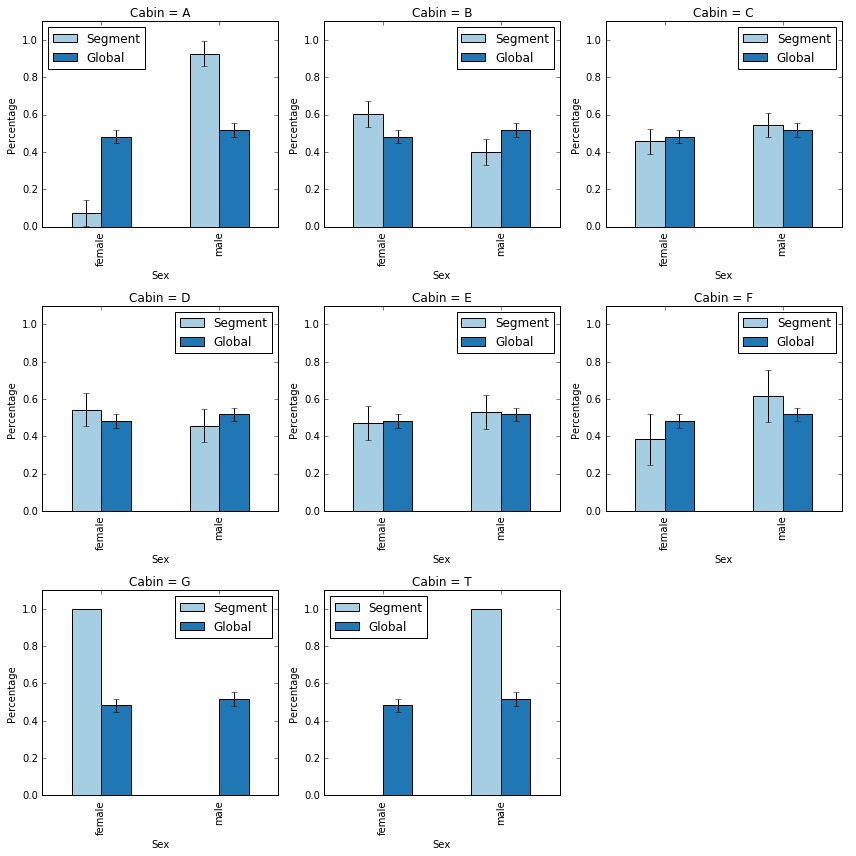

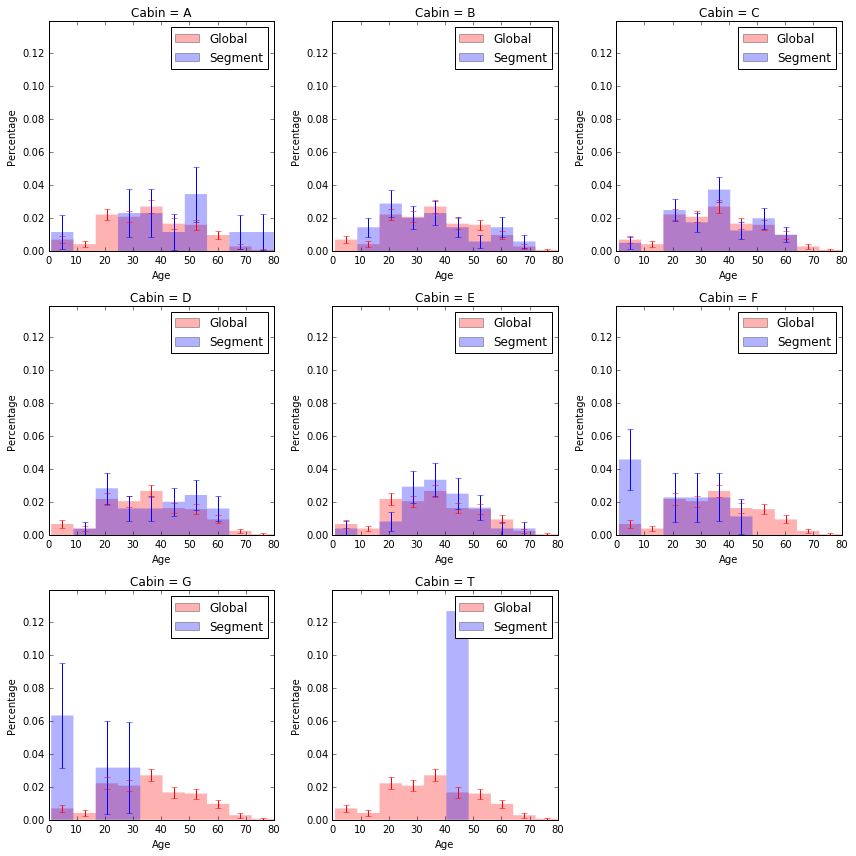

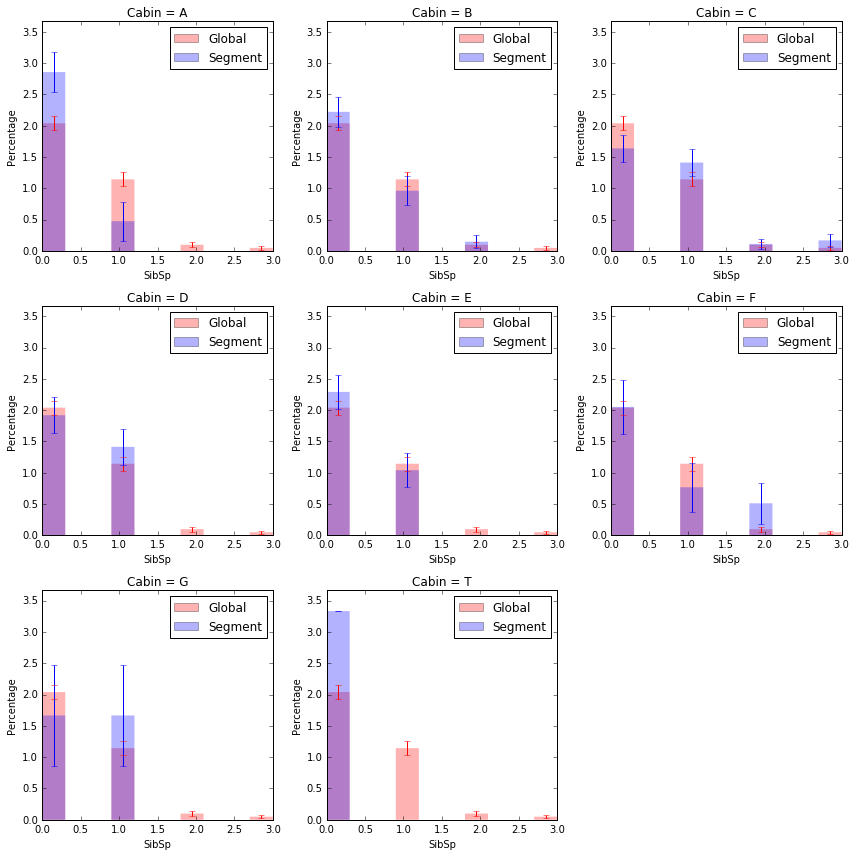

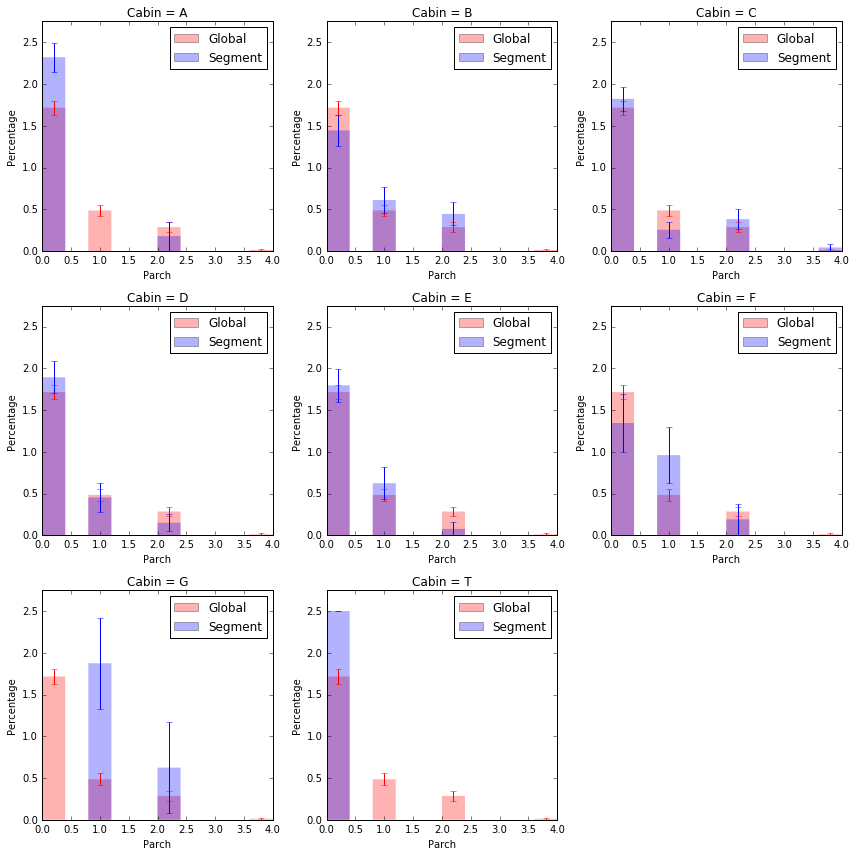

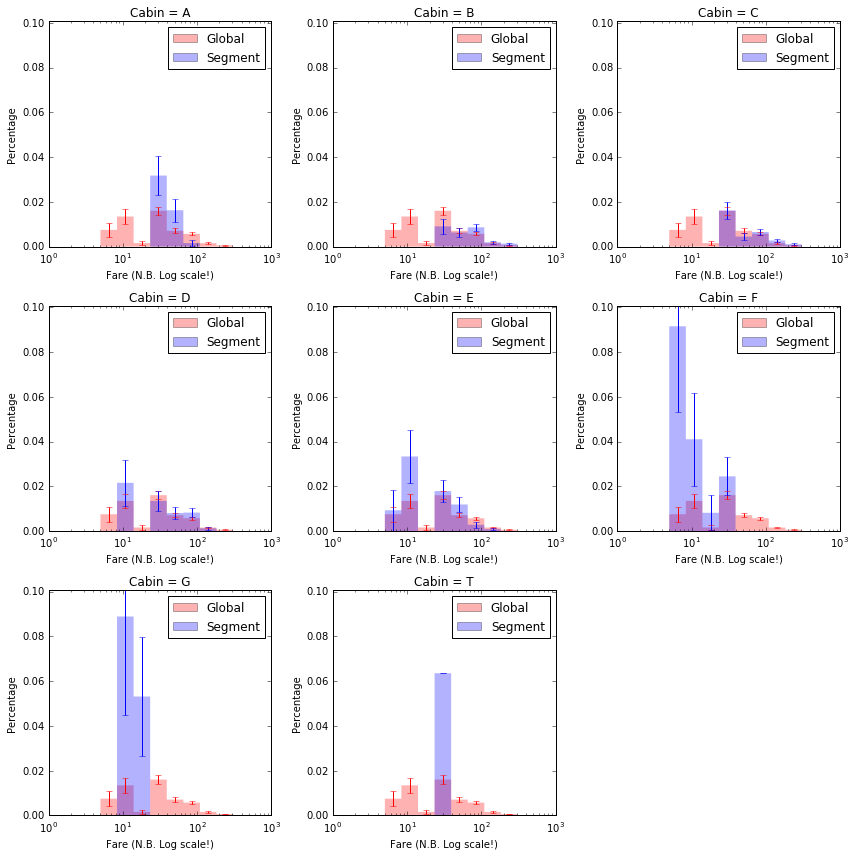

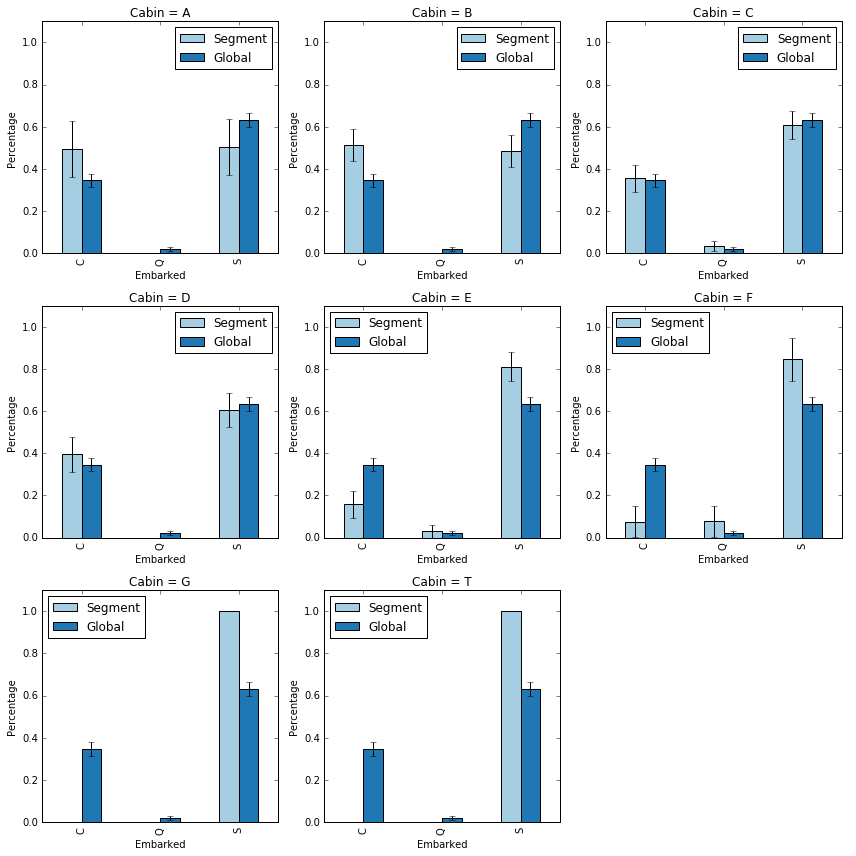

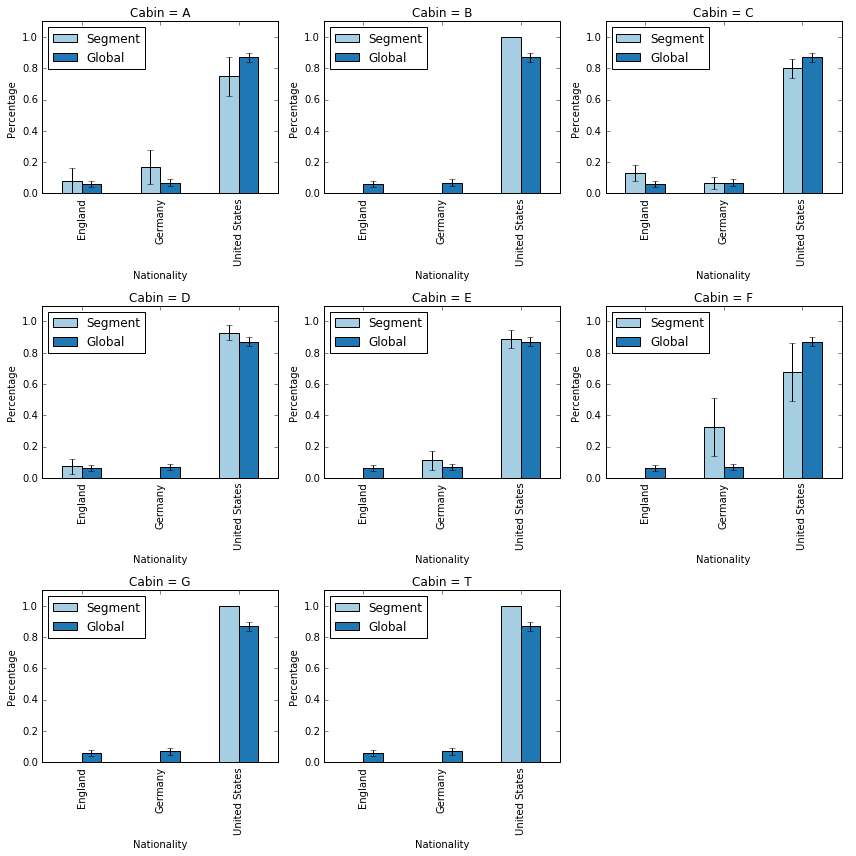

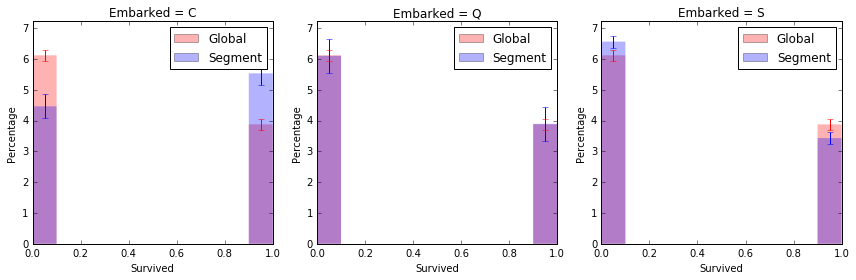

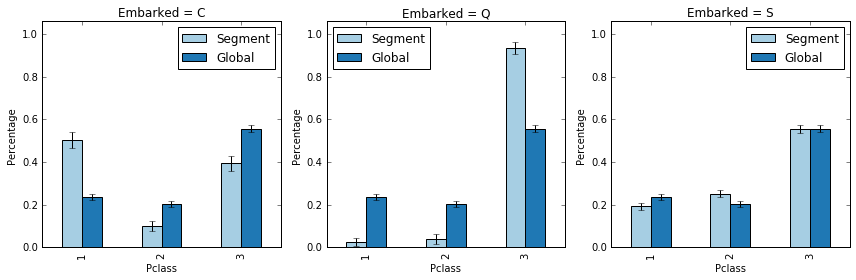

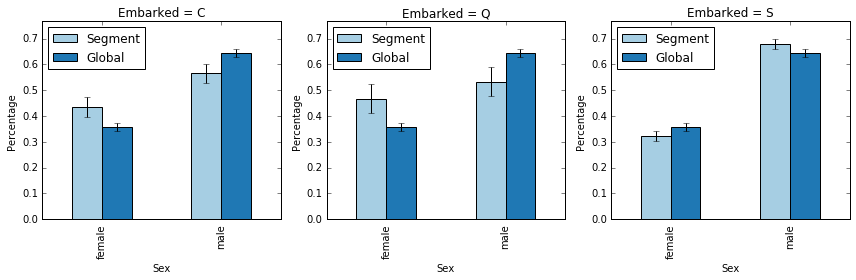

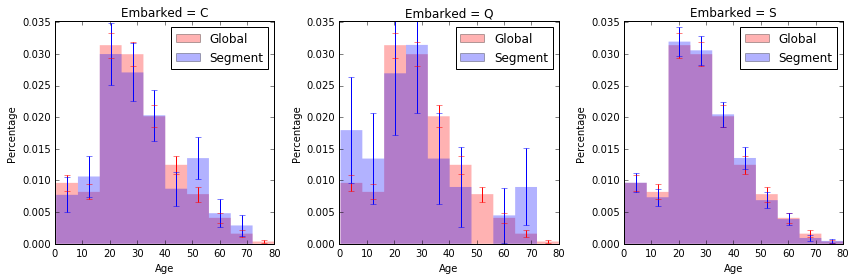

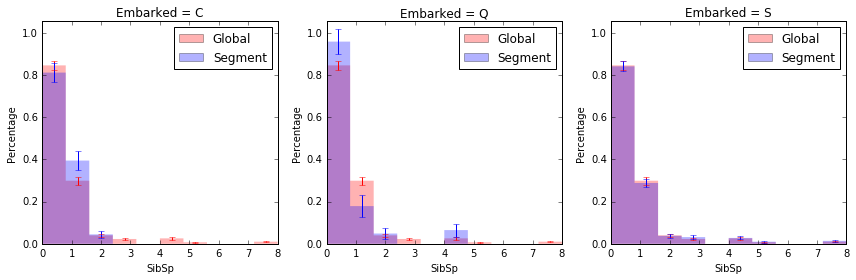

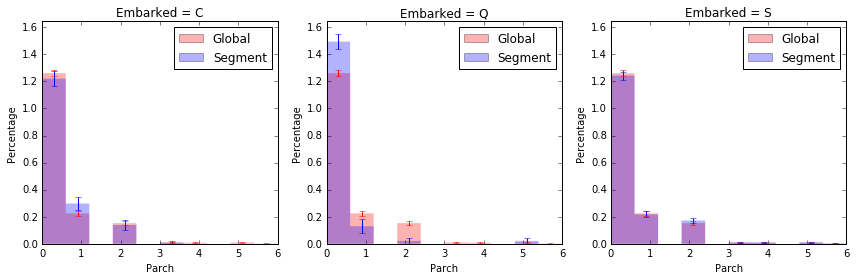

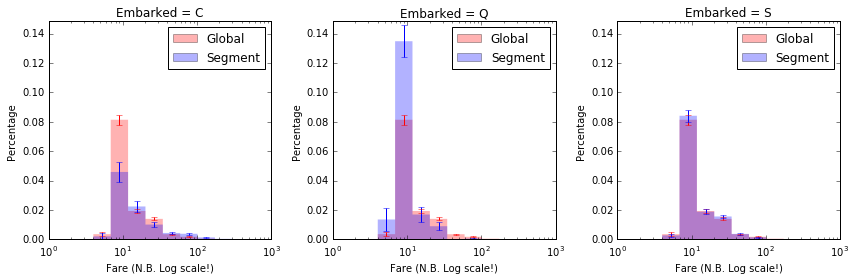

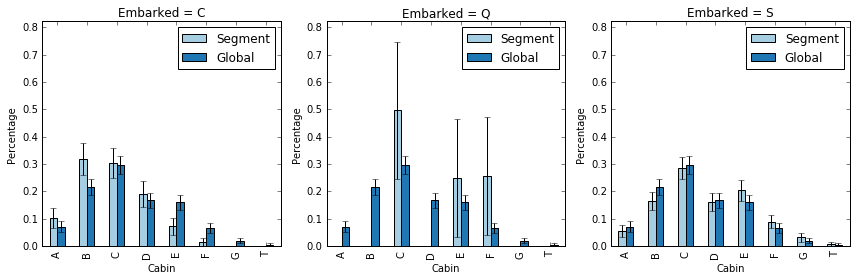

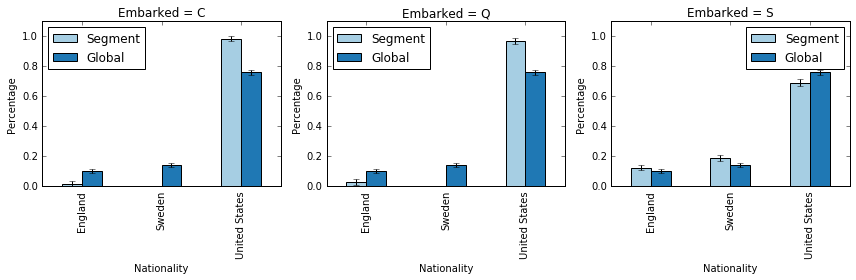

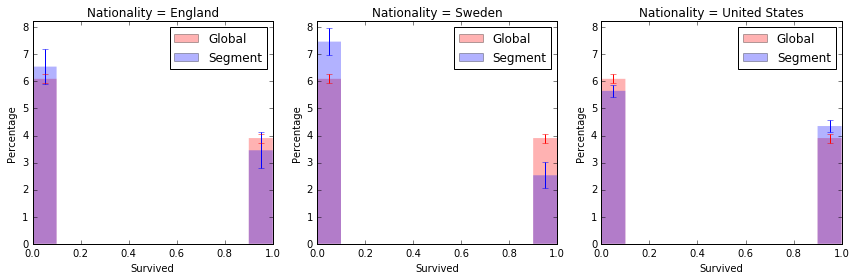

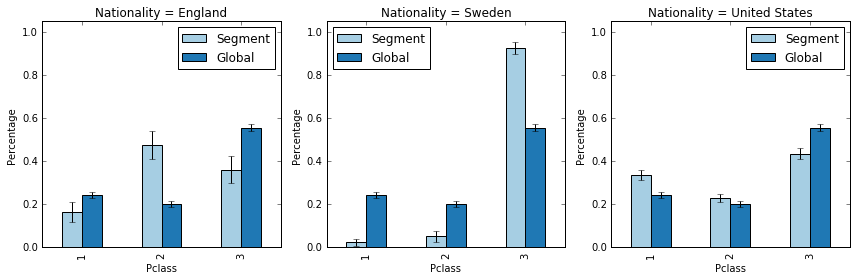

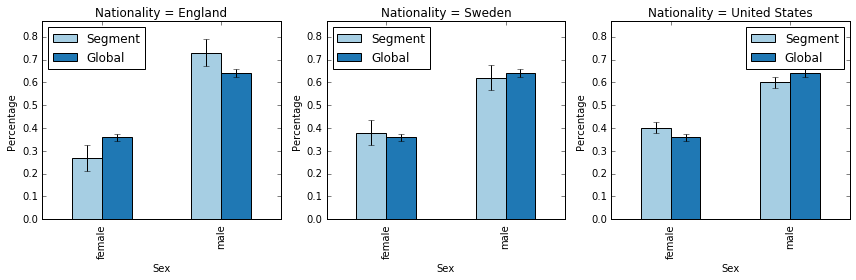

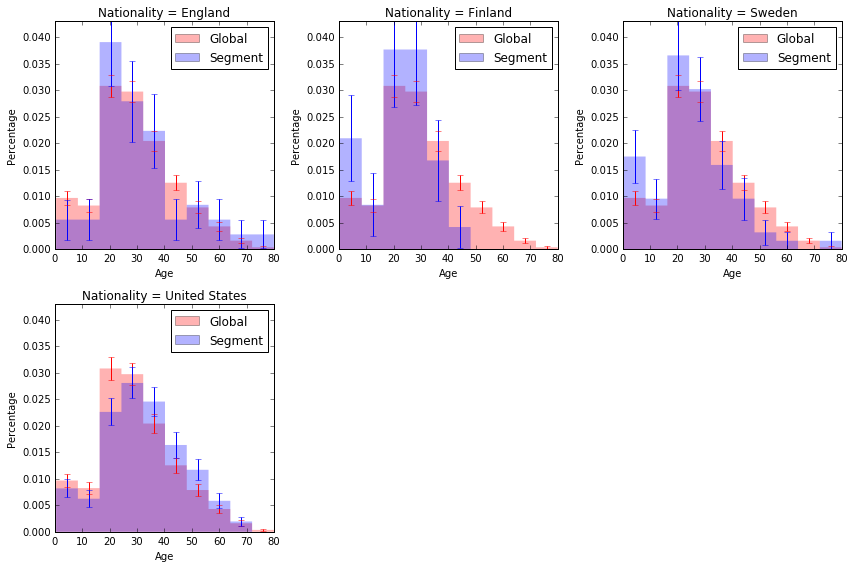

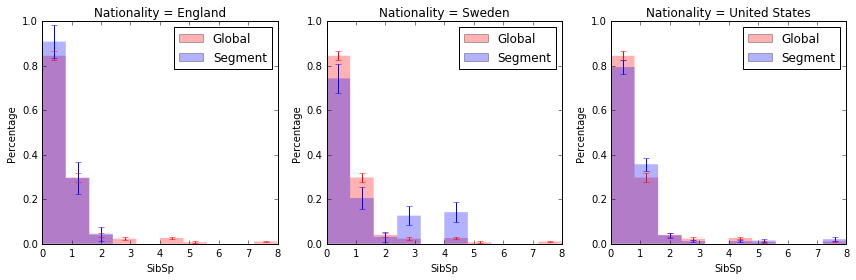

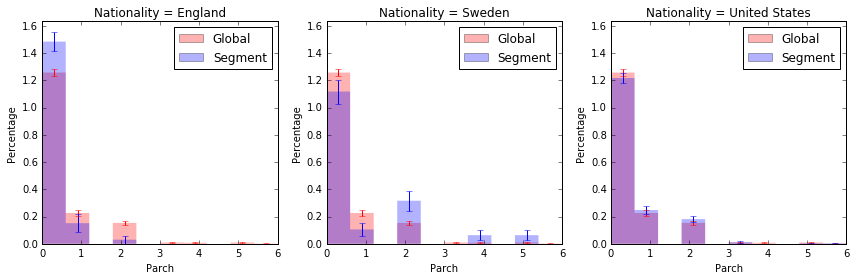

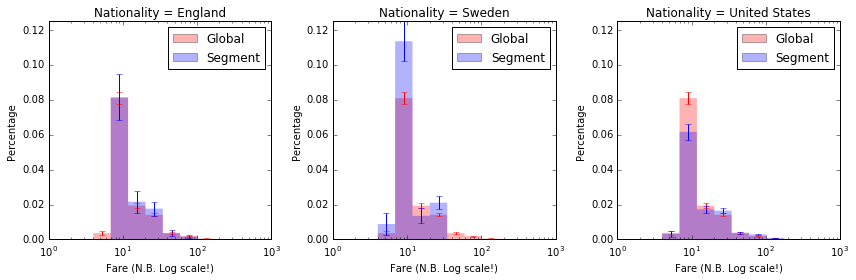

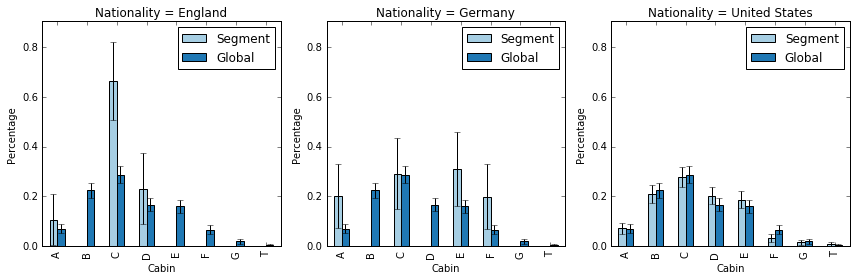

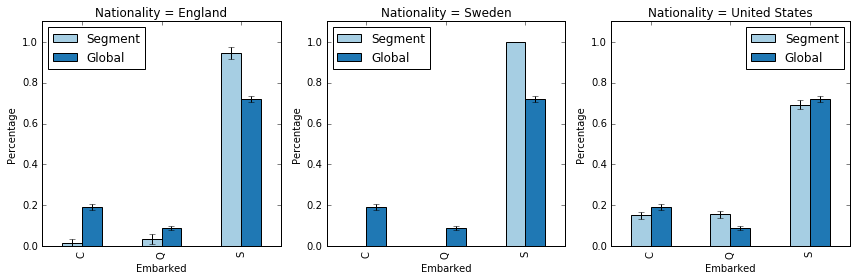

In [12]:
# We'll now draw histograms of the data for each segment in each column.
for ii in range(len(alldataframes)):
    print "ANALYZING DATAFRAME FROM " + datafilenames[ii] + ":"
    print "===================================================="
    drawComparisonData(alldataframes[ii], datacategories[ii], uselesscolumns[ii], unknowns[ii])
    plt.show()

# Correlations

We search for all correlations between the various segments of the various columns, to see which features of the data are really independent (this is useful for dimensional reduction). We groupby on the values of the axis; their average value is shown on the y-axis. Depending on the type of columns we are plotting, we use different types of plots to illustrate the correlations.

If the y-axis is quantitative:
 - We use a scatterplot when the x-axis is quantitative or ordinal. This will illustrate correlations between the quantitative or ordinal values of the x-axis and their average quantitative value on the y-axis.
 - We use a barplot when the x-axis is categorical. This will compare the average value of the quantitative y-axis in each of the categories of the x-axis.

If the y-axis is ordinal:
 - We use a scatterplot when the x-axis is quantitative or ordinal. The ordinal values of the y-axis are assigned numbers 0,1,2,3,... and for each value on the x-axis, the average of the y-axis is plotted. Although the correct spacing between the y-axis values has no meaning, in this way it is still possible to discern correlations between x-axis values and position on the y-axis ordinal scale.
 - We use a confusion-matrix (boxes shaded according to their value) when the x-axis is categorical. For each category of the x-axis, and each ordinal value in the y-axis, we count the number of occurrances in the data that fit into this cross-section of values. This creates a plot of boxes, where we shade each box according to the proportion of the data that fits into the box. This allows us to quickly discern where the data aggregates in each of the categories, as well as between the various categories.
 
If the y-axis is categorical:
 - We use an area plot when the x-axis is quantitative. This enables us to see, for each value of the numerical data, what the breakdown of the various categories is. This plot shows the total number of datapoints with a given x-axis value, as well as showing how that total is broken down into the various categories.
 - We use a stacked column chart when the x-axis is ordinal. This is the half-way house between an area plot and a barplot and can be seen as a discrete version of the area plot. Here we draw a barplot the total number of datapoints for each ordinal value, but where the barplot is broken down into its categorical constituents. Moreover, since ordinal data has a progression along the x-axis and cannot be reordered, we drawn lines connecting the consecutive barplots (and lightly shade their intermittent region).
 - We use a confusion-matrix when the y-axis is categorical. The position of the boxes has no meaning, but this plot shows how the total number of passengers is distributed along the various combinations of categories. This allows us to detect correlations between the categories, such as "male datapoints are usually French, but female datapoints are usually Spanish".

### Functions for making scatterplots and barplot

In [13]:
# This function plots a scatterplot when the yaxis and xaxes are either quantitative or ordinal.
# yaxcolumn is the the string name of the dataframe column representing the yaxis and xaxcolumn 
# is the xaxis. If some columns are ordinal rather than quantitative, the user must provide a dictionary 
# of the form {"ColumnName": [firstelement, secondelement, ...]} which specifies in which order the categories
# should be taken.
def numVersusNumOrdCatAxis(inputdataframe, yaxcolumn, xaxcolumn, currentax, datacateg, dictofunknown, dictofordinals={}):
    # We begin by making a copy of the frame, in which ordinal columns will be replaced with a numeric sequence.
    # When we plot the scatterplot, we'll swap the labels on the axes with the ordinal labels.
    (plottingdataframe, neworderings) = orderOrdinalData(inputdataframe, dictofordinals)
    # We also remove those rows where we have no data
    newplottingdataframe = removeAutogeneratedData(plottingdataframe, [xaxcolumn, yaxcolumn], dictofunknown)
    # Now we remove those rows that have very sparse data, for any columns which are categorical
    newplottingdataframe = removeSparseColumns(newplottingdataframe, 
                                               [el for el in [xaxcolumn, yaxcolumn] if datacateg[el]=="C"])
    # Now we do a groupby on the xaxis
    grouped = newplottingdataframe.groupby(xaxcolumn)[yaxcolumn]
    toplotdata = grouped.mean()
    xaxis = np.array(toplotdata.index)
    yaxis = np.array(toplotdata.values)
    if datacateg[xaxcolumn]=="C":
        toplotdata.plot.bar(ax=currentax, color=brewerColors(1))
        currentax.axhline(0, color='black')
        currentax.set_ylabel(yaxcolumn)
    else:
        # If we have ordinal data on the x-axis, the points are far apart and there's no need
        # to have semi-transparent points
        if xaxcolumn in dictofordinals:
            transparency = 1
        else:
            transparency = 0.3
        currentax.scatter(xaxis, yaxis, alpha=transparency, edgecolors="none")
        # We'll now assess whether it would be better to use a log scale for the xaxis,
        # and if so do it.
        currentax.set_xlabel(xaxcolumn)
        currentax.set_ylabel(yaxcolumn)
        if (xaxcolumn not in dictofordinals):
            currentax = placeLogScaleIfNeeded(xaxis, currentax)
        # If we have ordinal data on the x-axis or y-axis, we should only have ticks at the
        # positions of the actual data, and change the tick-names to the name of each category
        currentax = placeOrdinalDataTicks(xaxcolumn, yaxcolumn, neworderings, dictofordinals, currentax)
    return currentax

#### Helper functions for ordering and labeling ordinal data

In [14]:
# Returns the same dataframe but where the ordinal data has been replaced with numbers, and hence can
# be ordered correctly. When plotting it will be necessary to replace the numbers back to their
# original categorical labels.
def orderOrdinalData(thedataframe, dictofordinals):
    orderedordinalsframe = deepcopy(thedataframe)
    # We need to turn the dictionary dictofordinals into a form good for using pandas .replace(dict)
    neworderings = deepcopy(dictofordinals)
    for key in neworderings:
        # Pandas complains if we have intersections between the keys and the values
        intersectionlength = len(set(neworderings[key]).intersection(set(range(1,len(neworderings[key])+1))))
        if intersectionlength==0:
            # We can just replace the entries with 0,1,2,...,num_categories-1
            neworderings[key] = dict([(el,ii+1) for ii,el in enumerate(neworderings[key])])
        else:
            # We replace with '0',1','2',.... instead. We will later turn the strings into ints.
            neworderings[key] = dict([(el,str(ii+1)) for ii,el in enumerate(neworderings[key])])
    # Now we'll replace the ordinal columns in the dataframes with numeric labels
    if dictofordinals!={}:
        orderedordinalsframe.replace(neworderings, inplace=True)
        for key in neworderings.keys():
            orderedordinalsframe.loc[:,key] = pd.to_numeric(orderedordinalsframe[key])
    return (orderedordinalsframe, neworderings)

# Takes an axis of a figure and columns that are plotted, and swaps numeric labels for ordinal
# data with their true "ordinal labels", e.g. 1 -> "small" 2-> "medium" 3 -> "big"
def placeOrdinalDataTicks(xaxcolumn, yaxcolumn, neworderings, dictofordinals, inputaxis, onlylabels=False):
    if xaxcolumn in dictofordinals:
        inv_map = {pd.to_numeric(v): k for k, v in neworderings[xaxcolumn].iteritems()}
        if onlylabels==False:
            inputaxis.set_xticks(inv_map.keys())
        inputaxis.set_xticklabels(inv_map.values())
    if yaxcolumn in dictofordinals:
        inv_map = {pd.to_numeric(v): k for k, v in neworderings[yaxcolumn].iteritems()}
        if onlylabels==False:
            inputaxis.set_yticks(inv_map.keys())
        inputaxis.set_yticklabels(inv_map.values())
    return inputaxis

### Functions for making confusion matrix

In [15]:
# Takes an axis and plots a confusion-like matrix, representing the correlation between two different
# categorical data, or an ordinal and a categorical data. Each block in the matrix is colored blue
# and saturated according to the amount of data that fits into that box, i.e. the number of rows in
# thedataframe that have the corresponding categorical data. yaxcolumn and xaxcolumn are strings 
# denoting the column-names of the categorical/ordinal data in thedataframe. givenaxis is the axis
# we are meant to plot on.
def dataframeIntoConfusionlikeMatrixAxis(thedataframe, yaxcolumn, xaxcolumn, dictofunknown, givenaxis, dictofordinals={}):
    # We begin by turning ordinal data into numeric numbers, and removing autogenerated data and sparse columns
    (plottingdataframe, neworderings) = orderOrdinalData(thedataframe, dictofordinals)
    plottingdataframe = removeAutogeneratedData(plottingdataframe, [xaxcolumn, yaxcolumn], dictofunknown)
    plottingdataframe = removeSparseColumns(plottingdataframe, [xaxcolumn, yaxcolumn])
    matrixofweights = countCrossSectionOfData(plottingdataframe, yaxcolumn, xaxcolumn)
    rowandcolumnlabels = [matrixofweights.index, list(matrixofweights)]
    matrixofweights = matrixofweights.as_matrix()
    givenaxis = makeConfusionlikeMatrix(matrixofweights, givenaxis)
    # Finally, we format the box a bit so it contains all labels etc.
    givenaxis.set_xticklabels(rowandcolumnlabels[1])
    givenaxis.set_yticklabels(rowandcolumnlabels[0])
    givenaxis = placeOrdinalDataTicks(xaxcolumn, yaxcolumn, neworderings, dictofordinals, givenaxis, onlylabels=True)
    givenaxis.set_xlabel(xaxcolumn)
    givenaxis.set_ylabel(yaxcolumn)
    return givenaxis

#### Helper functions for counting data in combinations of categories, and for making confusion-matrix-like plots

In [16]:
# Produces a dataframe where each row corresponds to a categorical or ordinal value
# and each column corresponds to a different categorical or ordinal value. The entries
# in the produced dataframe are the total numnber of datapoints that fir the specifications
# of the given row and column.
def countCrossSectionOfData(inputdataframe, rowcatname, colcatname):
    grouped = inputdataframe.groupby([rowcatname,colcatname]).count()
    # We must now turn this dataframe in the form where rows are one category and columns are
    # another category. The function pivot does this. "firstcolumn" is an arbitrary column
    firstcolumn = list(grouped)[0]
    # We start by doing .reset_index(), which places both indices as new columns in the matrix. We
    # can then take the resulting object and use .pivot on it.
    outputdataframe = grouped.reset_index()[[rowcatname,colcatname,firstcolumn]]
    outputdataframe = outputdataframe.pivot(rowcatname,colcatname,firstcolumn).fillna(0)
    return outputdataframe

# This function takes a matrix of weight and and an axis for plotting on, and plots a confusion-matrix
# of values on the specified axis. weightlabels controls whether to print out the numbers inside
# the boxes of the confusion matrix.
def makeConfusionlikeMatrix(matrixofweights, inputaxis, weightlabels=True):
    # We will now normalize the values of matrixofweights, so that the entries can become 
    # "alpha parameters" which set the transparency. Before doing so, let's save a copy
    # which will be useful for placing labels on the boxes of the confusion matrix
    total = matrixofweights.sum()
    normalizedmatrixofweights = matrixofweights / float(total)
    # Now we have normalized the matrix. We will now create the graphical rectangles 
    # which make up the graphical confusion matrix. Each box has a unique x&y coordinate
    # and a transparency given by matrixofweights
    (numrows, numcols) = normalizedmatrixofweights.shape
    heightofeachbox = 1./numrows
    widthofeachbox = 1./numcols
    allboxes = []
    for rownum,rowval in enumerate(normalizedmatrixofweights):
        for colnum,colval in enumerate(rowval):
            allboxes.append(patches.Rectangle((colnum*widthofeachbox, rownum*heightofeachbox), 
                              widthofeachbox, heightofeachbox, alpha=colval, edgecolor="none"))
    # We now take the axis given in the input and place the colored rectangles in it
    for i,p in enumerate(allboxes):
        # add_patch places the rectangle in it
        inputaxis.add_patch(p)
        if weightlabels==True:
            # We also write out the number corresponding to each box
            pos = p.get_xy()
            num = int(matrixofweights.ravel()[i])
            # we can fit 80 characters in total, so to make sure the numbers are centered we 
            # place them in the middle of each box and shift left by len(str(num))/80.0
            inputaxis.text(pos[0]+widthofeachbox/2-len(str(num))/80.0, pos[1]+heightofeachbox/2-1/80.0, num)
    # Finally, we format the box a bit so it contains all labels etc.
    inputaxis.set_xticks(np.arange(widthofeachbox/2,1,widthofeachbox))
    inputaxis.set_yticks(np.arange(heightofeachbox/2,1,heightofeachbox))
    return inputaxis

### Functions for making stacked column charts

In [17]:
# Plots a stacked barplot chart, i.e. a barplot where each column is split according to the categories of
# yaxcolumn and the various sections of each column are connected to each other through lines and shaded colors
# to suggest progression from left to right. Hence, xaxcolumn should be the name of ordinal data.
def dataframeStackedBarChart(thedataframe, yaxcolumn, xaxcolumn, dictofunknown, givenaxis, dictofordinals={}):
    # We begin by turning ordinal data into numeric numbers, and removing autogenerated data and sparse columns
    (plottingdataframe, neworderings) = orderOrdinalData(thedataframe, dictofordinals)
    plottingdataframe = removeAutogeneratedData(plottingdataframe, [xaxcolumn, yaxcolumn], dictofunknown)
    plottingdataframe = removeSparseColumns(plottingdataframe, [xaxcolumn, yaxcolumn])
    # Now we make a dataframe where the rows correspond to the ordinal data and the columns correspond
    # to the categories which make up each column of the stacked barplot.
    matrixofweights = countCrossSectionOfData(plottingdataframe, xaxcolumn, yaxcolumn)
    matrixofweights.plot.bar(ax=givenaxis, stacked=True, color=brewerColors())
    givenaxis.set_xlabel(xaxcolumn)
    givenaxis.set_ylabel("Total " + yaxcolumn)
    givenaxis = placeOrdinalDataTicks(xaxcolumn, yaxcolumn, neworderings, dictofordinals, givenaxis, onlylabels=True)
    # Now we insert lines between the columns of the barplot, as well as semitransparent color-filler
    for linenum in givenaxis.get_xticks()[:-1]:
        for categorynumber in range(len(list(matrixofweights))):
            givenaxis = fillerBetweenBars(matrixofweights, linenum, categorynumber, givenaxis)
    return givenaxis

#### Helper functions for stacked column charts

In [18]:
# Takes a specified figure-axis and the matrix of weights that determines the stacked barplot, 
# and draws connector lines between the sections of a pair barplot columns. It also fills in
# the area between the barplot column in the same color as the column, but with semitransparency.
# linenum numbers the slots between consecutive barplot columns, and categorynumber numbers the
# categories plotted on each column.
def fillerBetweenBars(matrixofweights, linenum, categorynumber, inputaxis):
    # First we must find what the bounding lines are between the barplot columns. We
    # will then fill in the space between with semitransparent brewerScale colors.
    x1 = linenum+0.25 # the starting x-value of the lines
    x2 = linenum+0.75 # the endpoint x-value of the lines
    y1 = matrixofweights.iloc[linenum].cumsum()[categorynumber] # the startpoint y-value of the top line
    y2 = matrixofweights.iloc[linenum+1].cumsum()[categorynumber] # the endpoint y-value of the top line
    allx = np.linspace(x1, x2) 
    k = (y2 - y1) / (x2 - x1) # the slope of the top line
    allytop = y1 + k*(allx - x1) 
    # Now we must work out the bottom line
    if categorynumber==0:
        allybottom = 0*allx
    else:
        y1 = matrixofweights.iloc[linenum].cumsum()[categorynumber-1]
        y2 = matrixofweights.iloc[linenum+1].cumsum()[categorynumber-1]
        k = (y2 - y1) / (x2 - x1)
        allybottom = y1 + k*(allx - x1)
    # Finally, we can use fill_between() to shade the area between columns in the barplot
    inputaxis.fill_between(allx, allytop, allybottom, color=brewerColors()[categorynumber], alpha=0.2)
    # We also draw the top line and bottom line
    inputaxis.plot([linenum+0.25,linenum+0.75],
                           [matrixofweights.iloc[linenum].cumsum()[categorynumber],
                            matrixofweights.iloc[linenum+1].cumsum()[categorynumber]], 
                           color="black")
    return inputaxis

### Functions for making area plots

In [19]:
# Plots an area plot of the dataframe, where xaxcolumn should be quantitative and yaxcolumn should be categorical.
# The plot will appear in the plot-axis called givenaxis.
def dataframeIntoAreaPlotAxis(thedataframe, yaxcolumn, xaxcolumn, dictofunknown, givenaxis, dictofordinals={}):
    # We begin by making a copy of the frame, in which ordinal columns will be replaced with a numeric sequence.
    # When we plot the scatterplot, we'll swap the labels on the axes with the ordinal labels.
    (plottingdataframe, neworderings) = orderOrdinalData(thedataframe, dictofordinals)
    # We also remove those rows where we have no data
    plottingdataframe = removeAutogeneratedData(plottingdataframe, [xaxcolumn, yaxcolumn], dictofunknown)
    # Now we remove those rows that have very sparse data, for any columns which are categorical
    plottingdataframe = removeSparseColumns(plottingdataframe, [yaxcolumn])
    newplottingdataframe = countCrossSectionOfData(plottingdataframe, xaxcolumn, yaxcolumn)
    rowandcolumnlabels = [newplottingdataframe.index, list(newplottingdataframe)]
    newplottingdataframe.plot.area(ax=givenaxis, color=brewerColors())
    givenaxis.lines = []
    # Finally, we format the box a bit so it contains all labels etc.
    givenaxis.set_xlabel(xaxcolumn)
    givenaxis.set_ylabel("Total " + yaxcolumn)
    # We'll now assess whether it would be better to use a log scale for the xaxis,
    # and if so do it.
    if (xaxcolumn not in dictofordinals):
        givenaxis = placeLogScaleIfNeeded(np.sort(plottingdataframe[xaxcolumn]), givenaxis)
    return plottingdataframe

### Functions for plotting all correlations

In [20]:
# Takes a dataframe and some description of its columns, and plots all possible correlations between all features in the data.
def plotAllCorrelations(thedataframe, datacateg, uselesscols, dictofunknown, dictofordinals):
    for yaxcolumn in thedataframe:
        if yaxcolumn not in uselesscols:
            thedataframe = alldataframes[ii]
            toplotxaxes = [xaxcolumn for xaxcolumn in thedataframe if (xaxcolumn not in uselesscols) and xaxcolumn!=yaxcolumn]
            numberofrows = int(np.ceil(len(toplotxaxes) / 3.))
            fig, axes = plt.subplots(nrows=numberofrows, ncols=3, figsize=(12,4*numberofrows), tight_layout=True)
            # If the y-axis is quantitative, we make scatterplots when the x-axis is quantitative or ordinal, and
            # barplots if the x-axis is categorical
            if (datacateg[yaxcolumn] in ["QA", "QC"]):
                for (ax,xaxcolumn) in zip(axes.ravel(),toplotxaxes):
                    numVersusNumOrdCatAxis(thedataframe, yaxcolumn, xaxcolumn, ax, datacateg, 
                                           dictofunknown, dictofordinals=dictofordinals)
            # If the y-axis is ordinal, we make scatterplots when the x-axis is quantitative or ordinal, and 
            # confusion-like matrices when the x-axis is categorical
            if (datacateg[yaxcolumn]=="O"):
                for (ax,xaxcolumn) in zip(axes.ravel(),toplotxaxes):
                    if datacateg[xaxcolumn] in ["QA", "QC", "O"]:
                        numVersusNumOrdCatAxis(thedataframe, yaxcolumn, xaxcolumn, ax, datacateg, 
                                               dictofunknown, dictofordinals=dictofordinals)
                    if datacateg[xaxcolumn]=="C":
                        dataframeIntoConfusionlikeMatrixAxis(thedataframe, yaxcolumn, xaxcolumn, 
                                                             dictofunknown, ax, dictofordinals=dictofordinals)
            # If the y-axis is categorical, when the x-axis is quantitative we make an area plot, when it's ordinal
            # we make a stacked column chart, and when it's categotical we make confusion-like matrices
            if (datacateg[yaxcolumn]=="C"):
                for (ax,xaxcolumn) in zip(axes.ravel(),toplotxaxes):
                    if datacateg[xaxcolumn] in ["QA", "QC"]:
                        dataframeIntoAreaPlotAxis(thedataframe, yaxcolumn, xaxcolumn, dictofunknown, ax, 
                                                  dictofordinals=dictofordinals)
                    if datacateg[xaxcolumn]=="O":
                        dataframeStackedBarChart(thedataframe, yaxcolumn, xaxcolumn, 
                                                             dictofunknown, ax, dictofordinals=dictofordinals)
                    if datacateg[xaxcolumn]=="C":
                        dataframeIntoConfusionlikeMatrixAxis(thedataframe, yaxcolumn, xaxcolumn, 
                                                             dictofunknown, ax, dictofordinals=dictofordinals)
            # We now remove those plots that have nothing in them
            for remainingax in axes.ravel()[len(toplotxaxes):]:
                remainingax.axis("off")

### Plot the correlations between all pairs of features

ANALYZING DATAFRAME FROM natinalitycleantrain.csv:


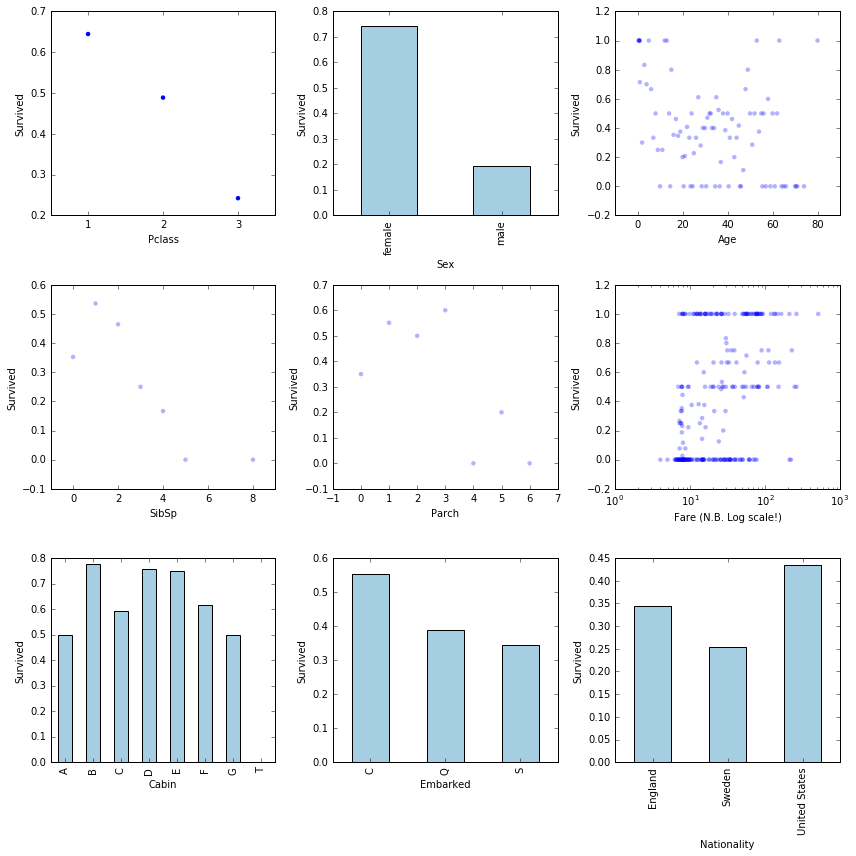

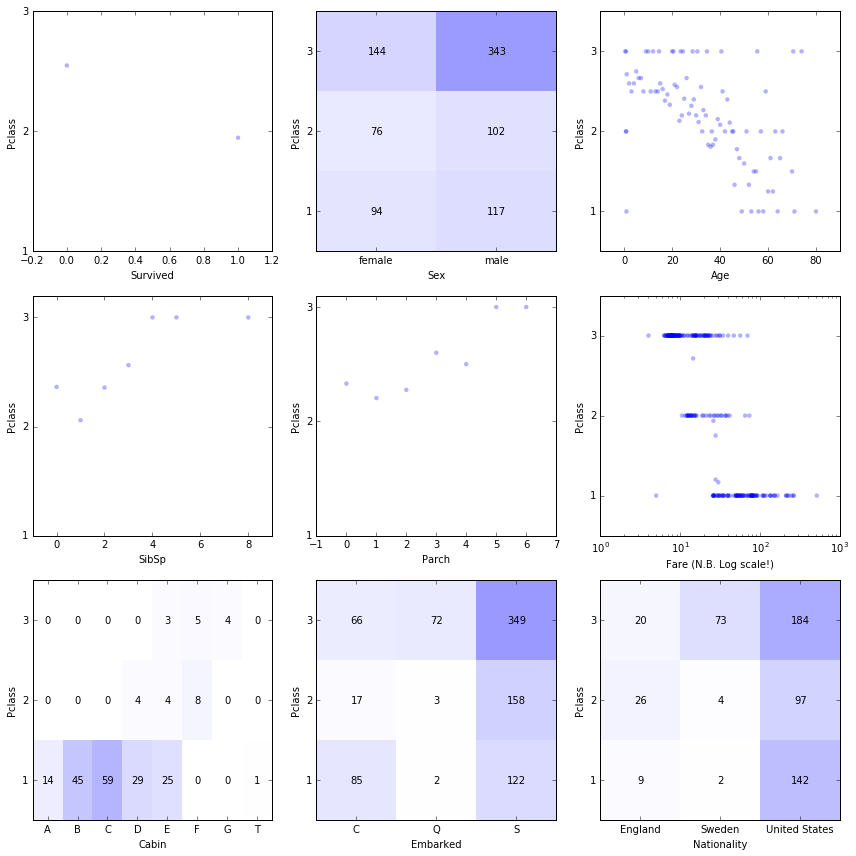

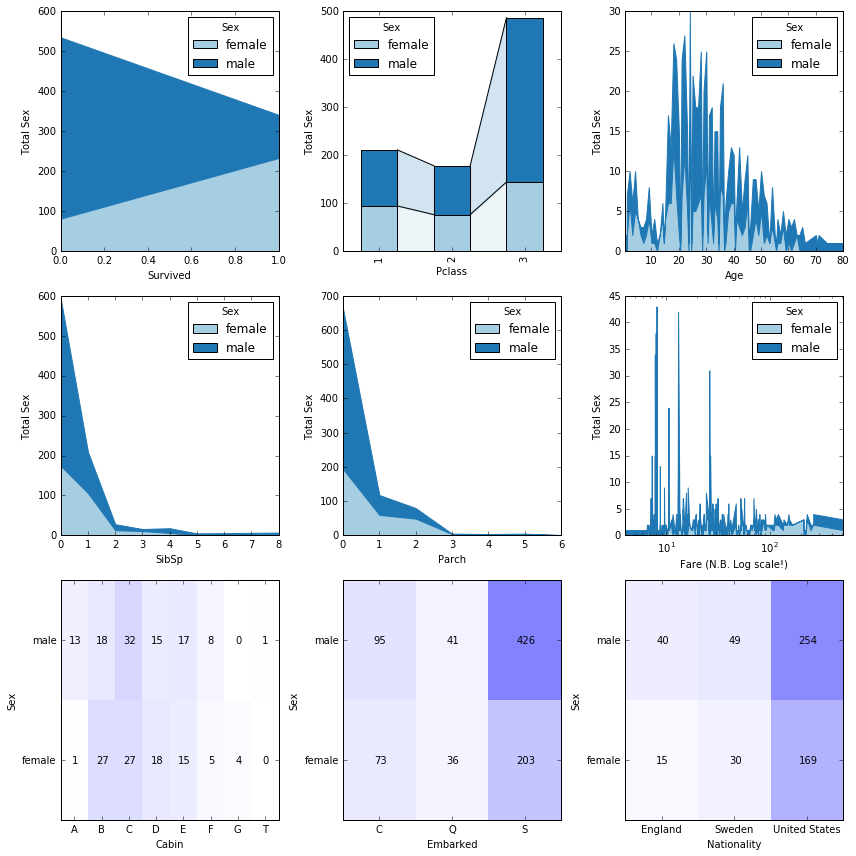

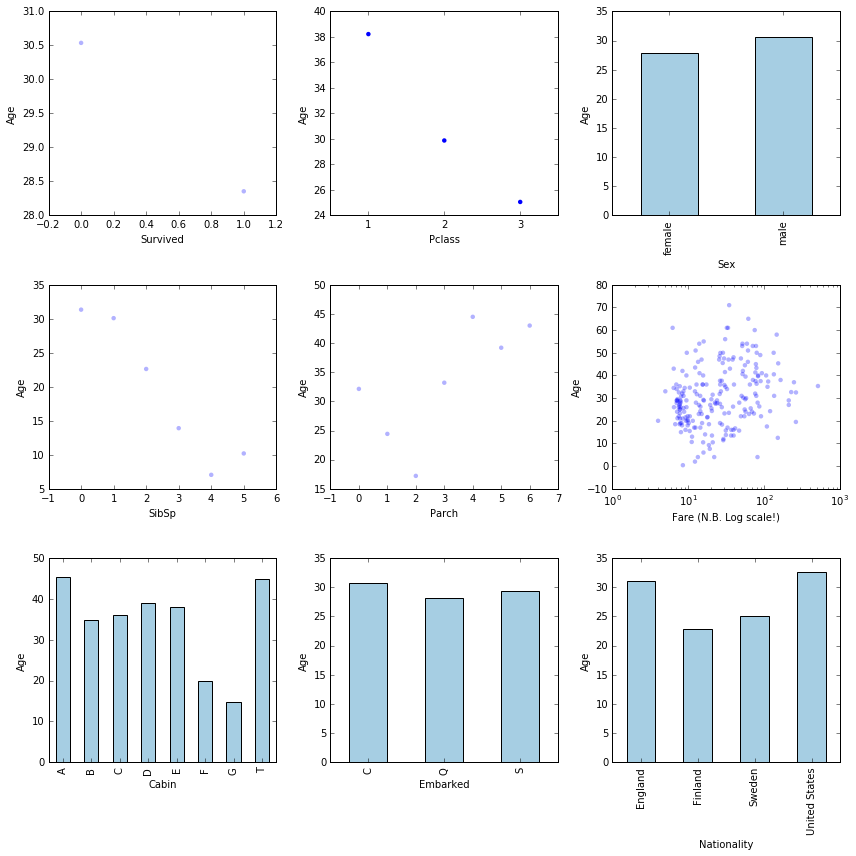

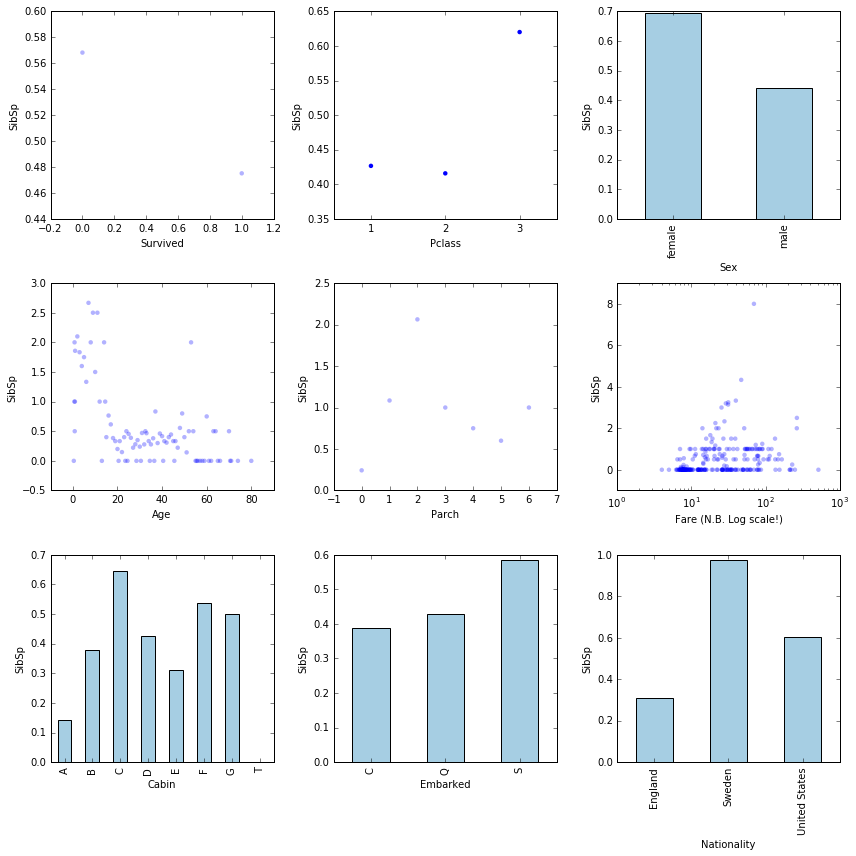

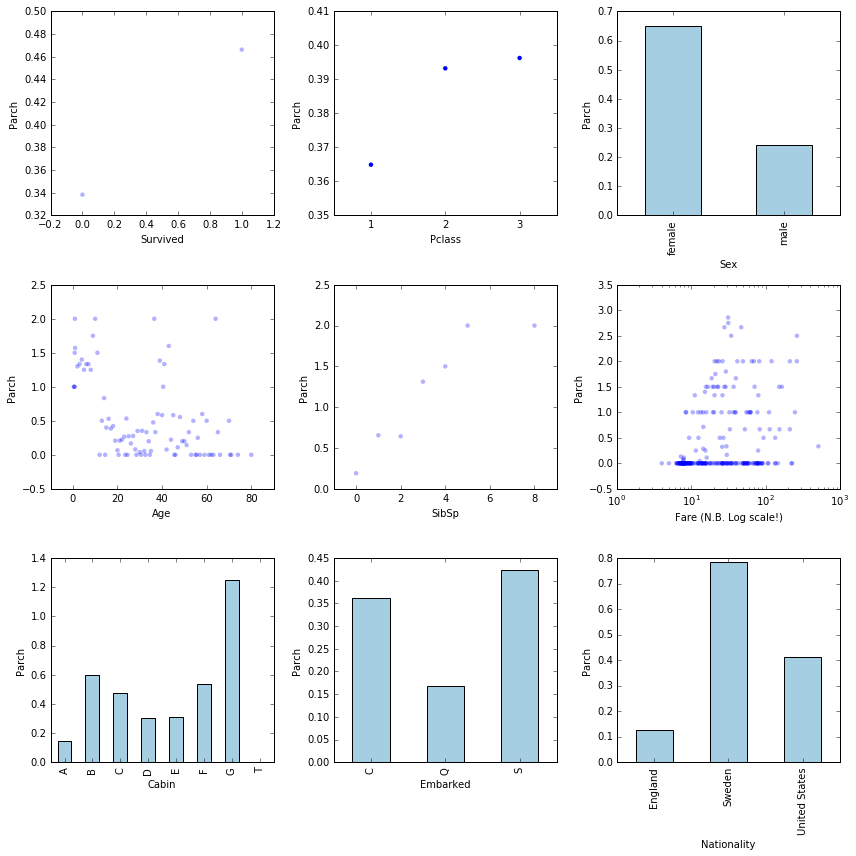

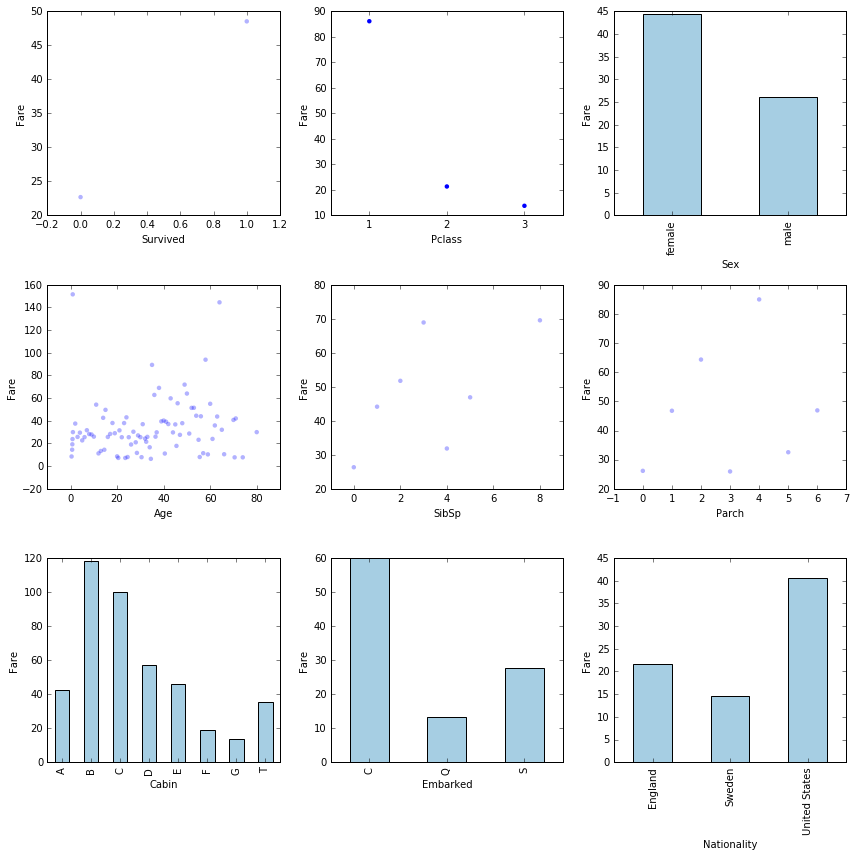

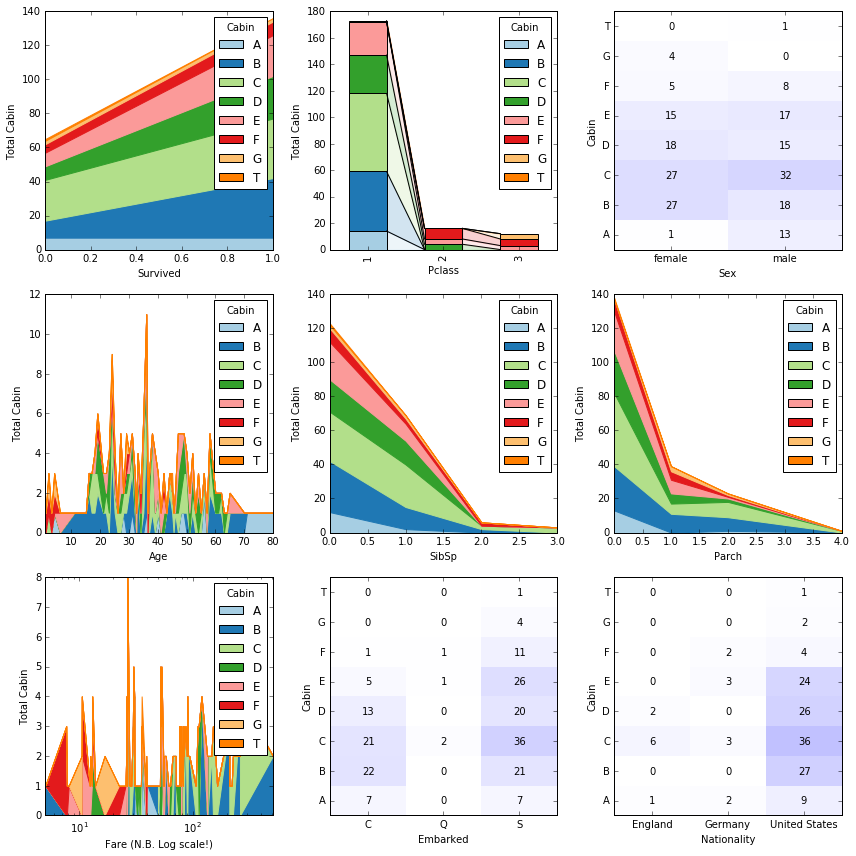

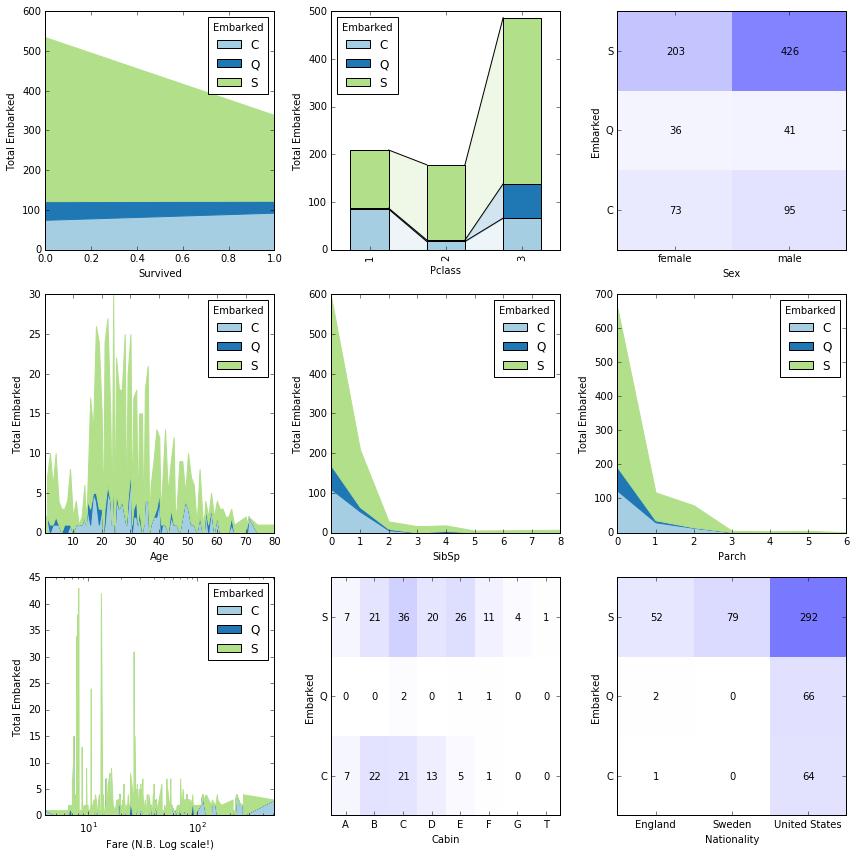

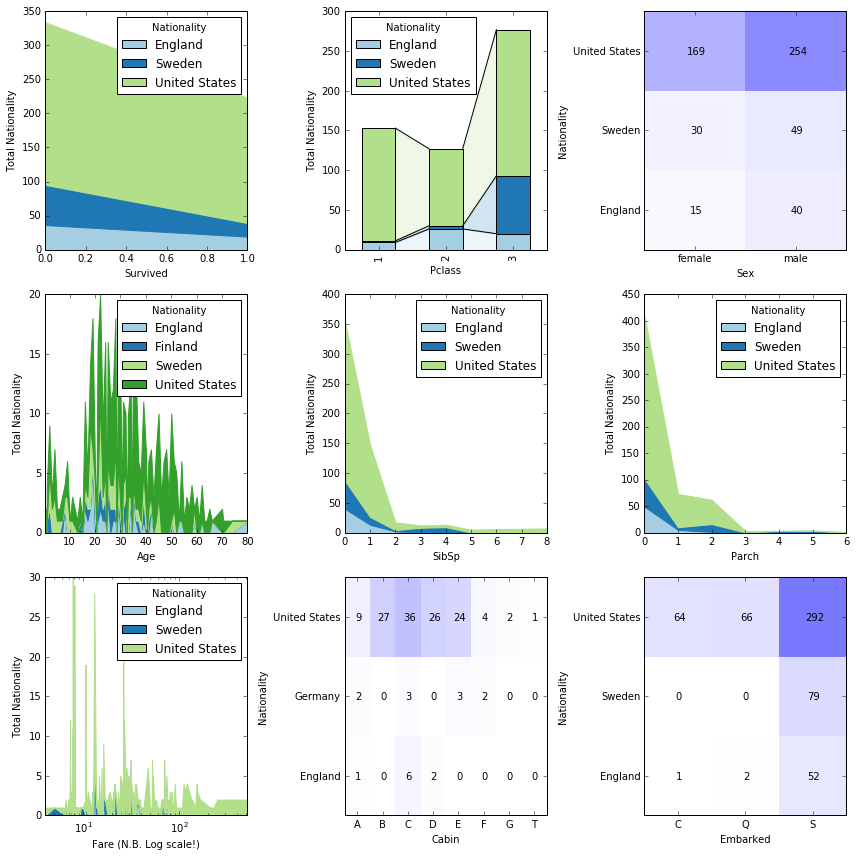

In [21]:
#================================================================================================
# USER INPUT!
# Here I specify the ordering of the ordinal data. Each dataframe's ordinal data is given as
# a dictionary, with structure {ordinalcolumnname: [firstelement, secondelement, ....]}
# e.g. {"BoxSize": ["small", "medium", "large"]}
orderings = [
    {"Pclass": [1,2,3]} #NB only need to include columns that are not numeric!
]
#================================================================================================

# FROM HERE ON IT'S AUTOMATIC

for ii in range(len(alldataframes)):
    print "ANALYZING DATAFRAME FROM " + datafilenames[ii] + ":"
    print "===================================================="
    plotAllCorrelations(alldataframes[ii], datacategories[ii], uselesscolumns[ii], unknowns[ii], orderings[ii])
    plt.show()

### Functions for extracting basic correlations between "numerical" columns

In [22]:
# Returns a dataframe containing the correlation-values between all pairs of "numerical" columns in the dataframe.
def makeCorrelationDataFrame(thedataframe, dictofunknowns):
    replacementdictionary = deepcopy(unknowns[ii])
    for key in replacementdictionary:
        replacementdictionary[key] = {replacementdictionary[key]: np.nan}
    return alldataframes[ii].replace(replacementdictionary).corr()

# Returns a dataframe describing the correlations between numeric columns in the inputdataframe, 
# along with a tuple of the names of the pair of columns.
def listCorrelationsAndTheirColumns(inputdataframe, dictofunknowns):
    correlationmat = makeCorrelationDataFrame(inputdataframe, dictofunknowns)
    # We upper-triangularize the correlation matrix by setting to zero the diagonal and
    # everything under it.
    for row in range(len(correlationmat)):
        for col in range(len(correlationmat)):
            if row>=col:
                correlationmat.iloc[row,col] = 0.0
    # Now we list and sort all absolute-values of the entries of the dataframe
    allvalues = correlationmat.values.ravel()
    # Now we remove the zeros
    allvalues = np.array([el for el in allvalues if el!=0])
    sortedvalues = np.flipud(np.sort(np.absolute(allvalues)))
    corrvaluesandtheircolumnnames = [(allvalues[np.append(np.where(allvalues==val),np.where(allvalues==-val))[0]], 
                                      getRowAndColNames(correlationmat, val)) 
                                     for ij,val in enumerate(sortedvalues)]
    dictfordataframe = {"Correlation": [el[0] for el in corrvaluesandtheircolumnnames], 
                        "ColumnNames": [el[1] for el in corrvaluesandtheircolumnnames]}
    orderedcorrelations = pd.DataFrame(dictfordataframe).set_index("Correlation")
    return orderedcorrelations

#### Helper functions for finding basic correlations

In [23]:
# Returns the name of the row and column in correlationmat, whose value is either
# equal to val or minus val.
def getRowAndColNames(correlationmat, val):
    correlationnames = (None,None)
    for col in correlationmat:
        foundrow = correlationmat[col][correlationmat[col]==val]
        if len(foundrow)==0:
            foundrow = correlationmat[col][correlationmat[col]==-val]
        if len(foundrow)!=0:
            correlationnames = np.sort([col, foundrow.index[0]])
            correlationnames = correlationnames[0] + " - " + correlationnames[1]
    return correlationnames

### Compute correlation between all pairs of "numerical" columns

Finally, we will do some very basic numerical analysis on the correlations between various numerical features, as interpreted by panda's automatic function .corr()

In [24]:
for ii in range(len(alldataframes)):
    print "ANALYZING DATAFRAME FROM " + datafilenames[ii] + ":"
    print "===================================================="
    print makeCorrelationDataFrame(alldataframes[ii], unknowns[ii])
    print "\nIn order of how strongly columns are correlated:\n"
    print listCorrelationsAndTheirColumns(alldataframes[ii], unknowns[ii])

ANALYZING DATAFRAME FROM natinalitycleantrain.csv:
          Survived    Pclass       Age     SibSp     Parch      Fare
Survived  1.000000 -0.351636 -0.073725 -0.040941  0.076939  0.252453
Pclass   -0.351636  1.000000 -0.369699  0.080304  0.014962 -0.561517
Age      -0.073725 -0.369699  1.000000 -0.307492 -0.187987  0.098981
SibSp    -0.040941  0.080304 -0.307492  1.000000  0.412577  0.155240
Parch     0.076939  0.014962 -0.187987  0.412577  1.000000  0.212137
Fare      0.252453 -0.561517  0.098981  0.155240  0.212137  1.000000

In order of how strongly columns are correlated:

                   ColumnNames
Correlation                   
-0.561517        Fare - Pclass
 0.412577        Parch - SibSp
-0.369699         Age - Pclass
-0.351636    Pclass - Survived
-0.307492          Age - SibSp
 0.252453      Fare - Survived
 0.212137         Fare - Parch
-0.187987          Age - Parch
 0.155240         Fare - SibSp
 0.098981           Age - Fare
 0.080304       Pclass - SibSp
 0.076939   